In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

from skopt import gp_minimize

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data, plot_latent_states 
from tools.ae_v2 import Autoencoder
from tools.hyper_param import trainAE_and_return_testError

In [8]:
strategy = None

In [9]:
# setting seed for PRNGs
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-06-18 12:44:15.025248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 12:44:15.025554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 12:44:15.080173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 12:44:15.080446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 12:44:15.080694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 12:44:15.082498: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 12:44:15.085137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 12:44:15.085743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-18 12:44:15.086329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful N

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *


# loading data directory
data_dir_idx = '008'

# making ae save directory
dir_name_ae_nsb = os.getcwd() + dir_sep + 'saved_ae_ContractiveLmda_SearchBayes'
if not os.path.isdir(dir_name_ae_nsb):
    os.makedirs(dir_name_ae_nsb)

counter = 0
while True:
    dir_check = 'nsb_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_ae_nsb + dir_sep + dir_check):
        counter += 1
    else:
        break
        
dir_name_ae_nsb = dir_name_ae_nsb + dir_sep + dir_check
os.makedirs(dir_name_ae_nsb)
dir_name_aensb_plots = dir_name_ae_nsb+dir_sep+'plots'
os.makedirs(dir_name_aensb_plots)

print('dir_name_ae_nsb:', dir_name_ae_nsb)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae_nsb: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021075578292, lyapunov time : 1.1039938926696777s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        save_dir=None,
        ax_titles_list=None,
        plot_time=None,
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    
    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        if plot_time != None:
            plot_idx = int((plot_time + 0.5*delta_t) // delta_t)
            next_idx = prev_idx + plot_idx
        fig = plt.figure(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        ax_orig = fig.add_subplot(num_rows, num_cols, 1, projection ='3d')
        ax_orig.plot(all_data[prev_idx:next_idx, 0], all_data[prev_idx:next_idx, 1], all_data[prev_idx:next_idx, 2])
        ax_orig.title.set_text(r'Actual Data - [$\sigma$, $\rho$, $\beta$] = ' + np.array2string(all_data[next_idx-1, 3:], precision=2, separator=', '))
        ax_orig.set_xlabel(r'$x_1$')
        ax_orig.set_ylabel(r'$x_2$')
        ax_orig.set_zlabel(r'$x_3$')
        
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax_orig.title.set_text(ax_titles_list[i])
        else:
            ax_orig.title.set_text(r'Case '+str(i+1))

        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.pdf', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = boundary_idx_arr[i]

    # '''

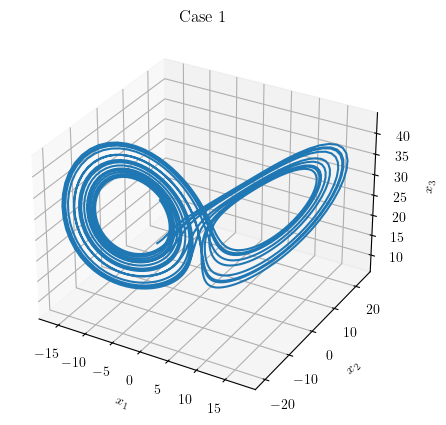

In [15]:
plot_time = 20

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    plot_time=plot_time,)

In [16]:
positve_lp_idx = np.where(lyapunov_time_arr > 0)[0]
print(positve_lp_idx)

[0]


In [17]:
last_idx = all_data.shape[0]
temp_bia = np.zeros(shape=1+boundary_idx_arr.shape[0], dtype=np.int32)
temp_bia[1:] = boundary_idx_arr
print(temp_bia)
for i in range(boundary_idx_arr.shape[0]-1, -1, -1):
    if not (i in positve_lp_idx):
        print(i)
        num_idxs = last_idx - temp_bia[i+1]
        all_data[temp_bia[i]:temp_bia[i]+num_idxs] = all_data[temp_bia[i+1]:last_idx]
        last_idx = last_idx - (temp_bia[i+1]-temp_bia[i])

[     0 100001]


In [18]:
new_bia = np.empty_like(boundary_idx_arr)
new_bia[:] = boundary_idx_arr
new_pmat = np.empty_like(params_mat)
new_pmat[:, :] = params_mat
counter = 0
bia_counter = boundary_idx_arr.shape[0]
for i in range(boundary_idx_arr.shape[0]):
    if not (i in positve_lp_idx):
        new_bia[i:] -= temp_bia[i+1] - temp_bia[i]
        new_bia[i:bia_counter-1] = new_bia[i+1:bia_counter]
        new_pmat[i:bia_counter-1] = new_pmat[i+1:bia_counter]
        bia_counter -= 1

In [19]:
new_bia = new_bia[0:bia_counter]
new_pmat = new_pmat[0:bia_counter]

In [20]:
all_data = all_data[0:new_bia[-1]]

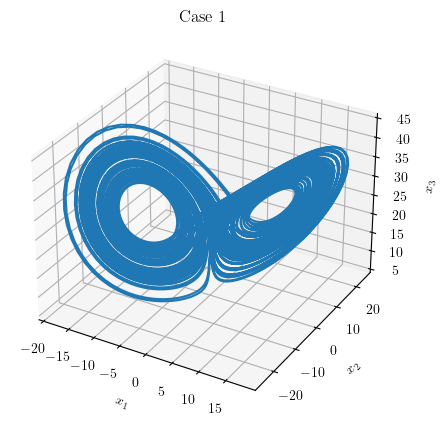

In [21]:
plot_time = 100

plot(
    new_bia,
    delta_t,
    all_data,
    plot_time=plot_time,)

In [22]:
new_bia, boundary_idx_arr = boundary_idx_arr, new_bia
new_pmat, params_mat = params_mat, new_pmat

In [23]:
# dealing with normalizing the data before feeding into autoencoder

# normalize data before feeding into autoencoder?
normalizeforae_flag = True
normalization_type = 'stddev' # could be 'stddev' or 'minmax'
stddev_multiplier = 3
stddev_multiplier_pm = 1
num_params = params_mat.shape[1]

ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

if ae_data_with_params == False:
    stddev_multiplier_pm = None
if normalizeforae_flag == False:
    stddev_multiplier = None

if ae_data_with_params == True and alldata_withparams_flag == False:
    new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
    new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
    del(all_data)
    all_data = new_all_data
    prev_idx = 0
    for i in range(boundary_idx_arr.shape[0]):
        all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
        prev_idx = boundary_idx_arr[i]

normalization_constant_arr_aedata = None
if normalizeforae_flag == True:
    normalization_constant_arr_aedata = np.empty(shape=(2, all_data.shape[1]), dtype=FTYPE)
    if normalization_type == 'stddev':
        sample_mean = np.mean(all_data, axis=0)
        sample_std = np.std(all_data, axis=0)
        normalization_constant_arr_aedata[0, :] = sample_mean
        normalization_constant_arr_aedata[1, 0:og_vars] = stddev_multiplier*sample_std[0:og_vars]
        if ae_data_with_params == True:
            normalization_constant_arr_aedata[1, og_vars:] = stddev_multiplier_pm*sample_std[og_vars:]
        zero_idx = np.where(normalization_constant_arr_aedata[1] == 0.0)[0]
        if len(zero_idx) > 0:
            normalization_constant_arr_aedata[1, zero_idx] = 1.0
    elif normalization_type == 'minmax':
        for i in range(all_data.shape[1]):
            sample_min = np.min(all_data[:, i])
            sample_max = np.max(all_data[:, i])
            if sample_max - sample_min == 0:
                sample_min = sample_min - 0.5
                sample_max = sample_min + 1
            normalization_constant_arr_aedata[0, i] = sample_min
            normalization_constant_arr_aedata[1, i] = sample_max - sample_min
    # if ae_data_with_params == True:
    #     normalization_constant_arr_aedata[0, og_vars:] = 0.0
    #     normalization_constant_arr_aedata[1, og_vars:] = 1.0
    for i in range(all_data.shape[1]):
        all_data[:, i] -= normalization_constant_arr_aedata[0, i]
        all_data[:, i] /= normalization_constant_arr_aedata[1, i]

# saving sim data
ae_data = {
    'data_dir_idx':data_dir_idx,
    'normalizeforae_flag':normalizeforae_flag,
    'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
    'normalization_type':normalization_type,
    'stddev_multiplier':stddev_multiplier,
    'stddev_multiplier_pm':stddev_multiplier_pm,
    'ae_data_with_params':ae_data_with_params,
    'module':Autoencoder.__module__,
}
with open(dir_name_ae_nsb+dir_sep+'ae_data.txt', 'w') as f:
    f.write(str(ae_data))
np.savez(
    dir_name_ae_nsb+dir_sep+'normalization_data',
    normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
)
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
    time_stddev = time_stddev[0:og_vars]
else:
    time_stddev[og_vars:] = 1.0

In [24]:
normalization_constant_arr_aedata

array([[ 0.1919329 ,  0.19295387, 23.526415  ],
       [23.75482   , 27.052578  , 25.936165  ]], dtype=float32)

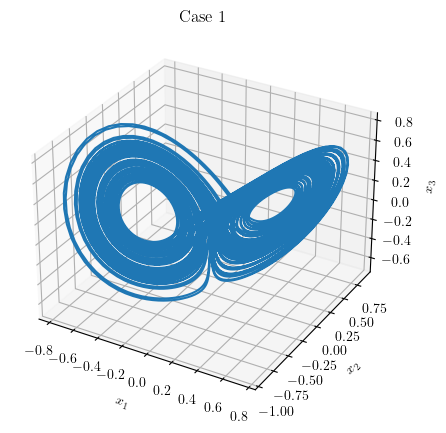

In [25]:
plot_time = 100

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    plot_time=plot_time,)

# Autoencoder

In [26]:
# setting up training params
learning_rate_list = [1e-3, 1e-4, 1e-5]
epochs = 200
patience = 10  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
train_split = 0.8
val_split = 0.1
test_split = 1 - train_split - val_split
batch_size = 2**6
dt_ae = 0.1

# stddev = fRMS*timeMeanofSpaceRMS
# contractive_lmda = 0.0
fRMS = 1.08643105e-03
lambda_reg = 1.01045731e-06
use_weights_post_dense = True
dropout_rate = 0.0


# saving training params
training_specific_params = {
    'learning_rate_list':learning_rate_list,
    'epochs':epochs,
    'patience':patience,
    'min_delta':min_delta,
    'prng_seed':prng_seed,
    'train_split':train_split,
    'val_split':val_split,
    'batch_size':batch_size,
    # 'contractive_lmda':contractive_lmda,
    'dropout_rate':dropout_rate,
    'dt_ae':dt_ae,
    'fRMS':fRMS,
    'lambda_reg':lambda_reg,
}

with open(dir_name_ae_nsb+dir_sep+'training_specific_params.txt', 'w') as f:
    f.write(str(training_specific_params))

In [27]:
skip_factor = int(dt_ae/delta_t)

for i in range(len(boundary_idx_arr)-1, -1, -1):
    end_idx = boundary_idx_arr[i]
    if i == 0:
        begin_idx = 0
    else:
        begin_idx = boundary_idx_arr[i-1]

    num_elems_pre_indexing = end_idx - begin_idx
    num_elems_post_indexing = (num_elems_pre_indexing+skip_factor-1)//skip_factor

    boundary_idx_arr[i:] -= num_elems_pre_indexing-num_elems_post_indexing

    all_data[begin_idx:begin_idx+num_elems_post_indexing] = all_data[begin_idx:end_idx:skip_factor]
    all_data[begin_idx+num_elems_post_indexing:begin_idx+(boundary_idx_arr[-1]-boundary_idx_arr[i])] = all_data[end_idx:boundary_idx_arr[-1]+num_elems_post_indexing]

all_data = all_data[0:boundary_idx_arr[-1]]

In [28]:
boundary_idx_arr

array([10001])

In [29]:
all_data.shape

(10001, 3)

In [30]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( np.round(train_split*num_samples) )
    num_val += int( np.round(val_split*num_samples) )
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train = int( np.round(train_split*num_samples) )
    num_val = int( np.round(val_split*num_samples) )

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[begin_idx:begin_idx+num_train]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[begin_idx+num_train:begin_idx+num_train+num_val]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[begin_idx+num_train+num_val:begin_idx+num_train+num_val+num_test]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [31]:
#

In [32]:
# Initialize network
latent_space_dim = 2
# enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
# enc_layers = [192, 96, 48, 24, 12, 6, 3]
# enc_layers = [96, 48, 24, 12, 6, 3]
# enc_layers = [128, 64, 32, 16, 8, 4]
# enc_layers = []
# enc_layers = [32, 16, 8, 4]
# for i in range(len(enc_layers)):
#     if latent_space_dim < enc_layers[-i-1]:
#         enc_layers = enc_layers[0:-i]
#         break
#     if i == len(enc_layers)-1:
#         enc_layers = []
# dec_layers = enc_layers[::-1]
enc_layers = [8, 8, 4, 4, 2]
dec_layers = [2, 4, 4, 8, 8]

enc_layer_act_func = 'elu' #'modified_relu_2'
enc_final_layer_act_func = 'tanh'
dec_layer_act_func = 'elu' #'modified_relu_2'
dec_final_layer_act_func = 'tanh'
reg_name = 'L2'

In [33]:
#

In [34]:
def optim_func(
        x, # [contractive_lmda]
        time_stddev=time_stddev,
        Autoencoder=Autoencoder,
        mytimecallback=mytimecallback,
        SaveLosses=SaveLosses,
        plot_losses=plot_losses,
        readAndReturnLossHistories=readAndReturnLossHistories,
        plot_reconstructed_data=plot_reconstructed_data,
        plot_latent_states=plot_latent_states,
        dir_name_ae=dir_name_ae_nsb,
        training_data=training_data,
        testing_data=testing_data,
        val_data=val_data,
        boundary_idx_arr=boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        fRMS=fRMS,
        lambda_reg=lambda_reg,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name,
    ):
    
    test_mse = trainAE_and_return_testError(
        [fRMS, lambda_reg, x[0]], # [fRMS, lambda_reg]
        time_stddev,
        og_vars,
        Autoencoder,
        mytimecallback,
        SaveLosses,
        plot_losses,
        readAndReturnLossHistories,
        plot_reconstructed_data,
        plot_latent_states,
        dir_name_ae,
        training_data,
        testing_data,
        val_data,
        boundary_idx_arr,
        prng_seed=prng_seed,
        learning_rate_list=learning_rate_list,
        epochs=epochs,
        patience=patience,  # parameter for early stopping
        min_delta=min_delta,  # parameter for early stopping
        batch_size=batch_size,
        contractive_lmda=None,
        use_weights_post_dense=use_weights_post_dense,
        dropout_rate=dropout_rate,
        latent_space_dim=latent_space_dim,
        enc_layers=enc_layers,
        dec_layers=dec_layers,
        enc_layer_act_func=enc_layer_act_func, #'modified_relu_2'
        enc_final_layer_act_func=enc_final_layer_act_func,
        dec_layer_act_func=dec_layer_act_func, #'modified_relu_2'
        dec_final_layer_act_func=dec_final_layer_act_func,
        reg_name=reg_name
    )
    
    return test_mse

In [35]:
contractive_lmda_bounds = (1e-6, 1e-1, "log-uniform")
acq_func = "EI"
n_initial_points = 10
n_calls = n_initial_points + 20


optim_dict = {
    'contractive_lmda_bounds':contractive_lmda_bounds,
    'n_calls':n_calls,
    'acq_func':acq_func,
    'n_initial_points':n_initial_points,
    'random_state':prng_seed,
}
with open(dir_name_ae_nsb + '/optim_params.txt', 'w') as f:
    f.write(str(optim_dict))

In [36]:
res = gp_minimize(
    optim_func,
    [contractive_lmda_bounds,],
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    random_state=prng_seed,
    acq_func=acq_func,
)



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
122/126 [============================>.] - ETA: 0s - loss: 0.0593 - mse: 0.0592 - NMSE: 0.5329 - real_MSE: 0.0592 - params_MSE: nan - ls_jacobian_norm: 0.5997 - tot_time: 0h 0m 3.7s

Epoch 1: val_mse improved from inf to 0.04186, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 4s 10ms/step - loss: 0.0589 - mse: 0.0588 - NMSE: 0.5294 - real_MSE: 0.0588 - params_MSE: nan - ls_jacobian_norm: 0.5936 - val_loss

122/126 [============================>.] - ETA: 0s - loss: 0.0273 - mse: 0.0272 - NMSE: 0.2447 - real_MSE: 0.0272 - params_MSE: nan - ls_jacobian_norm: 0.1946 - tot_time: 0h 0m 11.8s

Epoch 10: val_mse did not improve from 0.02608
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0272 - mse: 0.0272 - NMSE: 0.2445 - real_MSE: 0.0272 - params_MSE: nan - ls_jacobian_norm: 0.1955 - val_loss: 0.0406 - val_mse: 0.0405 - val_NMSE: 0.3649 - val_real_MSE: 0.0405 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
123/126 [============================>.] - ETA: 0s - loss: 0.0277 - mse: 0.0277 - NMSE: 0.2489 - real_MSE: 0.0277 - params_MSE: nan - ls_jacobian_norm: 0.1819 - tot_time: 0h 0m 12.6s

Epoch 11: val_mse improved from 0.02608 to 0.02572, saving model to /home/rkaushik/Documents/The

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0270 - mse: 0.0269 - NMSE: 0.2423 - real_MSE: 0.0269 - params_MSE: nan - ls_jacobian_norm: 0.1051 - val_loss: 0.0254 - val_mse: 0.0253 - val_NMSE: 0.2277 - val_real_MSE: 0.0253 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0265 - mse: 0.0264 - NMSE: 0.2375 - real_MSE: 0.0264 - params_MSE: nan - ls_jacobian_norm: 0.0998 - tot_time: 0h 0m 21.5s

Epoch 21: val_mse did not improve from 0.02530
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0265 - mse: 0.0264 - NMSE: 0.2375 -

Epoch 31/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0064 - mse: 0.0063 - NMSE: 0.0566 - real_MSE: 0.0063 - params_MSE: nan - ls_jacobian_norm: 0.1549 - tot_time: 0h 0m 30.2s

Epoch 31: val_mse improved from 0.00870 to 0.00703, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0064 - mse: 0.0063 - NMSE: 0.0565 - real_MSE: 0.0063 - params_MSE: nan - ls_jacobian_norm: 0.1545 - val_loss: 0.0071 - val_mse: 0.0070 - val_NMSE: 0.0633 - val_real_MSE: 0.0070 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0056 - mse: 0.0056 - NMSE: 0.0500 - real_MSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0049 - mse: 0.0049 - NMSE: 0.0437 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.0902 - val_loss: 0.0050 - val_mse: 0.0050 - val_NMSE: 0.0446 - val_real_MSE: 0.0050 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0048 - mse: 0.0047 - NMSE: 0.0427 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 0.0881 - tot_time: 0h 0m 39.4s

Epoch 42: val_mse did not improve from 0.00472
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0428 -

126/126 [==============================] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0380 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.0772 - tot_time: 0h 0m 48.2s

Epoch 52: val_mse did not improve from 0.00422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0380 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.0772 - val_loss: 0.0053 - val_mse: 0.0052 - val_NMSE: 0.0465 - val_real_MSE: 0.0052 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0042 - mse: 0.0041 - NMSE: 0.0373 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 0.0775 - tot_time: 0h 0m 49.0s

Epoch 53: val_mse improved from 0.00422 to 0.00401, saving model to /home/rkaushik/Documents/The

Epoch 63/200
122/126 [============================>.] - ETA: 0s - loss: 0.0033 - mse: 0.0032 - NMSE: 0.0290 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.0783 - tot_time: 0h 0m 57.6s

Epoch 63: val_mse did not improve from 0.00336
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0033 - mse: 0.0032 - NMSE: 0.0289 - real_MSE: 0.0032 - params_MSE: nan - ls_jacobian_norm: 0.0785 - val_loss: 0.0056 - val_mse: 0.0055 - val_NMSE: 0.0499 - val_real_MSE: 0.0055 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0035 - mse: 0.0034 - NMSE: 0.0309 - real_MSE: 0.0034 - params_MSE: nan - ls_jacobian_norm: 0.0812 - tot_time: 0h 0m 58.4s

Epoch 64: val_mse improved from 0.00336 to 0.00311, saving model to /home/rkaushik/

Epoch 74/200
123/126 [============================>.] - ETA: 0s - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0170 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.0921 - tot_time: 0h 1m 6.8s

Epoch 74: val_mse improved from 0.00275 to 0.00168, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0170 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.0924 - val_loss: 0.0018 - val_mse: 0.0017 - val_NMSE: 0.0151 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 75/200
123/126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0146 - real_MSE: 0

Epoch 85/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0096 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0875 - tot_time: 0h 1m 16.3s

Epoch 85: val_mse improved from 0.00103 to 0.00101, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0874 - val_loss: 0.0011 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 86/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 9.6252e-04 - NMSE: 0.0087 - real_M

Epoch 96/200
122/126 [============================>.] - ETA: 0s - loss: 9.6811e-04 - mse: 8.5795e-04 - NMSE: 0.0077 - real_MSE: 8.5795e-04 - params_MSE: nan - ls_jacobian_norm: 0.0737 - tot_time: 0h 1m 26.1s

Epoch 96: val_mse did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.6737e-04 - mse: 8.5721e-04 - NMSE: 0.0077 - real_MSE: 8.5721e-04 - params_MSE: nan - ls_jacobian_norm: 0.0735 - val_loss: 0.0016 - val_mse: 0.0015 - val_NMSE: 0.0131 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 97/200
125/126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 8.9436e-04 - NMSE: 0.0080 - real_MSE: 8.9436e-04 - params_MSE: nan - ls_jacobian_norm: 0.0730   - tot_time: 0h 1m 26.9s

Epoch 97: val_mse did not improve from 0.00081
 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.7401e-04 - mse: 7.6404e-04 - NMSE: 0.0069 - real_MSE: 7.6404e-04 - params_MSE: nan - ls_jacobian_norm: 0.0740 - val_loss: 8.6021e-04 - val_mse: 7.5021e-04 - val_NMSE: 0.0068 - val_real_MSE: 7.5021e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
126/126 [==============================] - ETA: 0s - loss: 8.6939e-04 - mse: 7.5937e-04 - NMSE: 0.0068 - real_MSE: 7.5937e-04 - params_MSE: nan - ls_jacobian_norm: 0.0740 - tot_time: 0h 1m 35.4s

Epoch 2: val_mse improved from 0.00075 to 0.00074, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_

124/126 [============================>.] - ETA: 0s - loss: 8.6339e-04 - mse: 7.5268e-04 - NMSE: 0.0068 - real_MSE: 7.5268e-04 - params_MSE: nan - ls_jacobian_norm: 0.0720Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 1m 44.5s

Epoch 12: val_mse did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.6574e-04 - mse: 7.5502e-04 - NMSE: 0.0068 - real_MSE: 7.5502e-04 - params_MSE: nan - ls_jacobian_norm: 0.0720 - val_loss: 8.5323e-04 - val_mse: 7.4247e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.4247e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

-------

Epoch 11/200
122/126 [============================>.] - ETA: 0s - loss: 8.6363e-04 - mse: 7.5347e-04 - NMSE: 0.0068 - real_MSE: 7.5347e-04 - params_MSE: nan - ls_jacobian_norm: 0.0736Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 1m 53.7s

Epoch 11: val_mse did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_000/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.6738e-04 - mse: 7.5722e-04 - NMSE: 0.0068 - real_MSE: 7.5722e-04 - params_MSE: nan - ls_jacobian_norm: 0.0738 - val_loss: 8.5247e-04 - val_mse: 7.4230e-04 - val_NMSE: 0.0067 - val_real_MSE: 7.4230e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11: early stopping
32/32 [==============================] - 0s 3ms/step - loss: 8.5107e-04 - mse: 7.4100e-04 - NMSE: 0.0067 - real_MSE: 7.4100e-04 - params_MSE: nan - ls_jacobian_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0453 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6157 - val_loss: 0.0047 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
124/126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.5732 - tot_time: 0h 0m 10.5s

Epoch 9: val_mse improved from 0.00466 to 0.00456, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5121 - val_loss: 0.0025 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.4967 - tot_time: 0h 0m 19.2s

Epoch 19: val_mse did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 -

Epoch 29/200
126/126 [==============================] - ETA: 0s - loss: 0.0011 - mse: 9.8514e-04 - NMSE: 0.0089 - real_MSE: 9.8514e-04 - params_MSE: nan - ls_jacobian_norm: 0.4528 - tot_time: 0h 0m 28.0s

Epoch 29: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0011 - mse: 9.8514e-04 - NMSE: 0.0089 - real_MSE: 9.8514e-04 - params_MSE: nan - ls_jacobian_norm: 0.4532 - val_loss: 0.0011 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 9.2358e-04 - NMSE: 0.0083 - real_MSE: 9.2358e-04 - params_MSE: nan - ls_jacobian_norm: 0.4545 - tot_time: 0h 0m 28.8s

Epoch 30: val_mse did not improve from 0.00106
 - saving lo

Epoch 39/200
126/126 [==============================] - ETA: 0s - loss: 8.1422e-04 - mse: 7.3514e-04 - NMSE: 0.0066 - real_MSE: 7.3514e-04 - params_MSE: nan - ls_jacobian_norm: 0.4883 - tot_time: 0h 0m 36.2s

Epoch 39: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.1422e-04 - mse: 7.3514e-04 - NMSE: 0.0066 - real_MSE: 7.3514e-04 - params_MSE: nan - ls_jacobian_norm: 0.4882 - val_loss: 8.0803e-04 - val_mse: 7.2886e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.2886e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
124/126 [============================>.] - ETA: 0s - loss: 7.4309e-04 - mse: 6.6384e-04 - NMSE: 0.0060 - real_MSE: 6.6384e-04 - params_MSE: nan - ls_jacobian_norm: 0.4863 - tot_time: 0h 0m 37.0s

Epoch 40: val_mse did not improve f

Epoch 50/200
120/126 [===========================>..] - ETA: 0s - loss: 6.3525e-04 - mse: 5.5432e-04 - NMSE: 0.0050 - real_MSE: 5.5432e-04 - params_MSE: nan - ls_jacobian_norm: 0.5087 - tot_time: 0h 0m 45.0s

Epoch 50: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.3416e-04 - mse: 5.5322e-04 - NMSE: 0.0050 - real_MSE: 5.5322e-04 - params_MSE: nan - ls_jacobian_norm: 0.5071 - val_loss: 8.6339e-04 - val_mse: 7.8235e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.8235e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
121/126 [===========================>..] - ETA: 0s - loss: 6.3569e-04 - mse: 5.5461e-04 - NMSE: 0.0050 - real_MSE: 5.5461e-04 - params_MSE: nan - ls_jacobian_norm: 0.5102 - tot_time: 0h 0m 45.8s

Epoch 51: val_mse improved from 0.0

123/126 [============================>.] - ETA: 0s - loss: 5.7449e-04 - mse: 4.9224e-04 - NMSE: 0.0044 - real_MSE: 4.9224e-04 - params_MSE: nan - ls_jacobian_norm: 0.5309 - tot_time: 0h 0m 53.2s

Epoch 60: val_mse improved from 0.00059 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7758e-04 - mse: 4.9533e-04 - NMSE: 0.0045 - real_MSE: 4.9533e-04 - params_MSE: nan - ls_jacobian_norm: 0.5316 - val_loss: 5.7445e-04 - val_mse: 4.9215e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.9215e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61/200
126/126 [==============================] - ETA: 0s - loss: 5.5985e-04 - mse: 4.7747e

Epoch 71/200
123/126 [============================>.] - ETA: 0s - loss: 5.2862e-04 - mse: 4.4537e-04 - NMSE: 0.0040 - real_MSE: 4.4537e-04 - params_MSE: nan - ls_jacobian_norm: 0.5408 - tot_time: 0h 1m 2.2s

Epoch 71: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.2842e-04 - mse: 4.4517e-04 - NMSE: 0.0040 - real_MSE: 4.4517e-04 - params_MSE: nan - ls_jacobian_norm: 0.5392 - val_loss: 6.3081e-04 - val_mse: 5.4747e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4747e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 72/200
123/126 [============================>.] - ETA: 0s - loss: 5.3900e-04 - mse: 4.5567e-04 - NMSE: 0.0041 - real_MSE: 4.5567e-04 - params_MSE: nan - ls_jacobian_norm: 0.5431 - tot_time: 0h 1m 3.0s

Epoch 72: val_mse did not improve fro

Epoch 82/200
121/126 [===========================>..] - ETA: 0s - loss: 7.2102e-04 - mse: 6.3734e-04 - NMSE: 0.0057 - real_MSE: 6.3734e-04 - params_MSE: nan - ls_jacobian_norm: 0.5602 - tot_time: 0h 1m 11.5s

Epoch 82: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.1183e-04 - mse: 6.2815e-04 - NMSE: 0.0057 - real_MSE: 6.2815e-04 - params_MSE: nan - ls_jacobian_norm: 0.5599 - val_loss: 6.5338e-04 - val_mse: 5.6959e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6959e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 83/200
123/126 [============================>.] - ETA: 0s - loss: 5.0949e-04 - mse: 4.2569e-04 - NMSE: 0.0038 - real_MSE: 4.2569e-04 - params_MSE: nan - ls_jacobian_norm: 0.5566 - tot_time: 0h 1m 12.4s

Epoch 83: val_mse did not improve f

126/126 [==============================] - ETA: 0s - loss: 4.7811e-04 - mse: 3.9433e-04 - NMSE: 0.0035 - real_MSE: 3.9433e-04 - params_MSE: nan - ls_jacobian_norm: 0.5513 - tot_time: 0h 1m 20.1s

Epoch 3: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.7811e-04 - mse: 3.9433e-04 - NMSE: 0.0035 - real_MSE: 3.9433e-04 - params_MSE: nan - ls_jacobian_norm: 0.5511 - val_loss: 5.0527e-04 - val_mse: 4.2149e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2149e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
125/126 [============================>.] - ETA: 0s - loss: 4.7952e-04 - mse: 3.9571e-04 - NMSE: 0.0036 - real_MSE: 3.9571e-04 - params_MSE: nan - ls_jacobian_norm: 0.5526 - tot_time: 0h 1m 20.9s

Epoch 4: val_mse improved from 0.00042 to 0.00042,

120/126 [===========================>..] - ETA: 0s - loss: 4.7267e-04 - mse: 3.8875e-04 - NMSE: 0.0035 - real_MSE: 3.8875e-04 - params_MSE: nan - ls_jacobian_norm: 0.5490 - tot_time: 0h 1m 28.6s

Epoch 13: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 4.7322e-04 - mse: 3.8929e-04 - NMSE: 0.0035 - real_MSE: 3.8929e-04 - params_MSE: nan - ls_jacobian_norm: 0.5483 - val_loss: 4.9587e-04 - val_mse: 4.1193e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1193e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
123/126 [============================>.] - ETA: 0s - loss: 4.7326e-04 - mse: 3.8931e-04 - NMSE: 0.0035 - real_MSE: 3.8931e-04 - params_MSE: nan - ls_jacobian_norm: 0.5483 - tot_time: 0h 1m 29.5s

Epoch 14: val_mse did not improve from 0.00041
 

125/126 [============================>.] - ETA: 0s - loss: 4.7126e-04 - mse: 3.8738e-04 - NMSE: 0.0035 - real_MSE: 3.8738e-04 - params_MSE: nan - ls_jacobian_norm: 0.5499 - tot_time: 0h 1m 37.2s

Epoch 4: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_001/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7122e-04 - mse: 3.8733e-04 - NMSE: 0.0035 - real_MSE: 3.8733e-04 - params_MSE: nan - ls_jacobian_norm: 0.5481 - val_loss: 4.9575e-04 - val_mse: 4.1186e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1186e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
123/126 [============================>.] - ETA: 0s - loss: 4.6878e-04 - mse: 3.8490e-04 - NMSE: 0.0035 - real_MSE: 3.8490e-04 - params_MSE: nan - ls_jacobian_norm: 0.5497 - tot_time: 0h 1m 38.1s

Epoch 5: val_mse did not improve from 0.00041
 - s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0423 - mse: 0.0422 - NMSE: 0.3802 - real_MSE: 0.0422 - params_MSE: nan - ls_jacobian_norm: 0.3455 - val_loss: 0.0405 - val_mse: 0.0405 - val_NMSE: 0.3641 - val_real_MSE: 0.0405 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
126/126 [==============================] - ETA: 0s - loss: 0.0410 - mse: 0.0409 - NMSE: 0.3683 - real_MSE: 0.0409 - params_MSE: nan - ls_jacobian_norm: 0.2564 - tot_time: 0h 0m 5.1s

Epoch 3: val_mse improved from 0.04046 to 0.03936, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/t

118/126 [===========================>..] - ETA: 0s - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0428 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.1627 - tot_time: 0h 0m 12.9s

Epoch 12: val_mse improved from 0.00497 to 0.00450, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.1623 - val_loss: 0.0046 - val_mse: 0.0045 - val_NMSE: 0.0405 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
124/126 [============================>.] - ETA: 0s - loss: 0.0047 - mse: 0.0047 - NMSE: 0.0419 - real_MSE: 0.0047 - para

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0378 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.1023 - val_loss: 0.0042 - val_mse: 0.0041 - val_NMSE: 0.0371 - val_real_MSE: 0.0041 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0377 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.1017 - tot_time: 0h 0m 22.4s

Epoch 23: val_mse did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0379 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0021 - mse: 0.0020 - NMSE: 0.0177 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.1371 - val_loss: 0.0019 - val_mse: 0.0018 - val_NMSE: 0.0163 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0018 - mse: 0.0017 - NMSE: 0.0157 - real_MSE: 0.0017 - params_MSE: nan - ls_jacobian_norm: 0.1367 - tot_time: 0h 0m 31.2s

Epoch 33: val_mse improved from 0.00181 to 0.00169, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_00

123/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.1095 - tot_time: 0h 0m 39.5s

Epoch 43: val_mse improved from 0.00119 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.1092 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0099 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
122/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0091 - real_MSE: 0.0010 - para

Epoch 54/200
118/126 [===========================>..] - ETA: 0s - loss: 9.3029e-04 - mse: 8.3115e-04 - NMSE: 0.0075 - real_MSE: 8.3115e-04 - params_MSE: nan - ls_jacobian_norm: 0.0899 - tot_time: 0h 0m 48.6s

Epoch 54: val_mse did not improve from 0.00101
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.1956e-04 - mse: 8.2040e-04 - NMSE: 0.0074 - real_MSE: 8.2040e-04 - params_MSE: nan - ls_jacobian_norm: 0.0901 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
125/126 [============================>.] - ETA: 0s - loss: 9.5492e-04 - mse: 8.5530e-04 - NMSE: 0.0077 - real_MSE: 8.5530e-04 - params_MSE: nan - ls_jacobian_norm: 0.0880 - tot_time: 0h 0m 49.3s

Epoch 55: val_mse did not improve from 0.00101


 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.2405e-04 - mse: 8.2065e-04 - NMSE: 0.0074 - real_MSE: 8.2065e-04 - params_MSE: nan - ls_jacobian_norm: 0.0788 - val_loss: 7.6904e-04 - val_mse: 6.6548e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6548e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 65/200
122/126 [============================>.] - ETA: 0s - loss: 8.2695e-04 - mse: 7.2318e-04 - NMSE: 0.0065 - real_MSE: 7.2318e-04 - params_MSE: nan - ls_jacobian_norm: 0.0771 - tot_time: 0h 0m 57.5s

Epoch 65: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8

123/126 [============================>.] - ETA: 0s - loss: 8.0747e-04 - mse: 7.0059e-04 - NMSE: 0.0063 - real_MSE: 7.0059e-04 - params_MSE: nan - ls_jacobian_norm: 0.0699 - tot_time: 0h 1m 5.9s

Epoch 75: val_mse did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.1289e-04 - mse: 7.0601e-04 - NMSE: 0.0064 - real_MSE: 7.0601e-04 - params_MSE: nan - ls_jacobian_norm: 0.0700 - val_loss: 9.2019e-04 - val_mse: 8.1317e-04 - val_NMSE: 0.0073 - val_real_MSE: 8.1317e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 76/200
125/126 [============================>.] - ETA: 0s - loss: 7.8720e-04 - mse: 6.8004e-04 - NMSE: 0.0061 - real_MSE: 6.8004e-04 - params_MSE: nan - ls_jacobian_norm: 0.0691 - tot_time: 0h 1m 6.7s

Epoch 76: val_mse did not improve from 0.00063
 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.0541e-04 - mse: 5.9867e-04 - NMSE: 0.0054 - real_MSE: 5.9867e-04 - params_MSE: nan - ls_jacobian_norm: 0.0701 - val_loss: 6.9802e-04 - val_mse: 5.9125e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9125e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
126/126 [==============================] - ETA: 0s - loss: 7.0031e-04 - mse: 5.9352e-04 - NMSE: 0.0053 - real_MSE: 5.9352e-04 - params_MSE: nan - ls_jacobian_norm: 0.0700 - tot_time: 0h 1m 15.5s

Epoch 2: val_mse improved from 0.00059 to 0.00059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_

Epoch 12/200
121/126 [===========================>..] - ETA: 0s - loss: 6.9446e-04 - mse: 5.8709e-04 - NMSE: 0.0053 - real_MSE: 5.8709e-04 - params_MSE: nan - ls_jacobian_norm: 0.0683Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 1m 24.0s

Epoch 12: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.9945e-04 - mse: 5.9208e-04 - NMSE: 0.0053 - real_MSE: 5.9208e-04 - params_MSE: nan - ls_jacobian_norm: 0.0683 - val_loss: 7.0418e-04 - val_mse: 5.9677e-04 - val_NMSE: 0.0054 - val_real_MSE: 5.9677e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -------------------------

124/126 [============================>.] - ETA: 0s - loss: 6.9653e-04 - mse: 5.8963e-04 - NMSE: 0.0053 - real_MSE: 5.8963e-04 - params_MSE: nan - ls_jacobian_norm: 0.0697 - tot_time: 0h 1m 32.4s

Epoch 10: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_002/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.9644e-04 - mse: 5.8954e-04 - NMSE: 0.0053 - real_MSE: 5.8954e-04 - params_MSE: nan - ls_jacobian_norm: 0.0698 - val_loss: 6.9702e-04 - val_mse: 5.9011e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9011e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
122/126 [============================>.] - ETA: 0s - loss: 6.9690e-04 - mse: 5.8998e-04 - NMSE: 0.0053 - real_MSE: 5.8998e-04 - params_MSE: nan - ls_jacobian_norm: 0.0697Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h

Epoch 8/200
125/126 [============================>.] - ETA: 0s - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0442 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.4472 - tot_time: 0h 0m 9.6s

Epoch 8: val_mse improved from 0.00485 to 0.00480, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0442 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.4470 - val_loss: 0.0049 - val_mse: 0.0048 - val_NMSE: 0.0432 - val_real_MSE: 0.0048 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
124/126 [============================>.] - ETA: 0s - loss: 0.0047 - mse: 0.0047 - NMSE: 0.0421 - real_MSE: 0.00

Epoch 18/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0027 - mse: 0.0026 - NMSE: 0.0234 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.3394 - tot_time: 0h 0m 18.2s

Epoch 18: val_mse improved from 0.00271 to 0.00252, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0027 - mse: 0.0026 - NMSE: 0.0235 - real_MSE: 0.0026 - params_MSE: nan - ls_jacobian_norm: 0.3388 - val_loss: 0.0026 - val_mse: 0.0025 - val_NMSE: 0.0227 - val_real_MSE: 0.0025 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
123/126 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0024 - NMSE: 0.0216 - real_MSE: 

Epoch 28/200
125/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0101 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.2937 - tot_time: 0h 0m 26.5s

Epoch 28: val_mse did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0101 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.2938 - val_loss: 0.0017 - val_mse: 0.0016 - val_NMSE: 0.0148 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
125/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.2898 - tot_time: 0h 0m 27.4s

Epoch 29: val_mse improved from 0.00117 to 0.00109, saving model to /home/rkaushik/

Epoch 38/200
119/126 [===========================>..] - ETA: 0s - loss: 8.2200e-04 - mse: 7.4082e-04 - NMSE: 0.0067 - real_MSE: 7.4082e-04 - params_MSE: nan - ls_jacobian_norm: 0.2660 - tot_time: 0h 0m 34.7s

Epoch 38: val_mse did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.3108e-04 - mse: 7.4990e-04 - NMSE: 0.0067 - real_MSE: 7.4990e-04 - params_MSE: nan - ls_jacobian_norm: 0.2662 - val_loss: 0.0013 - val_mse: 0.0012 - val_NMSE: 0.0110 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
122/126 [============================>.] - ETA: 0s - loss: 8.6792e-04 - mse: 7.8645e-04 - NMSE: 0.0071 - real_MSE: 7.8645e-04 - params_MSE: nan - ls_jacobian_norm: 0.2694 - tot_time: 0h 0m 35.7s

Epoch 39: val_mse did not improve from 0.00077


Epoch 49/200
118/126 [===========================>..] - ETA: 0s - loss: 6.6920e-04 - mse: 5.8518e-04 - NMSE: 0.0053 - real_MSE: 5.8518e-04 - params_MSE: nan - ls_jacobian_norm: 0.2483 - tot_time: 0h 0m 43.8s

Epoch 49: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.7419e-04 - mse: 5.9016e-04 - NMSE: 0.0053 - real_MSE: 5.9016e-04 - params_MSE: nan - ls_jacobian_norm: 0.2487 - val_loss: 9.5422e-04 - val_mse: 8.7007e-04 - val_NMSE: 0.0078 - val_real_MSE: 8.7007e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
120/126 [===========================>..] - ETA: 0s - loss: 6.9108e-04 - mse: 6.0683e-04 - NMSE: 0.0055 - real_MSE: 6.0683e-04 - params_MSE: nan - ls_jacobian_norm: 0.2477 - tot_time: 0h 0m 44.6s

Epoch 50: val_mse did not improve f

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.4351e-04 - mse: 5.5960e-04 - NMSE: 0.0050 - real_MSE: 5.5960e-04 - params_MSE: nan - ls_jacobian_norm: 0.2478 - val_loss: 6.3981e-04 - val_mse: 5.5587e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5587e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
123/126 [============================>.] - ETA: 0s - loss: 6.3108e-04 - mse: 5.4712e-04 - NMSE: 0.0049 - real_MSE: 5.4712e-04 - params_MSE: nan - ls_jacobian_norm: 0.2485 - tot_time: 0h 0m 53.3s

Epoch 2: val_mse improved from 0.00056 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_

Epoch 12/200
119/126 [===========================>..] - ETA: 0s - loss: 6.1507e-04 - mse: 5.3070e-04 - NMSE: 0.0048 - real_MSE: 5.3070e-04 - params_MSE: nan - ls_jacobian_norm: 0.2447 - tot_time: 0h 1m 2.1s

Epoch 12: val_mse improved from 0.00055 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 6.2361e-04 - mse: 5.3924e-04 - NMSE: 0.0049 - real_MSE: 5.3924e-04 - params_MSE: nan - ls_jacobian_norm: 0.2448 - val_loss: 6.2667e-04 - val_mse: 5.4228e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4228e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
122/126 [============================>.] - ETA: 0s - loss: 6.1744e-04 - 

124/126 [============================>.] - ETA: 0s - loss: 6.1010e-04 - mse: 5.2522e-04 - NMSE: 0.0047 - real_MSE: 5.2522e-04 - params_MSE: nan - ls_jacobian_norm: 0.2414 - tot_time: 0h 1m 10.6s

Epoch 22: val_mse improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.0895e-04 - mse: 5.2407e-04 - NMSE: 0.0047 - real_MSE: 5.2407e-04 - params_MSE: nan - ls_jacobian_norm: 0.2425 - val_loss: 6.1675e-04 - val_mse: 5.3184e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3184e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
120/126 [===========================>..] - ETA: 0s - loss: 6.0353e-04 - mse: 5.1859e

120/126 [===========================>..] - ETA: 0s - loss: 6.0321e-04 - mse: 5.1775e-04 - NMSE: 0.0047 - real_MSE: 5.1775e-04 - params_MSE: nan - ls_jacobian_norm: 0.2367 - tot_time: 0h 1m 19.1s

Epoch 32: val_mse did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.9853e-04 - mse: 5.1307e-04 - NMSE: 0.0046 - real_MSE: 5.1307e-04 - params_MSE: nan - ls_jacobian_norm: 0.2372 - val_loss: 6.0868e-04 - val_mse: 5.2319e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2319e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
119/126 [===========================>..] - ETA: 0s - loss: 5.8959e-04 - mse: 5.0406e-04 - NMSE: 0.0045 - real_MSE: 5.0406e-04 - params_MSE: nan - ls_jacobian_norm: 0.2364 - tot_time: 0h 1m 20.0s

Epoch 33: val_mse did not improve from 0.00052
 

126/126 [==============================] - ETA: 0s - loss: 5.9004e-04 - mse: 5.0403e-04 - NMSE: 0.0045 - real_MSE: 5.0403e-04 - params_MSE: nan - ls_jacobian_norm: 0.2343 - tot_time: 0h 1m 27.8s

Epoch 42: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 5.9004e-04 - mse: 5.0403e-04 - NMSE: 0.0045 - real_MSE: 5.0403e-04 - params_MSE: nan - ls_jacobian_norm: 0.2347 - val_loss: 5.9624e-04 - val_mse: 5.1020e-04 - val_NMSE: 0.0046 - val_real_MSE: 5.1020e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
117/126 [==========================>...] - ETA: 0s - loss: 5.8133e-04 - mse: 4.9527e-04 - NMSE: 0.0045 - real_MSE: 4.9527e-04 - params_MSE: nan - ls_jacobian_norm: 0.2330 - tot_time: 0h 1m 28.6s

Epoch 43: val_mse improved from 0.00050 to 0.000

120/126 [===========================>..] - ETA: 0s - loss: 5.7076e-04 - mse: 4.8425e-04 - NMSE: 0.0044 - real_MSE: 4.8425e-04 - params_MSE: nan - ls_jacobian_norm: 0.2287 - tot_time: 0h 1m 36.0s

Epoch 52: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.6976e-04 - mse: 4.8324e-04 - NMSE: 0.0043 - real_MSE: 4.8324e-04 - params_MSE: nan - ls_jacobian_norm: 0.2285 - val_loss: 6.4440e-04 - val_mse: 5.5785e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5785e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
122/126 [============================>.] - ETA: 0s - loss: 5.7895e-04 - mse: 4.9237e-04 - NMSE: 0.0044 - real_MSE: 4.9237e-04 - params_MSE: nan - ls_jacobian_norm: 0.2290 - tot_time: 0h 1m 36.8s

Epoch 53: val_mse did not improve from 0.00049
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.6541e-04 - mse: 4.7891e-04 - NMSE: 0.0043 - real_MSE: 4.7891e-04 - params_MSE: nan - ls_jacobian_norm: 0.2281 - val_loss: 5.7453e-04 - val_mse: 4.8803e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8803e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
122/126 [============================>.] - ETA: 0s - loss: 5.6215e-04 - mse: 4.7564e-04 - NMSE: 0.0043 - real_MSE: 4.7564e-04 - params_MSE: nan - ls_jacobian_norm: 0.2289 - tot_time: 0h 1m 45.1s

Epoch 2: val_mse improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_

Epoch 12/200
125/126 [============================>.] - ETA: 0s - loss: 5.6445e-04 - mse: 4.7788e-04 - NMSE: 0.0043 - real_MSE: 4.7788e-04 - params_MSE: nan - ls_jacobian_norm: 0.2285Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 1m 53.3s

Epoch 12: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_003/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.6439e-04 - mse: 4.7783e-04 - NMSE: 0.0043 - real_MSE: 4.7783e-04 - params_MSE: nan - ls_jacobian_norm: 0.2286 - val_loss: 5.7406e-04 - val_mse: 4.8750e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8750e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12: early stopping
32/32 [==============================] - 0s 3ms/step - loss: 5.7303e-04 - mse: 4.8652e-04 - NMSE: 0.0044 - real_MSE: 4.8652e-04 - params_MSE: nan - ls_jacobian_

Epoch 8/200
124/126 [============================>.] - ETA: 0s - loss: 0.0050 - mse: 0.0050 - NMSE: 0.0448 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.5788 - tot_time: 0h 0m 9.4s

Epoch 8: val_mse improved from 0.00497 to 0.00467, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0450 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.5783 - val_loss: 0.0047 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.00

Epoch 18/200
126/126 [==============================] - ETA: 0s - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.4612 - tot_time: 0h 0m 17.9s

Epoch 18: val_mse improved from 0.00269 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.4607 - val_loss: 0.0025 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
126/126 [==============================] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0211 - real_MSE: 

Epoch 28/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4001 - tot_time: 0h 0m 26.2s

Epoch 28: val_mse did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0095 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4006 - val_loss: 0.0016 - val_mse: 0.0015 - val_NMSE: 0.0137 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 9.9337e-04 - NMSE: 0.0089 - real_MSE: 9.9337e-04 - params_MSE: nan - ls_jacobian_norm: 0.4018 - tot_time: 0h 0m 27.1s

Epoch 29: val_mse did not improve from 0.00109
 - saving loss histories at 

123/126 [============================>.] - ETA: 0s - loss: 7.8702e-04 - mse: 7.0801e-04 - NMSE: 0.0064 - real_MSE: 7.0801e-04 - params_MSE: nan - ls_jacobian_norm: 0.4107 - tot_time: 0h 0m 34.6s

Epoch 38: val_mse did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.9329e-04 - mse: 7.1427e-04 - NMSE: 0.0064 - real_MSE: 7.1427e-04 - params_MSE: nan - ls_jacobian_norm: 0.4109 - val_loss: 0.0013 - val_mse: 0.0012 - val_NMSE: 0.0112 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
122/126 [============================>.] - ETA: 0s - loss: 8.2627e-04 - mse: 7.4705e-04 - NMSE: 0.0067 - real_MSE: 7.4705e-04 - params_MSE: nan - ls_jacobian_norm: 0.4178 - tot_time: 0h 0m 35.4s

Epoch 39: val_mse improved from 0.00075 to 0.00073, saving m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.6746e-04 - mse: 5.8665e-04 - NMSE: 0.0053 - real_MSE: 5.8665e-04 - params_MSE: nan - ls_jacobian_norm: 0.4183 - val_loss: 7.9054e-04 - val_mse: 7.0966e-04 - val_NMSE: 0.0064 - val_real_MSE: 7.0966e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 49/200
121/126 [===========================>..] - ETA: 0s - loss: 6.4199e-04 - mse: 5.6101e-04 - NMSE: 0.0050 - real_MSE: 5.6101e-04 - params_MSE: nan - ls_jacobian_norm: 0.4179 - tot_time: 0h 0m 43.6s

Epoch 49: val_mse did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6

Epoch 2/200
121/126 [===========================>..] - ETA: 0s - loss: 6.1250e-04 - mse: 5.3175e-04 - NMSE: 0.0048 - real_MSE: 5.3175e-04 - params_MSE: nan - ls_jacobian_norm: 0.4167 - tot_time: 0h 0m 52.0s

Epoch 2: val_mse improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.1388e-04 - mse: 5.3312e-04 - NMSE: 0.0048 - real_MSE: 5.3312e-04 - params_MSE: nan - ls_jacobian_norm: 0.4161 - val_loss: 6.2983e-04 - val_mse: 5.4907e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4907e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
126/126 [==============================] - ETA: 0s - loss: 6.1831e-04 - ms

125/126 [============================>.] - ETA: 0s - loss: 6.0307e-04 - mse: 5.2204e-04 - NMSE: 0.0047 - real_MSE: 5.2204e-04 - params_MSE: nan - ls_jacobian_norm: 0.4150 - tot_time: 0h 1m 0.7s

Epoch 12: val_mse improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 6.0301e-04 - mse: 5.2198e-04 - NMSE: 0.0047 - real_MSE: 5.2198e-04 - params_MSE: nan - ls_jacobian_norm: 0.4159 - val_loss: 6.1840e-04 - val_mse: 5.3735e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3735e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
122/126 [============================>.] - ETA: 0s - loss: 5.9674e-04 - mse: 5.1568e-

Epoch 23/200
118/126 [===========================>..] - ETA: 0s - loss: 5.7985e-04 - mse: 4.9844e-04 - NMSE: 0.0045 - real_MSE: 4.9844e-04 - params_MSE: nan - ls_jacobian_norm: 0.4139 - tot_time: 0h 1m 9.7s

Epoch 23: val_mse improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.8746e-04 - mse: 5.0605e-04 - NMSE: 0.0046 - real_MSE: 5.0605e-04 - params_MSE: nan - ls_jacobian_norm: 0.4131 - val_loss: 6.1051e-04 - val_mse: 5.2907e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.2907e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
124/126 [============================>.] - ETA: 0s - loss: 5.8928e-04 - 

Epoch 33/200
121/126 [===========================>..] - ETA: 0s - loss: 5.6954e-04 - mse: 4.8774e-04 - NMSE: 0.0044 - real_MSE: 4.8774e-04 - params_MSE: nan - ls_jacobian_norm: 0.4126 - tot_time: 0h 1m 18.0s

Epoch 33: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7104e-04 - mse: 4.8925e-04 - NMSE: 0.0044 - real_MSE: 4.8925e-04 - params_MSE: nan - ls_jacobian_norm: 0.4113 - val_loss: 6.0628e-04 - val_mse: 5.2447e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2447e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
125/126 [============================>.] - ETA: 0s - loss: 5.7320e-04 - mse: 4.9138e-04 - NMSE: 0.0044 - real_MSE: 4.9138e-04 - params_MSE: nan - ls_jacobian_norm: 0.4124 - tot_time: 0h 1m 19.0s

Epoch 34: val_mse did not improve f

124/126 [============================>.] - ETA: 0s - loss: 5.5550e-04 - mse: 4.7334e-04 - NMSE: 0.0043 - real_MSE: 4.7334e-04 - params_MSE: nan - ls_jacobian_norm: 0.4124 - tot_time: 0h 1m 26.6s

Epoch 43: val_mse improved from 0.00050 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.5667e-04 - mse: 4.7452e-04 - NMSE: 0.0043 - real_MSE: 4.7452e-04 - params_MSE: nan - ls_jacobian_norm: 0.4115 - val_loss: 5.7544e-04 - val_mse: 4.9327e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.9327e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
125/126 [============================>.] - ETA: 0s - loss: 5.5538e-04 - mse: 4.7320e

Epoch 53/200
122/126 [============================>.] - ETA: 0s - loss: 5.4944e-04 - mse: 4.6694e-04 - NMSE: 0.0042 - real_MSE: 4.6694e-04 - params_MSE: nan - ls_jacobian_norm: 0.4113 - tot_time: 0h 1m 35.1s

Epoch 53: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5280e-04 - mse: 4.7030e-04 - NMSE: 0.0042 - real_MSE: 4.7030e-04 - params_MSE: nan - ls_jacobian_norm: 0.4107 - val_loss: 5.7630e-04 - val_mse: 4.9380e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.9380e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/200
120/126 [===========================>..] - ETA: 0s - loss: 5.4366e-04 - mse: 4.6115e-04 - NMSE: 0.0042 - real_MSE: 4.6115e-04 - params_MSE: nan - ls_jacobian_norm: 0.4108 - tot_time: 0h 1m 35.9s

Epoch 54: val_mse did not improve f

123/126 [============================>.] - ETA: 0s - loss: 5.3472e-04 - mse: 4.5191e-04 - NMSE: 0.0041 - real_MSE: 4.5191e-04 - params_MSE: nan - ls_jacobian_norm: 0.4094 - tot_time: 0h 1m 43.6s

Epoch 63: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.3316e-04 - mse: 4.5036e-04 - NMSE: 0.0041 - real_MSE: 4.5036e-04 - params_MSE: nan - ls_jacobian_norm: 0.4092 - val_loss: 5.7037e-04 - val_mse: 4.8755e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8755e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
123/126 [============================>.] - ETA: 0s - loss: 5.3538e-04 - mse: 4.5254e-04 - NMSE: 0.0041 - real_MSE: 4.5254e-04 - params_MSE: nan - ls_jacobian_norm: 0.4093 - tot_time: 0h 1m 44.4s

Epoch 64: val_mse did not improve from 0.00047
 

Epoch 74/200
123/126 [============================>.] - ETA: 0s - loss: 5.2520e-04 - mse: 4.4206e-04 - NMSE: 0.0040 - real_MSE: 4.4206e-04 - params_MSE: nan - ls_jacobian_norm: 0.4070 - tot_time: 0h 1m 52.9s

Epoch 74: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.2506e-04 - mse: 4.4192e-04 - NMSE: 0.0040 - real_MSE: 4.4192e-04 - params_MSE: nan - ls_jacobian_norm: 0.4080 - val_loss: 5.5603e-04 - val_mse: 4.7288e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7288e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 75/200
118/126 [===========================>..] - ETA: 0s - loss: 5.1766e-04 - mse: 4.3449e-04 - NMSE: 0.0039 - real_MSE: 4.3449e-04 - params_MSE: nan - ls_jacobian_norm: 0.4071 - tot_time: 0h 1m 53.8s

Epoch 75: val_mse did not improve f

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 5.1576e-04 - mse: 4.3235e-04 - NMSE: 0.0039 - real_MSE: 4.3235e-04 - params_MSE: nan - ls_jacobian_norm: 0.4055 - val_loss: 5.3803e-04 - val_mse: 4.5460e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5460e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 85/200
122/126 [============================>.] - ETA: 0s - loss: 5.1523e-04 - mse: 4.3179e-04 - NMSE: 0.0039 - real_MSE: 4.3179e-04 - params_MSE: nan - ls_jacobian_norm: 0.4059 - tot_time: 0h 2m 2.4s

Epoch 85: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.

Epoch 95/200
119/126 [===========================>..] - ETA: 0s - loss: 5.0558e-04 - mse: 4.2186e-04 - NMSE: 0.0038 - real_MSE: 4.2186e-04 - params_MSE: nan - ls_jacobian_norm: 0.4040 - tot_time: 0h 2m 10.5s

Epoch 95: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0623e-04 - mse: 4.2252e-04 - NMSE: 0.0038 - real_MSE: 4.2252e-04 - params_MSE: nan - ls_jacobian_norm: 0.4035 - val_loss: 5.2885e-04 - val_mse: 4.4513e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4513e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 96/200
121/126 [===========================>..] - ETA: 0s - loss: 5.0329e-04 - mse: 4.1956e-04 - NMSE: 0.0038 - real_MSE: 4.1956e-04 - params_MSE: nan - ls_jacobian_norm: 0.4040 - tot_time: 0h 2m 11.4s

Epoch 96: val_mse did not improve f

Epoch 2/200
122/126 [============================>.] - ETA: 0s - loss: 4.9915e-04 - mse: 4.1547e-04 - NMSE: 0.0037 - real_MSE: 4.1547e-04 - params_MSE: nan - ls_jacobian_norm: 0.4045 - tot_time: 0h 2m 19.3s

Epoch 2: val_mse improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_004/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.0247e-04 - mse: 4.1879e-04 - NMSE: 0.0038 - real_MSE: 4.1879e-04 - params_MSE: nan - ls_jacobian_norm: 0.4040 - val_loss: 5.2507e-04 - val_mse: 4.4140e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4140e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
122/126 [============================>.] - ETA: 0s - loss: 5.0048e-04 - ms

32/32 [==============================] - 0s 3ms/step - loss: 5.2574e-04 - mse: 4.4206e-04 - NMSE: 0.0040 - real_MSE: 4.4206e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
122/126 [============================>.] - ETA: 0s - loss: 0.0592 - mse: 0.0591 - NMSE: 0.5321 - real_MSE: 0.0591 - params_MSE: nan - ls_jacobian_norm: 0.7313 - tot_time: 0h 0m 3.6s

Epoch 1: val_mse improved from inf to 0.04227, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint


Epoch 9/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0049 - mse: 0.0048 - NMSE: 0.0431 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.5748 - tot_time: 0h 0m 10.9s

Epoch 9: val_mse improved from 0.00466 to 0.00456, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.5754 - val_loss: 0.0046 - val_mse: 0.0046 - val_NMSE: 0.0410 - val_real_MSE: 0.0046 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0046 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.

Epoch 19/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.4985 - tot_time: 0h 0m 19.1s

Epoch 19: val_mse did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.4962 - val_loss: 0.0029 - val_mse: 0.0029 - val_NMSE: 0.0257 - val_real_MSE: 0.0029 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0201 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.4852 - tot_time: 0h 0m 19.8s

Epoch 20: val_mse did not improve from 0.00239
 - saving loss histories at /home/rk

119/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 9.8349e-04 - NMSE: 0.0089 - real_MSE: 9.8349e-04 - params_MSE: nan - ls_jacobian_norm: 0.4545 - tot_time: 0h 0m 27.3s

Epoch 29: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 9.8472e-04 - NMSE: 0.0089 - real_MSE: 9.8472e-04 - params_MSE: nan - ls_jacobian_norm: 0.4551 - val_loss: 0.0011 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 9.2742e-04 - NMSE: 0.0083 - real_MSE: 9.2742e-04 - params_MSE: nan - ls_jacobian_norm: 0.4565 - tot_time: 0h 0m 28.1s

Epoch 30: val_mse did not improve from 0.00106
 - saving loss histories 

Epoch 39/200
125/126 [============================>.] - ETA: 0s - loss: 8.1401e-04 - mse: 7.3492e-04 - NMSE: 0.0066 - real_MSE: 7.3492e-04 - params_MSE: nan - ls_jacobian_norm: 0.4910 - tot_time: 0h 0m 35.8s

Epoch 39: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.1392e-04 - mse: 7.3484e-04 - NMSE: 0.0066 - real_MSE: 7.3484e-04 - params_MSE: nan - ls_jacobian_norm: 0.4910 - val_loss: 8.0840e-04 - val_mse: 7.2924e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.2924e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
124/126 [============================>.] - ETA: 0s - loss: 7.4305e-04 - mse: 6.6380e-04 - NMSE: 0.0060 - real_MSE: 6.6380e-04 - params_MSE: nan - ls_jacobian_norm: 0.4892 - tot_time: 0h 0m 36.7s

Epoch 40: val_mse did not improve f

Epoch 50/200
121/126 [===========================>..] - ETA: 0s - loss: 6.3578e-04 - mse: 5.5485e-04 - NMSE: 0.0050 - real_MSE: 5.5485e-04 - params_MSE: nan - ls_jacobian_norm: 0.5123 - tot_time: 0h 0m 45.4s

Epoch 50: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.3429e-04 - mse: 5.5336e-04 - NMSE: 0.0050 - real_MSE: 5.5336e-04 - params_MSE: nan - ls_jacobian_norm: 0.5107 - val_loss: 8.6397e-04 - val_mse: 7.8294e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.8294e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
118/126 [===========================>..] - ETA: 0s - loss: 6.3505e-04 - mse: 5.5397e-04 - NMSE: 0.0050 - real_MSE: 5.5397e-04 - params_MSE: nan - ls_jacobian_norm: 0.5136 - tot_time: 0h 0m 46.2s

Epoch 51: val_mse improved from 0.0

121/126 [===========================>..] - ETA: 0s - loss: 5.7697e-04 - mse: 4.9473e-04 - NMSE: 0.0045 - real_MSE: 4.9473e-04 - params_MSE: nan - ls_jacobian_norm: 0.5355 - tot_time: 0h 0m 53.8s

Epoch 60: val_mse improved from 0.00059 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7786e-04 - mse: 4.9562e-04 - NMSE: 0.0045 - real_MSE: 4.9562e-04 - params_MSE: nan - ls_jacobian_norm: 0.5362 - val_loss: 5.7683e-04 - val_mse: 4.9454e-04 - val_NMSE: 0.0045 - val_real_MSE: 4.9454e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61/200
126/126 [==============================] - ETA: 0s - loss: 5.6008e-04 - mse: 4.7771e

Epoch 71/200
126/126 [==============================] - ETA: 0s - loss: 5.2861e-04 - mse: 4.4537e-04 - NMSE: 0.0040 - real_MSE: 4.4537e-04 - params_MSE: nan - ls_jacobian_norm: 0.5454 - tot_time: 0h 1m 3.1s

Epoch 71: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.2861e-04 - mse: 4.4537e-04 - NMSE: 0.0040 - real_MSE: 4.4537e-04 - params_MSE: nan - ls_jacobian_norm: 0.5445 - val_loss: 6.3134e-04 - val_mse: 5.4800e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4800e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 72/200
120/126 [===========================>..] - ETA: 0s - loss: 5.4163e-04 - mse: 4.5831e-04 - NMSE: 0.0041 - real_MSE: 4.5831e-04 - params_MSE: nan - ls_jacobian_norm: 0.5486 - tot_time: 0h 1m 4.0s

Epoch 72: val_mse did not improve fro

Epoch 82/200
118/126 [===========================>..] - ETA: 0s - loss: 7.3088e-04 - mse: 6.4720e-04 - NMSE: 0.0058 - real_MSE: 6.4720e-04 - params_MSE: nan - ls_jacobian_norm: 0.5662 - tot_time: 0h 1m 12.5s

Epoch 82: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.1078e-04 - mse: 6.2710e-04 - NMSE: 0.0056 - real_MSE: 6.2710e-04 - params_MSE: nan - ls_jacobian_norm: 0.5660 - val_loss: 6.5194e-04 - val_mse: 5.6815e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6815e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 83/200
118/126 [===========================>..] - ETA: 0s - loss: 5.1187e-04 - mse: 4.2807e-04 - NMSE: 0.0039 - real_MSE: 4.2807e-04 - params_MSE: nan - ls_jacobian_norm: 0.5627 - tot_time: 0h 1m 13.5s

Epoch 83: val_mse did not improve f

124/126 [============================>.] - ETA: 0s - loss: 4.7663e-04 - mse: 3.9285e-04 - NMSE: 0.0035 - real_MSE: 3.9285e-04 - params_MSE: nan - ls_jacobian_norm: 0.5574 - tot_time: 0h 1m 27.2s

Epoch 3: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7820e-04 - mse: 3.9443e-04 - NMSE: 0.0035 - real_MSE: 3.9443e-04 - params_MSE: nan - ls_jacobian_norm: 0.5569 - val_loss: 5.0529e-04 - val_mse: 4.2151e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2151e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
124/126 [============================>.] - ETA: 0s - loss: 4.7790e-04 - mse: 3.9409e-04 - NMSE: 0.0035 - real_MSE: 3.9409e-04 - params_MSE: nan - ls_jacobian_norm: 0.5585 - tot_time: 0h 1m 28.0s

Epoch 4: val_mse improved from 0.00042 to 0.00042,

122/126 [============================>.] - ETA: 0s - loss: 4.6972e-04 - mse: 3.8580e-04 - NMSE: 0.0035 - real_MSE: 3.8580e-04 - params_MSE: nan - ls_jacobian_norm: 0.5547 - tot_time: 0h 1m 35.8s

Epoch 13: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7332e-04 - mse: 3.8940e-04 - NMSE: 0.0035 - real_MSE: 3.8940e-04 - params_MSE: nan - ls_jacobian_norm: 0.5542 - val_loss: 4.9603e-04 - val_mse: 4.1210e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1210e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
124/126 [============================>.] - ETA: 0s - loss: 4.7382e-04 - mse: 3.8988e-04 - NMSE: 0.0035 - real_MSE: 3.8988e-04 - params_MSE: nan - ls_jacobian_norm: 0.5541 - tot_time: 0h 1m 36.7s

Epoch 14: val_mse did not improve from 0.00041
 

123/126 [============================>.] - ETA: 0s - loss: 4.6940e-04 - mse: 3.8551e-04 - NMSE: 0.0035 - real_MSE: 3.8551e-04 - params_MSE: nan - ls_jacobian_norm: 0.5559 - tot_time: 0h 1m 44.4s

Epoch 4: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_005/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.7132e-04 - mse: 3.8743e-04 - NMSE: 0.0035 - real_MSE: 3.8743e-04 - params_MSE: nan - ls_jacobian_norm: 0.5540 - val_loss: 4.9584e-04 - val_mse: 4.1195e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1195e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
120/126 [===========================>..] - ETA: 0s - loss: 4.7168e-04 - mse: 3.8779e-04 - NMSE: 0.0035 - real_MSE: 3.8779e-04 - params_MSE: nan - ls_jacobian_norm: 0.5556 - tot_time: 0h 1m 45.3s

Epoch 5: val_mse did not improve from 0.00041
 - s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 0.0425 - mse: 0.0424 - NMSE: 0.3817 - real_MSE: 0.0424 - params_MSE: nan - ls_jacobian_norm: 0.5608 - val_loss: 0.0403 - val_mse: 0.0403 - val_NMSE: 0.3623 - val_real_MSE: 0.0403 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
125/126 [============================>.] - ETA: 0s - loss: 0.0378 - mse: 0.0378 - NMSE: 0.3398 - real_MSE: 0.0378 - params_MSE: nan - ls_jacobian_norm: 0.6204 - tot_time: 0h 0m 5.4s

Epoch 3: val_mse improved from 0.04026 to 0.02526, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/t

124/126 [============================>.] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0378 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.4615 - tot_time: 0h 0m 13.6s

Epoch 12: val_mse improved from 0.00456 to 0.00402, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0379 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.4615 - val_loss: 0.0041 - val_mse: 0.0040 - val_NMSE: 0.0361 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0353 - real_MSE: 0.0039 - para

Epoch 22/200
126/126 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.0018 - NMSE: 0.0166 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.4076 - tot_time: 0h 0m 22.4s

Epoch 22: val_mse improved from 0.00214 to 0.00171, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0018 - NMSE: 0.0166 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.4080 - val_loss: 0.0018 - val_mse: 0.0017 - val_NMSE: 0.0154 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - NMSE: 0.0149 - real_MSE: 

124/126 [============================>.] - ETA: 0s - loss: 9.6829e-04 - mse: 8.9023e-04 - NMSE: 0.0080 - real_MSE: 8.9023e-04 - params_MSE: nan - ls_jacobian_norm: 0.3972 - tot_time: 0h 0m 30.9s

Epoch 32: val_mse improved from 0.00109 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 9.6654e-04 - mse: 8.8849e-04 - NMSE: 0.0080 - real_MSE: 8.8849e-04 - params_MSE: nan - ls_jacobian_norm: 0.3976 - val_loss: 9.5604e-04 - val_mse: 8.7790e-04 - val_NMSE: 0.0079 - val_real_MSE: 8.7790e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
122/126 [============================>.] - ETA: 0s - loss: 8.9215e-04 - mse: 8.1387e

Epoch 42/200
126/126 [==============================] - ETA: 0s - loss: 7.7991e-04 - mse: 7.0013e-04 - NMSE: 0.0063 - real_MSE: 7.0013e-04 - params_MSE: nan - ls_jacobian_norm: 0.4079 - tot_time: 0h 0m 39.4s

Epoch 42: val_mse did not improve from 0.00073
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.7991e-04 - mse: 7.0013e-04 - NMSE: 0.0063 - real_MSE: 7.0013e-04 - params_MSE: nan - ls_jacobian_norm: 0.4085 - val_loss: 0.0010 - val_mse: 9.3448e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3448e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
120/126 [===========================>..] - ETA: 0s - loss: 7.1527e-04 - mse: 6.3532e-04 - NMSE: 0.0057 - real_MSE: 6.3532e-04 - params_MSE: nan - ls_jacobian_norm: 0.4038 - tot_time: 0h 0m 40.2s

Epoch 43: val_mse improved from 0.00073

Epoch 53/200
121/126 [===========================>..] - ETA: 0s - loss: 6.7570e-04 - mse: 5.9406e-04 - NMSE: 0.0053 - real_MSE: 5.9406e-04 - params_MSE: nan - ls_jacobian_norm: 0.4117 - tot_time: 0h 0m 48.5s

Epoch 53: val_mse did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.7581e-04 - mse: 5.9417e-04 - NMSE: 0.0053 - real_MSE: 5.9417e-04 - params_MSE: nan - ls_jacobian_norm: 0.4109 - val_loss: 9.0870e-04 - val_mse: 8.2701e-04 - val_NMSE: 0.0074 - val_real_MSE: 8.2701e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/200
122/126 [============================>.] - ETA: 0s - loss: 6.2143e-04 - mse: 5.3965e-04 - NMSE: 0.0049 - real_MSE: 5.3965e-04 - params_MSE: nan - ls_jacobian_norm: 0.4115 - tot_time: 0h 0m 49.4s

Epoch 54: val_mse did not improve f

Epoch 64/200
126/126 [==============================] - ETA: 0s - loss: 5.7420e-04 - mse: 4.9118e-04 - NMSE: 0.0044 - real_MSE: 4.9118e-04 - params_MSE: nan - ls_jacobian_norm: 0.4070 - tot_time: 0h 0m 57.7s

Epoch 64: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.7420e-04 - mse: 4.9118e-04 - NMSE: 0.0044 - real_MSE: 4.9118e-04 - params_MSE: nan - ls_jacobian_norm: 0.4073 - val_loss: 7.4667e-04 - val_mse: 6.6359e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6359e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 65/200
123/126 [============================>.] - ETA: 0s - loss: 5.6118e-04 - mse: 4.7807e-04 - NMSE: 0.0043 - real_MSE: 4.7807e-04 - params_MSE: nan - ls_jacobian_norm: 0.4066 - tot_time: 0h 0m 58.6s

Epoch 65: val_mse did not improve f

123/126 [============================>.] - ETA: 0s - loss: 5.3455e-04 - mse: 4.5184e-04 - NMSE: 0.0041 - real_MSE: 4.5184e-04 - params_MSE: nan - ls_jacobian_norm: 0.4101 - tot_time: 0h 1m 6.0s

Epoch 4: val_mse improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.3561e-04 - mse: 4.5290e-04 - NMSE: 0.0041 - real_MSE: 4.5290e-04 - params_MSE: nan - ls_jacobian_norm: 0.4086 - val_loss: 5.4819e-04 - val_mse: 4.6547e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6547e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
120/126 [===========================>..] - ETA: 0s - loss: 5.2397e-04 - mse: 4.4125e-04

126/126 [==============================] - ETA: 0s - loss: 5.1995e-04 - mse: 4.3703e-04 - NMSE: 0.0039 - real_MSE: 4.3703e-04 - params_MSE: nan - ls_jacobian_norm: 0.4044 - tot_time: 0h 1m 14.2s

Epoch 14: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.1995e-04 - mse: 4.3703e-04 - NMSE: 0.0039 - real_MSE: 4.3703e-04 - params_MSE: nan - ls_jacobian_norm: 0.4036 - val_loss: 5.8234e-04 - val_mse: 4.9940e-04 - val_NMSE: 0.0045 - val_real_MSE: 4.9940e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
122/126 [============================>.] - ETA: 0s - loss: 5.2622e-04 - mse: 4.4327e-04 - NMSE: 0.0040 - real_MSE: 4.4327e-04 - params_MSE: nan - ls_jacobian_norm: 0.4053 - tot_time: 0h 1m 15.1s

Epoch 15: val_mse did not improve from 0.00046
 

126/126 [==============================] - ETA: 0s - loss: 5.1590e-04 - mse: 4.3299e-04 - NMSE: 0.0039 - real_MSE: 4.3299e-04 - params_MSE: nan - ls_jacobian_norm: 0.4049 - tot_time: 0h 1m 23.1s

Epoch 1: val_mse improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_006/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 8ms/step - loss: 5.1590e-04 - mse: 4.3299e-04 - NMSE: 0.0039 - real_MSE: 4.3299e-04 - params_MSE: nan - ls_jacobian_norm: 0.4042 - val_loss: 5.3882e-04 - val_mse: 4.5591e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5591e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
124/126 [============================>.] - ETA: 0s - loss: 5.1516e-04 - mse: 4.3225e-0

Epoch 11: early stopping
32/32 [==============================] - 0s 2ms/step - loss: 5.3882e-04 - mse: 4.5591e-04 - NMSE: 0.0041 - real_MSE: 4.5591e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
126/126 [==============================] - ETA: 0s - loss: 0.0588 - mse: 0.0587 - NMSE: 0.5286 - real_MSE: 0.0587 - params_MSE: nan - ls_jacobian_norm: 0.7278 - tot_time: 0h 0m 3.2s

Epoch 1: val_mse improved from inf to 0.04227, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.5638 - val_loss: 0.0046 - val_mse: 0.0046 - val_NMSE: 0.0410 - val_real_MSE: 0.0046 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0046 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.5335 - tot_time: 0h 0m 10.6s

Epoch 10: val_mse did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0046 - mse: 0.0046 - NMSE: 0.0410 -

Epoch 20/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0202 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.4717 - tot_time: 0h 0m 18.4s

Epoch 20: val_mse did not improve from 0.00238
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0201 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.4711 - val_loss: 0.0026 - val_mse: 0.0026 - val_NMSE: 0.0232 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0021 - mse: 0.0020 - NMSE: 0.0181 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.4566 - tot_time: 0h 0m 19.2s

Epoch 21: val_mse improved from 0.00238 to 0.00212, saving model to /home/rkaushik/

119/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 9.2563e-04 - NMSE: 0.0083 - real_MSE: 9.2563e-04 - params_MSE: nan - ls_jacobian_norm: 0.4405 - tot_time: 0h 0m 26.1s

Epoch 30: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0010 - mse: 9.2751e-04 - NMSE: 0.0083 - real_MSE: 9.2751e-04 - params_MSE: nan - ls_jacobian_norm: 0.4412 - val_loss: 0.0019 - val_mse: 0.0018 - val_NMSE: 0.0161 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
119/126 [===========================>..] - ETA: 0s - loss: 9.8049e-04 - mse: 9.0271e-04 - NMSE: 0.0081 - real_MSE: 9.0271e-04 - params_MSE: nan - ls_jacobian_norm: 0.4448 - tot_time: 0h 0m 26.9s

Epoch 31: val_mse did not improve from 0.00106
 - saving loss histor

Epoch 40/200
120/126 [===========================>..] - ETA: 0s - loss: 7.4640e-04 - mse: 6.6712e-04 - NMSE: 0.0060 - real_MSE: 6.6712e-04 - params_MSE: nan - ls_jacobian_norm: 0.4661 - tot_time: 0h 0m 34.6s

Epoch 40: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.4496e-04 - mse: 6.6567e-04 - NMSE: 0.0060 - real_MSE: 6.6567e-04 - params_MSE: nan - ls_jacobian_norm: 0.4661 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41/200
123/126 [============================>.] - ETA: 0s - loss: 7.4805e-04 - mse: 6.6861e-04 - NMSE: 0.0060 - real_MSE: 6.6861e-04 - params_MSE: nan - ls_jacobian_norm: 0.4680 - tot_time: 0h 0m 35.3s

Epoch 41: val_mse did not improve from 0.00071


Epoch 51/200
124/126 [============================>.] - ETA: 0s - loss: 6.3492e-04 - mse: 5.5378e-04 - NMSE: 0.0050 - real_MSE: 5.5378e-04 - params_MSE: nan - ls_jacobian_norm: 0.4841 - tot_time: 0h 0m 43.0s

Epoch 51: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.3349e-04 - mse: 5.5234e-04 - NMSE: 0.0050 - real_MSE: 5.5234e-04 - params_MSE: nan - ls_jacobian_norm: 0.4839 - val_loss: 7.5275e-04 - val_mse: 6.7151e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.7151e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 52/200
118/126 [===========================>..] - ETA: 0s - loss: 6.1046e-04 - mse: 5.2917e-04 - NMSE: 0.0048 - real_MSE: 5.2917e-04 - params_MSE: nan - ls_jacobian_norm: 0.4862 - tot_time: 0h 0m 43.8s

Epoch 52: val_mse did not improve f

119/126 [===========================>..] - ETA: 0s - loss: 5.5858e-04 - mse: 4.7614e-04 - NMSE: 0.0043 - real_MSE: 4.7614e-04 - params_MSE: nan - ls_jacobian_norm: 0.5000 - tot_time: 0h 0m 50.7s

Epoch 61: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5930e-04 - mse: 4.7686e-04 - NMSE: 0.0043 - real_MSE: 4.7686e-04 - params_MSE: nan - ls_jacobian_norm: 0.5004 - val_loss: 7.0846e-04 - val_mse: 6.2595e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2595e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 62/200
121/126 [===========================>..] - ETA: 0s - loss: 5.7964e-04 - mse: 4.9712e-04 - NMSE: 0.0045 - real_MSE: 4.9712e-04 - params_MSE: nan - ls_jacobian_norm: 0.5009 - tot_time: 0h 0m 51.4s

Epoch 62: val_mse did not improve from 0.00048
 

Epoch 72/200
126/126 [==============================] - ETA: 0s - loss: 5.3609e-04 - mse: 4.5271e-04 - NMSE: 0.0041 - real_MSE: 4.5271e-04 - params_MSE: nan - ls_jacobian_norm: 0.5056 - tot_time: 0h 0m 59.1s

Epoch 72: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.3609e-04 - mse: 4.5271e-04 - NMSE: 0.0041 - real_MSE: 4.5271e-04 - params_MSE: nan - ls_jacobian_norm: 0.5053 - val_loss: 6.6656e-04 - val_mse: 5.8309e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.8309e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 73/200
119/126 [===========================>..] - ETA: 0s - loss: 5.1998e-04 - mse: 4.3649e-04 - NMSE: 0.0039 - real_MSE: 4.3649e-04 - params_MSE: nan - ls_jacobian_norm: 0.5046 - tot_time: 0h 0m 59.9s

Epoch 73: val_mse did not improve f

Epoch 83/200
119/126 [===========================>..] - ETA: 0s - loss: 5.1318e-04 - mse: 4.2935e-04 - NMSE: 0.0039 - real_MSE: 4.2935e-04 - params_MSE: nan - ls_jacobian_norm: 0.5159 - tot_time: 0h 1m 7.5s

Epoch 83: val_mse improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0763e-04 - mse: 4.2380e-04 - NMSE: 0.0038 - real_MSE: 4.2380e-04 - params_MSE: nan - ls_jacobian_norm: 0.5144 - val_loss: 5.2369e-04 - val_mse: 4.3980e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.3980e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 84/200
121/126 [===========================>..] - ETA: 0s - loss: 4.9793e-04 - 

119/126 [===========================>..] - ETA: 0s - loss: 4.7636e-04 - mse: 3.9251e-04 - NMSE: 0.0035 - real_MSE: 3.9251e-04 - params_MSE: nan - ls_jacobian_norm: 0.5132 - tot_time: 0h 1m 15.2s

Epoch 4: val_mse improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7928e-04 - mse: 3.9543e-04 - NMSE: 0.0036 - real_MSE: 3.9543e-04 - params_MSE: nan - ls_jacobian_norm: 0.5113 - val_loss: 5.0028e-04 - val_mse: 4.1643e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1643e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
126/126 [==============================] - ETA: 0s - loss: 4.7452e-04 - mse: 3.9067e-0

124/126 [============================>.] - ETA: 0s - loss: 4.7333e-04 - mse: 3.8935e-04 - NMSE: 0.0035 - real_MSE: 3.8935e-04 - params_MSE: nan - ls_jacobian_norm: 0.5080 - tot_time: 0h 1m 23.1s

Epoch 14: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7242e-04 - mse: 3.8843e-04 - NMSE: 0.0035 - real_MSE: 3.8843e-04 - params_MSE: nan - ls_jacobian_norm: 0.5062 - val_loss: 5.5428e-04 - val_mse: 4.7029e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.7029e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
121/126 [===========================>..] - ETA: 0s - loss: 4.8014e-04 - mse: 3.9615e-04 - NMSE: 0.0036 - real_MSE: 3.9615e-04 - params_MSE: nan - ls_jacobian_norm: 0.5083 - tot_time: 0h 1m 23.9s

Epoch 15: val_mse did not improve from 0.00041
 

Epoch 6/200
122/126 [============================>.] - ETA: 0s - loss: 4.7175e-04 - mse: 3.8782e-04 - NMSE: 0.0035 - real_MSE: 3.8782e-04 - params_MSE: nan - ls_jacobian_norm: 0.5098 - tot_time: 0h 1m 31.6s

Epoch 6: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_007/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.6982e-04 - mse: 3.8589e-04 - NMSE: 0.0035 - real_MSE: 3.8589e-04 - params_MSE: nan - ls_jacobian_norm: 0.5098 - val_loss: 4.9452e-04 - val_mse: 4.1059e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1059e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
126/126 [==============================] - ETA: 0s - loss: 4.7000e-04 - mse: 3.8607e-04 - NMSE: 0.0035 - real_MSE: 3.8607e-04 - params_MSE: nan - ls_jacobian_norm: 0.5096 - tot_time: 0h 1m 32.3s

Epoch 7: val_mse improved from 0.00041

Epoch 4/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0133 - mse: 0.0132 - NMSE: 0.1187 - real_MSE: 0.0132 - params_MSE: nan - ls_jacobian_norm: 1.0215 - tot_time: 0h 0m 5.9s

Epoch 4: val_mse improved from 0.02323 to 0.00769, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0130 - mse: 0.0129 - NMSE: 0.1160 - real_MSE: 0.0129 - params_MSE: nan - ls_jacobian_norm: 1.0098 - val_loss: 0.0078 - val_mse: 0.0077 - val_NMSE: 0.0692 - val_real_MSE: 0.0077 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
117/126 [==========================>...] - ETA: 0s - loss: 0.0068 - mse: 0.0068 - NMSE: 0.0608 - real_MSE: 0.00

Epoch 14/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0037 - mse: 0.0037 - NMSE: 0.0329 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.5351 - tot_time: 0h 0m 13.8s

Epoch 14: val_mse did not improve from 0.00389
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0037 - mse: 0.0036 - NMSE: 0.0327 - real_MSE: 0.0036 - params_MSE: nan - ls_jacobian_norm: 0.5338 - val_loss: 0.0040 - val_mse: 0.0040 - val_NMSE: 0.0356 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
125/126 [============================>.] - ETA: 0s - loss: 0.0034 - mse: 0.0033 - NMSE: 0.0297 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5515 - tot_time: 0h 0m 14.7s

Epoch 15: val_mse improved from 0.00389 to 0.00313, saving model to /home/rkaushik/

Epoch 24/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0133 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4442 - tot_time: 0h 0m 21.9s

Epoch 24: val_mse improved from 0.00151 to 0.00137, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0015 - mse: 0.0015 - NMSE: 0.0132 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4442 - val_loss: 0.0014 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
124/126 [============================>.] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0115 - real_MSE: 

121/126 [===========================>..] - ETA: 0s - loss: 8.4571e-04 - mse: 7.6742e-04 - NMSE: 0.0069 - real_MSE: 7.6742e-04 - params_MSE: nan - ls_jacobian_norm: 0.4668 - tot_time: 0h 0m 29.6s

Epoch 34: val_mse improved from 0.00087 to 0.00086, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.4664e-04 - mse: 7.6834e-04 - NMSE: 0.0069 - real_MSE: 7.6834e-04 - params_MSE: nan - ls_jacobian_norm: 0.4681 - val_loss: 9.3730e-04 - val_mse: 8.5888e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5888e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
125/126 [============================>.] - ETA: 0s - loss: 8.5127e-04 - mse: 7.7275e

118/126 [===========================>..] - ETA: 0s - loss: 6.9952e-04 - mse: 6.1959e-04 - NMSE: 0.0056 - real_MSE: 6.1959e-04 - params_MSE: nan - ls_jacobian_norm: 0.4969 - tot_time: 0h 0m 37.2s

Epoch 44: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.9681e-04 - mse: 6.1688e-04 - NMSE: 0.0056 - real_MSE: 6.1688e-04 - params_MSE: nan - ls_jacobian_norm: 0.4966 - val_loss: 7.8411e-04 - val_mse: 7.0409e-04 - val_NMSE: 0.0063 - val_real_MSE: 7.0409e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 45/200
119/126 [===========================>..] - ETA: 0s - loss: 6.9220e-04 - mse: 6.1210e-04 - NMSE: 0.0055 - real_MSE: 6.1210e-04 - params_MSE: nan - ls_jacobian_norm: 0.4990 - tot_time: 0h 0m 38.0s

Epoch 45: val_mse did not improve from 0.00067
 

Epoch 55/200
117/126 [==========================>...] - ETA: 0s - loss: 5.8367e-04 - mse: 5.0201e-04 - NMSE: 0.0045 - real_MSE: 5.0201e-04 - params_MSE: nan - ls_jacobian_norm: 0.5256 - tot_time: 0h 0m 45.8s

Epoch 55: val_mse did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.8139e-04 - mse: 4.9973e-04 - NMSE: 0.0045 - real_MSE: 4.9973e-04 - params_MSE: nan - ls_jacobian_norm: 0.5247 - val_loss: 7.7688e-04 - val_mse: 6.9514e-04 - val_NMSE: 0.0063 - val_real_MSE: 6.9514e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 56/200
117/126 [==========================>...] - ETA: 0s - loss: 6.0360e-04 - mse: 5.2180e-04 - NMSE: 0.0047 - real_MSE: 5.2180e-04 - params_MSE: nan - ls_jacobian_norm: 0.5292 - tot_time: 0h 0m 46.6s

Epoch 56: val_mse did not improve f

Epoch 66/200
122/126 [============================>.] - ETA: 0s - loss: 5.6415e-04 - mse: 4.8129e-04 - NMSE: 0.0043 - real_MSE: 4.8129e-04 - params_MSE: nan - ls_jacobian_norm: 0.5425 - tot_time: 0h 0m 54.1s

Epoch 66: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.6560e-04 - mse: 4.8274e-04 - NMSE: 0.0043 - real_MSE: 4.8274e-04 - params_MSE: nan - ls_jacobian_norm: 0.5409 - val_loss: 0.0010 - val_mse: 9.4344e-04 - val_NMSE: 0.0085 - val_real_MSE: 9.4344e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 67/200
119/126 [===========================>..] - ETA: 0s - loss: 5.5209e-04 - mse: 4.6916e-04 - NMSE: 0.0042 - real_MSE: 4.6916e-04 - params_MSE: nan - ls_jacobian_norm: 0.5428 - tot_time: 0h 0m 54.9s

Epoch 67: val_mse did not improve from 

Epoch 77/200
119/126 [===========================>..] - ETA: 0s - loss: 5.9546e-04 - mse: 5.1181e-04 - NMSE: 0.0046 - real_MSE: 5.1181e-04 - params_MSE: nan - ls_jacobian_norm: 0.5554 - tot_time: 0h 1m 2.4s

Epoch 77: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.9174e-04 - mse: 5.0809e-04 - NMSE: 0.0046 - real_MSE: 5.0809e-04 - params_MSE: nan - ls_jacobian_norm: 0.5535 - val_loss: 0.0017 - val_mse: 0.0016 - val_NMSE: 0.0147 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 78/200
125/126 [============================>.] - ETA: 0s - loss: 5.9807e-04 - mse: 5.1442e-04 - NMSE: 0.0046 - real_MSE: 5.1442e-04 - params_MSE: nan - ls_jacobian_norm: 0.5551 - tot_time: 0h 1m 3.1s

Epoch 78: val_mse did not improve from 0.00047
 -

Epoch 88/200
123/126 [============================>.] - ETA: 0s - loss: 5.0657e-04 - mse: 4.2245e-04 - NMSE: 0.0038 - real_MSE: 4.2245e-04 - params_MSE: nan - ls_jacobian_norm: 0.5581 - tot_time: 0h 1m 11.4s

Epoch 88: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.0632e-04 - mse: 4.2220e-04 - NMSE: 0.0038 - real_MSE: 4.2220e-04 - params_MSE: nan - ls_jacobian_norm: 0.5591 - val_loss: 5.6894e-04 - val_mse: 4.8480e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8480e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 89/200
120/126 [===========================>..] - ETA: 0s - loss: 5.0183e-04 - mse: 4.1766e-04 - NMSE: 0.0038 - real_MSE: 4.1766e-04 - params_MSE: nan - ls_jacobian_norm: 0.5576Restoring model weights from the end of the best epoch: 79.
 

Epoch 9/200
124/126 [============================>.] - ETA: 0s - loss: 4.7249e-04 - mse: 3.8862e-04 - NMSE: 0.0035 - real_MSE: 3.8862e-04 - params_MSE: nan - ls_jacobian_norm: 0.5532 - tot_time: 0h 1m 20.1s

Epoch 9: val_mse improved from 0.00042 to 0.00041, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.7462e-04 - mse: 3.9075e-04 - NMSE: 0.0035 - real_MSE: 3.9075e-04 - params_MSE: nan - ls_jacobian_norm: 0.5537 - val_loss: 4.9490e-04 - val_mse: 4.1103e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1103e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
120/126 [===========================>..] - ETA: 0s - loss: 4.7859e-04 - m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.7352e-04 - mse: 3.8950e-04 - NMSE: 0.0035 - real_MSE: 3.8950e-04 - params_MSE: nan - ls_jacobian_norm: 0.5485 - val_loss: 4.9877e-04 - val_mse: 4.1475e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1475e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
119/126 [===========================>..] - ETA: 0s - loss: 4.7330e-04 - mse: 3.8943e-04 - NMSE: 0.0035 - real_MSE: 3.8943e-04 - params_MSE: nan - ls_jacobian_norm: 0.5530 - tot_time: 0h 1m 29.2s

Epoch 1: val_mse d

Epoch 11/200
119/126 [===========================>..] - ETA: 0s - loss: 4.7308e-04 - mse: 3.8918e-04 - NMSE: 0.0035 - real_MSE: 3.8918e-04 - params_MSE: nan - ls_jacobian_norm: 0.5530Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 1m 37.4s

Epoch 11: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_008/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7401e-04 - mse: 3.9011e-04 - NMSE: 0.0035 - real_MSE: 3.9011e-04 - params_MSE: nan - ls_jacobian_norm: 0.5559 - val_loss: 4.9783e-04 - val_mse: 4.1393e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1393e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11: early stopping
32/32 [==============================] - 0s 3ms/step - loss: 4.9511e-04 - mse: 4.1124e-04 - NMSE: 0.0037 - real_MSE: 4.1124e-04 - params_MSE: nan - ls_jacobian_

Epoch 9/200
126/126 [==============================] - ETA: 0s - loss: 0.0048 - mse: 0.0047 - NMSE: 0.0422 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 0.3377 - tot_time: 0h 0m 9.9s

Epoch 9: val_mse improved from 0.00482 to 0.00454, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0048 - mse: 0.0047 - NMSE: 0.0422 - real_MSE: 0.0047 - params_MSE: nan - ls_jacobian_norm: 0.3377 - val_loss: 0.0046 - val_mse: 0.0045 - val_NMSE: 0.0409 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
124/126 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 0.0045 - NMSE: 0.0408 - real_MSE: 0.0

Epoch 19/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0225 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.2881 - tot_time: 0h 0m 18.7s

Epoch 19: val_mse did not improve from 0.00267
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0225 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.2870 - val_loss: 0.0032 - val_mse: 0.0031 - val_NMSE: 0.0281 - val_real_MSE: 0.0031 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
125/126 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0209 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.2837 - tot_time: 0h 0m 19.7s

Epoch 20: val_mse improved from 0.00267 to 0.00262, saving model to /home/rkaushik/

126/126 [==============================] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0101 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.2378 - tot_time: 0h 0m 27.6s

Epoch 29: val_mse improved from 0.00131 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0101 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.2378 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0099 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 0.0011 - NMSE: 0.0096 - real_MSE: 0.0011 - para

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 9.0427e-04 - mse: 8.2055e-04 - NMSE: 0.0074 - real_MSE: 8.2055e-04 - params_MSE: nan - ls_jacobian_norm: 0.2089 - val_loss: 8.6420e-04 - val_mse: 7.8033e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.8033e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
123/126 [============================>.] - ETA: 0s - loss: 8.4366e-04 - mse: 7.5962e-04 - NMSE: 0.0068 - real_MSE: 7.5962e-04 - params_MSE: nan - ls_jacobian_norm: 0.2036 - tot_time: 0h 0m 37.3s

Epoch 40: val_mse did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8

124/126 [============================>.] - ETA: 0s - loss: 7.4744e-04 - mse: 6.6032e-04 - NMSE: 0.0059 - real_MSE: 6.6032e-04 - params_MSE: nan - ls_jacobian_norm: 0.1846 - tot_time: 0h 0m 45.7s

Epoch 50: val_mse did not improve from 0.00069
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.4451e-04 - mse: 6.5738e-04 - NMSE: 0.0059 - real_MSE: 6.5738e-04 - params_MSE: nan - ls_jacobian_norm: 0.1843 - val_loss: 7.8153e-04 - val_mse: 6.9423e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.9423e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
126/126 [==============================] - ETA: 0s - loss: 7.3527e-04 - mse: 6.4785e-04 - NMSE: 0.0058 - real_MSE: 6.4785e-04 - params_MSE: nan - ls_jacobian_norm: 0.1824 - tot_time: 0h 0m 46.5s

Epoch 51: val_mse did not improve from 0.00069
 

Epoch 7/200
125/126 [============================>.] - ETA: 0s - loss: 7.2553e-04 - mse: 6.4007e-04 - NMSE: 0.0058 - real_MSE: 6.4007e-04 - params_MSE: nan - ls_jacobian_norm: 0.1941 - tot_time: 0h 0m 54.2s

Epoch 7: val_mse did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.2550e-04 - mse: 6.4003e-04 - NMSE: 0.0058 - real_MSE: 6.4003e-04 - params_MSE: nan - ls_jacobian_norm: 0.1946 - val_loss: 7.4176e-04 - val_mse: 6.5627e-04 - val_NMSE: 0.0059 - val_real_MSE: 6.5627e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
125/126 [============================>.] - ETA: 0s - loss: 7.2568e-04 - mse: 6.4017e-04 - NMSE: 0.0058 - real_MSE: 6.4017e-04 - params_MSE: nan - ls_jacobian_norm: 0.1934 - tot_time: 0h 0m 55.0s

Epoch 8: val_mse did not improve from 

126/126 [==============================] - ETA: 0s - loss: 7.0748e-04 - mse: 6.2142e-04 - NMSE: 0.0056 - real_MSE: 6.2142e-04 - params_MSE: nan - ls_jacobian_norm: 0.1888 - tot_time: 0h 1m 2.5s

Epoch 17: val_mse improved from 0.00062 to 0.00061, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.0748e-04 - mse: 6.2142e-04 - NMSE: 0.0056 - real_MSE: 6.2142e-04 - params_MSE: nan - ls_jacobian_norm: 0.1885 - val_loss: 6.9932e-04 - val_mse: 6.1323e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.1323e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
122/126 [============================>.] - ETA: 0s - loss: 7.0530e-04 - mse: 6.1917e-

118/126 [===========================>..] - ETA: 0s - loss: 6.9170e-04 - mse: 6.0490e-04 - NMSE: 0.0054 - real_MSE: 6.0490e-04 - params_MSE: nan - ls_jacobian_norm: 0.1840 - tot_time: 0h 1m 11.0s

Epoch 27: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.8800e-04 - mse: 6.0120e-04 - NMSE: 0.0054 - real_MSE: 6.0120e-04 - params_MSE: nan - ls_jacobian_norm: 0.1841 - val_loss: 6.8476e-04 - val_mse: 5.9792e-04 - val_NMSE: 0.0054 - val_real_MSE: 5.9792e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
121/126 [===========================>..] - ETA: 0s - loss: 6.8810e-04 - mse: 6.0122e-04 - NMSE: 0.0054 - real_MSE: 6.0122e-04 - params_MSE: nan - ls_jacobian_norm: 0.1839 - tot_time: 0h 1m 11.9s

Epoch 28: val_mse improved from 0.00059 to 0.000

121/126 [===========================>..] - ETA: 0s - loss: 6.6782e-04 - mse: 5.8024e-04 - NMSE: 0.0052 - real_MSE: 5.8024e-04 - params_MSE: nan - ls_jacobian_norm: 0.1787 - tot_time: 0h 1m 19.4s

Epoch 37: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.6953e-04 - mse: 5.8194e-04 - NMSE: 0.0052 - real_MSE: 5.8194e-04 - params_MSE: nan - ls_jacobian_norm: 0.1782 - val_loss: 6.9395e-04 - val_mse: 6.0633e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.0633e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
125/126 [============================>.] - ETA: 0s - loss: 6.6871e-04 - mse: 5.8106e-04 - NMSE: 0.0052 - real_MSE: 5.8106e-04 - params_MSE: nan - ls_jacobian_norm: 0.1782 - tot_time: 0h 1m 20.3s

Epoch 38: val_mse did not improve from 0.00058
 

122/126 [============================>.] - ETA: 0s - loss: 6.6182e-04 - mse: 5.7352e-04 - NMSE: 0.0052 - real_MSE: 5.7352e-04 - params_MSE: nan - ls_jacobian_norm: 0.1746 - tot_time: 0h 1m 27.9s

Epoch 47: val_mse improved from 0.00056 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.6209e-04 - mse: 5.7378e-04 - NMSE: 0.0052 - real_MSE: 5.7378e-04 - params_MSE: nan - ls_jacobian_norm: 0.1747 - val_loss: 6.4051e-04 - val_mse: 5.5216e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5216e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
125/126 [============================>.] - ETA: 0s - loss: 6.4933e-04 - mse: 5.6095e

122/126 [============================>.] - ETA: 0s - loss: 6.3858e-04 - mse: 5.4957e-04 - NMSE: 0.0049 - real_MSE: 5.4957e-04 - params_MSE: nan - ls_jacobian_norm: 0.1701 - tot_time: 0h 1m 36.5s

Epoch 57: val_mse improved from 0.00055 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.3677e-04 - mse: 5.4776e-04 - NMSE: 0.0049 - real_MSE: 5.4776e-04 - params_MSE: nan - ls_jacobian_norm: 0.1696 - val_loss: 6.3232e-04 - val_mse: 5.4326e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4326e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58/200
118/126 [===========================>..] - ETA: 0s - loss: 6.2944e-04 - mse: 5.4036e

126/126 [==============================] - ETA: 0s - loss: 6.2173e-04 - mse: 5.3198e-04 - NMSE: 0.0048 - real_MSE: 5.3198e-04 - params_MSE: nan - ls_jacobian_norm: 0.1662 - tot_time: 0h 1m 45.2s

Epoch 67: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.2173e-04 - mse: 5.3198e-04 - NMSE: 0.0048 - real_MSE: 5.3198e-04 - params_MSE: nan - ls_jacobian_norm: 0.1664 - val_loss: 6.3191e-04 - val_mse: 5.4214e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4214e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 68/200
123/126 [============================>.] - ETA: 0s - loss: 6.1887e-04 - mse: 5.2906e-04 - NMSE: 0.0048 - real_MSE: 5.2906e-04 - params_MSE: nan - ls_jacobian_norm: 0.1653 - tot_time: 0h 1m 46.2s

Epoch 68: val_mse did not improve from 0.00053
 

Epoch 78/200
125/126 [============================>.] - ETA: 0s - loss: 6.0901e-04 - mse: 5.1848e-04 - NMSE: 0.0047 - real_MSE: 5.1848e-04 - params_MSE: nan - ls_jacobian_norm: 0.1620 - tot_time: 0h 1m 55.2s

Epoch 78: val_mse improved from 0.00052 to 0.00052, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.0895e-04 - mse: 5.1842e-04 - NMSE: 0.0047 - real_MSE: 5.1842e-04 - params_MSE: nan - ls_jacobian_norm: 0.1618 - val_loss: 6.0650e-04 - val_mse: 5.1594e-04 - val_NMSE: 0.0046 - val_real_MSE: 5.1594e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 79/200
124/126 [============================>.] - ETA: 0s - loss: 6.0233e-04 -

Epoch 88/200
119/126 [===========================>..] - ETA: 0s - loss: 5.9596e-04 - mse: 5.0477e-04 - NMSE: 0.0045 - real_MSE: 5.0477e-04 - params_MSE: nan - ls_jacobian_norm: 0.1579 - tot_time: 0h 2m 4.1s

Epoch 88: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.9287e-04 - mse: 5.0168e-04 - NMSE: 0.0045 - real_MSE: 5.0168e-04 - params_MSE: nan - ls_jacobian_norm: 0.1581 - val_loss: 6.0802e-04 - val_mse: 5.1679e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.1679e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 89/200
121/126 [===========================>..] - ETA: 0s - loss: 5.9440e-04 - mse: 5.0313e-04 - NMSE: 0.0045 - real_MSE: 5.0313e-04 - params_MSE: nan - ls_jacobian_norm: 0.1580 - tot_time: 0h 2m 4.9s

Epoch 89: val_mse did not improve fro

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.8497e-04 - mse: 4.9308e-04 - NMSE: 0.0044 - real_MSE: 4.9308e-04 - params_MSE: nan - ls_jacobian_norm: 0.1540 - val_loss: 5.8176e-04 - val_mse: 4.8984e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8984e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 99/200
126/126 [==============================] - ETA: 0s - loss: 5.8009e-04 - mse: 4.8813e-04 - NMSE: 0.0044 - real_MSE: 4.8813e-04 - params_MSE: nan - ls_jacobian_norm: 0.1537 - tot_time: 0h 2m 13.0s

Epoch 99: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5

118/126 [===========================>..] - ETA: 0s - loss: 5.8038e-04 - mse: 4.8846e-04 - NMSE: 0.0044 - real_MSE: 4.8846e-04 - params_MSE: nan - ls_jacobian_norm: 0.1537 - tot_time: 0h 2m 20.8s

Epoch 1: val_mse improved from 0.00049 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7589e-04 - mse: 4.8397e-04 - NMSE: 0.0044 - real_MSE: 4.8397e-04 - params_MSE: nan - ls_jacobian_norm: 0.1532 - val_loss: 5.8126e-04 - val_mse: 4.8934e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8934e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
123/126 [============================>.] - ETA: 0s - loss: 5.7323e-04 - mse: 4.8130e-0

Epoch 12/200
122/126 [============================>.] - ETA: 0s - loss: 5.6916e-04 - mse: 4.7715e-04 - NMSE: 0.0043 - real_MSE: 4.7715e-04 - params_MSE: nan - ls_jacobian_norm: 0.1534Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 2m 29.5s

Epoch 12: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_009/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7448e-04 - mse: 4.8248e-04 - NMSE: 0.0043 - real_MSE: 4.8248e-04 - params_MSE: nan - ls_jacobian_norm: 0.1535 - val_loss: 5.8075e-04 - val_mse: 4.8874e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8874e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12: early stopping
32/32 [==============================] - 0s 2ms/step - loss: 5.7942e-04 - mse: 4.8749e-04 - NMSE: 0.0044 - real_MSE: 4.8749e-04 - params_MSE: nan - ls_jacobian_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0453 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6172 - val_loss: 0.0047 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
123/126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.5750 - tot_time: 0h 0m 10.8s

Epoch 9: val_mse improved from 0.00466 to 0.00456, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5144 - val_loss: 0.0025 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.4989 - tot_time: 0h 0m 19.1s

Epoch 19: val_mse did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 -

Epoch 29/200
123/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 9.8425e-04 - NMSE: 0.0089 - real_MSE: 9.8425e-04 - params_MSE: nan - ls_jacobian_norm: 0.4548 - tot_time: 0h 0m 27.3s

Epoch 29: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - mse: 9.8462e-04 - NMSE: 0.0089 - real_MSE: 9.8462e-04 - params_MSE: nan - ls_jacobian_norm: 0.4555 - val_loss: 0.0011 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 9.2831e-04 - NMSE: 0.0084 - real_MSE: 9.2831e-04 - params_MSE: nan - ls_jacobian_norm: 0.4570 - tot_time: 0h 0m 28.1s

Epoch 30: val_mse did not improve from 0.00106
 - saving lo

Epoch 39/200
125/126 [============================>.] - ETA: 0s - loss: 8.1393e-04 - mse: 7.3485e-04 - NMSE: 0.0066 - real_MSE: 7.3485e-04 - params_MSE: nan - ls_jacobian_norm: 0.4917 - tot_time: 0h 0m 35.5s

Epoch 39: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.1385e-04 - mse: 7.3476e-04 - NMSE: 0.0066 - real_MSE: 7.3476e-04 - params_MSE: nan - ls_jacobian_norm: 0.4916 - val_loss: 8.0849e-04 - val_mse: 7.2934e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.2934e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
123/126 [============================>.] - ETA: 0s - loss: 7.4505e-04 - mse: 6.6580e-04 - NMSE: 0.0060 - real_MSE: 6.6580e-04 - params_MSE: nan - ls_jacobian_norm: 0.4899 - tot_time: 0h 0m 36.3s

Epoch 40: val_mse did not improve f

Epoch 50/200
121/126 [===========================>..] - ETA: 0s - loss: 6.3581e-04 - mse: 5.5489e-04 - NMSE: 0.0050 - real_MSE: 5.5489e-04 - params_MSE: nan - ls_jacobian_norm: 0.5132 - tot_time: 0h 0m 44.5s

Epoch 50: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.3433e-04 - mse: 5.5340e-04 - NMSE: 0.0050 - real_MSE: 5.5340e-04 - params_MSE: nan - ls_jacobian_norm: 0.5116 - val_loss: 8.6411e-04 - val_mse: 7.8308e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.8308e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
118/126 [===========================>..] - ETA: 0s - loss: 6.3504e-04 - mse: 5.5397e-04 - NMSE: 0.0050 - real_MSE: 5.5397e-04 - params_MSE: nan - ls_jacobian_norm: 0.5145 - tot_time: 0h 0m 45.3s

Epoch 51: val_mse improved from 0.0

124/126 [============================>.] - ETA: 0s - loss: 5.7639e-04 - mse: 4.9416e-04 - NMSE: 0.0044 - real_MSE: 4.9416e-04 - params_MSE: nan - ls_jacobian_norm: 0.5364 - tot_time: 0h 0m 52.7s

Epoch 60: val_mse improved from 0.00059 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7794e-04 - mse: 4.9570e-04 - NMSE: 0.0045 - real_MSE: 4.9570e-04 - params_MSE: nan - ls_jacobian_norm: 0.5373 - val_loss: 5.7746e-04 - val_mse: 4.9517e-04 - val_NMSE: 0.0045 - val_real_MSE: 4.9517e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61/200
122/126 [============================>.] - ETA: 0s - loss: 5.5993e-04 - mse: 4.7756e

Epoch 71/200
121/126 [===========================>..] - ETA: 0s - loss: 5.3191e-04 - mse: 4.4867e-04 - NMSE: 0.0040 - real_MSE: 4.4867e-04 - params_MSE: nan - ls_jacobian_norm: 0.5473 - tot_time: 0h 1m 1.8s

Epoch 71: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.2867e-04 - mse: 4.4542e-04 - NMSE: 0.0040 - real_MSE: 4.4542e-04 - params_MSE: nan - ls_jacobian_norm: 0.5459 - val_loss: 6.3122e-04 - val_mse: 5.4789e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4789e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 72/200
121/126 [===========================>..] - ETA: 0s - loss: 5.4222e-04 - mse: 4.5890e-04 - NMSE: 0.0041 - real_MSE: 4.5890e-04 - params_MSE: nan - ls_jacobian_norm: 0.5499 - tot_time: 0h 1m 2.5s

Epoch 72: val_mse did not improve fro

Epoch 82/200
121/126 [===========================>..] - ETA: 0s - loss: 7.1968e-04 - mse: 6.3600e-04 - NMSE: 0.0057 - real_MSE: 6.3600e-04 - params_MSE: nan - ls_jacobian_norm: 0.5678 - tot_time: 0h 1m 10.7s

Epoch 82: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.1053e-04 - mse: 6.2685e-04 - NMSE: 0.0056 - real_MSE: 6.2685e-04 - params_MSE: nan - ls_jacobian_norm: 0.5675 - val_loss: 6.5159e-04 - val_mse: 5.6780e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6780e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 83/200
123/126 [============================>.] - ETA: 0s - loss: 5.0956e-04 - mse: 4.2577e-04 - NMSE: 0.0038 - real_MSE: 4.2577e-04 - params_MSE: nan - ls_jacobian_norm: 0.5642 - tot_time: 0h 1m 11.6s

Epoch 83: val_mse did not improve f

126/126 [==============================] - ETA: 0s - loss: 4.7822e-04 - mse: 3.9445e-04 - NMSE: 0.0036 - real_MSE: 3.9445e-04 - params_MSE: nan - ls_jacobian_norm: 0.5586 - tot_time: 0h 1m 18.8s

Epoch 3: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.7822e-04 - mse: 3.9445e-04 - NMSE: 0.0036 - real_MSE: 3.9445e-04 - params_MSE: nan - ls_jacobian_norm: 0.5584 - val_loss: 5.0530e-04 - val_mse: 4.2152e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2152e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
124/126 [============================>.] - ETA: 0s - loss: 4.7792e-04 - mse: 3.9411e-04 - NMSE: 0.0035 - real_MSE: 3.9411e-04 - params_MSE: nan - ls_jacobian_norm: 0.5599 - tot_time: 0h 1m 19.6s

Epoch 4: val_mse improved from 0.00042 to 0.00042,

119/126 [===========================>..] - ETA: 0s - loss: 4.7490e-04 - mse: 3.9098e-04 - NMSE: 0.0035 - real_MSE: 3.9098e-04 - params_MSE: nan - ls_jacobian_norm: 0.5564 - tot_time: 0h 1m 27.1s

Epoch 13: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.7335e-04 - mse: 3.8943e-04 - NMSE: 0.0035 - real_MSE: 3.8943e-04 - params_MSE: nan - ls_jacobian_norm: 0.5557 - val_loss: 4.9608e-04 - val_mse: 4.1214e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1214e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
121/126 [===========================>..] - ETA: 0s - loss: 4.7172e-04 - mse: 3.8778e-04 - NMSE: 0.0035 - real_MSE: 3.8778e-04 - params_MSE: nan - ls_jacobian_norm: 0.5558 - tot_time: 0h 1m 27.9s

Epoch 14: val_mse did not improve from 0.00041
 

121/126 [===========================>..] - ETA: 0s - loss: 4.6542e-04 - mse: 3.8154e-04 - NMSE: 0.0034 - real_MSE: 3.8154e-04 - params_MSE: nan - ls_jacobian_norm: 0.5576 - tot_time: 0h 1m 35.3s

Epoch 4: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_010/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7134e-04 - mse: 3.8746e-04 - NMSE: 0.0035 - real_MSE: 3.8746e-04 - params_MSE: nan - ls_jacobian_norm: 0.5555 - val_loss: 4.9586e-04 - val_mse: 4.1198e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1198e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
120/126 [===========================>..] - ETA: 0s - loss: 4.7171e-04 - mse: 3.8782e-04 - NMSE: 0.0035 - real_MSE: 3.8782e-04 - params_MSE: nan - ls_jacobian_norm: 0.5571 - tot_time: 0h 1m 36.0s

Epoch 5: val_mse did not improve from 0.00041
 - s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0424 - mse: 0.0423 - NMSE: 0.3808 - real_MSE: 0.0423 - params_MSE: nan - ls_jacobian_norm: 0.4404 - val_loss: 0.0404 - val_mse: 0.0403 - val_NMSE: 0.3631 - val_real_MSE: 0.0403 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
123/126 [============================>.] - ETA: 0s - loss: 0.0404 - mse: 0.0404 - NMSE: 0.3635 - real_MSE: 0.0404 - params_MSE: nan - ls_jacobian_norm: 0.3600 - tot_time: 0h 0m 5.6s

Epoch 3: val_mse improved from 0.04034 to 0.03739, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/t

126/126 [==============================] - ETA: 0s - loss: 0.0045 - mse: 0.0044 - NMSE: 0.0400 - real_MSE: 0.0044 - params_MSE: nan - ls_jacobian_norm: 0.2271 - tot_time: 0h 0m 13.1s

Epoch 12: val_mse improved from 0.00452 to 0.00440, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0045 - mse: 0.0044 - NMSE: 0.0400 - real_MSE: 0.0044 - params_MSE: nan - ls_jacobian_norm: 0.2271 - val_loss: 0.0045 - val_mse: 0.0044 - val_NMSE: 0.0396 - val_real_MSE: 0.0044 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0044 - mse: 0.0043 - NMSE: 0.0389 - real_MSE: 0.0043 - para

Epoch 22/200
122/126 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0201 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.2285 - tot_time: 0h 0m 21.4s

Epoch 22: val_mse improved from 0.00250 to 0.00235, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0201 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.2289 - val_loss: 0.0024 - val_mse: 0.0024 - val_NMSE: 0.0212 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0022 - mse: 0.0021 - NMSE: 0.0188 - real_MSE: 

124/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0107 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.1804 - tot_time: 0h 0m 29.7s

Epoch 32: val_mse improved from 0.00143 to 0.00122, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0106 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.1806 - val_loss: 0.0013 - val_mse: 0.0012 - val_NMSE: 0.0110 - val_real_MSE: 0.0012 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0092 - real_MSE: 0.0010 - para

124/126 [============================>.] - ETA: 0s - loss: 9.9266e-04 - mse: 9.0418e-04 - NMSE: 0.0081 - real_MSE: 9.0418e-04 - params_MSE: nan - ls_jacobian_norm: 0.1521 - tot_time: 0h 0m 37.7s

Epoch 42: val_mse did not improve from 0.00083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.8865e-04 - mse: 9.0017e-04 - NMSE: 0.0081 - real_MSE: 9.0017e-04 - params_MSE: nan - ls_jacobian_norm: 0.1523 - val_loss: 0.0011 - val_mse: 0.0010 - val_NMSE: 0.0090 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
124/126 [============================>.] - ETA: 0s - loss: 8.5994e-04 - mse: 7.7105e-04 - NMSE: 0.0069 - real_MSE: 7.7105e-04 - params_MSE: nan - ls_jacobian_norm: 0.1479 - tot_time: 0h 0m 38.5s

Epoch 43: val_mse did not improve from 0.00083
 - saving los

Epoch 53/200
124/126 [============================>.] - ETA: 0s - loss: 9.3593e-04 - mse: 8.4349e-04 - NMSE: 0.0076 - real_MSE: 8.4349e-04 - params_MSE: nan - ls_jacobian_norm: 0.1315 - tot_time: 0h 0m 46.5s

Epoch 53: val_mse did not improve from 0.00072
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 9.3598e-04 - mse: 8.4355e-04 - NMSE: 0.0076 - real_MSE: 8.4355e-04 - params_MSE: nan - ls_jacobian_norm: 0.1312 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0101 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/200
123/126 [============================>.] - ETA: 0s - loss: 7.4564e-04 - mse: 6.5286e-04 - NMSE: 0.0059 - real_MSE: 6.5286e-04 - params_MSE: nan - ls_jacobian_norm: 0.1287 - tot_time: 0h 0m 47.3s

Epoch 54: val_mse improved from 0.00072 to 0.00

Epoch 64/200
123/126 [============================>.] - ETA: 0s - loss: 7.5391e-04 - mse: 6.5794e-04 - NMSE: 0.0059 - real_MSE: 6.5794e-04 - params_MSE: nan - ls_jacobian_norm: 0.1151 - tot_time: 0h 0m 55.3s

Epoch 64: val_mse did not improve from 0.00063
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.4918e-04 - mse: 6.5322e-04 - NMSE: 0.0059 - real_MSE: 6.5322e-04 - params_MSE: nan - ls_jacobian_norm: 0.1152 - val_loss: 8.9223e-04 - val_mse: 7.9616e-04 - val_NMSE: 0.0072 - val_real_MSE: 7.9616e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 65/200
119/126 [===========================>..] - ETA: 0s - loss: 7.2275e-04 - mse: 6.2661e-04 - NMSE: 0.0056 - real_MSE: 6.2661e-04 - params_MSE: nan - ls_jacobian_norm: 0.1143 - tot_time: 0h 0m 56.1s

Epoch 65: val_mse did not improve f

Epoch 7/200
119/126 [===========================>..] - ETA: 0s - loss: 6.6106e-04 - mse: 5.6676e-04 - NMSE: 0.0051 - real_MSE: 5.6676e-04 - params_MSE: nan - ls_jacobian_norm: 0.1213 - tot_time: 0h 1m 3.5s

Epoch 7: val_mse did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.5990e-04 - mse: 5.6561e-04 - NMSE: 0.0051 - real_MSE: 5.6561e-04 - params_MSE: nan - ls_jacobian_norm: 0.1217 - val_loss: 6.6730e-04 - val_mse: 5.7297e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7297e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
118/126 [===========================>..] - ETA: 0s - loss: 6.5501e-04 - mse: 5.6066e-04 - NMSE: 0.0050 - real_MSE: 5.6066e-04 - params_MSE: nan - ls_jacobian_norm: 0.1209 - tot_time: 0h 1m 4.4s

Epoch 8: val_mse did not improve from 0.

Epoch 18/200
124/126 [============================>.] - ETA: 0s - loss: 6.4872e-04 - mse: 5.5370e-04 - NMSE: 0.0050 - real_MSE: 5.5370e-04 - params_MSE: nan - ls_jacobian_norm: 0.1177 - tot_time: 0h 1m 12.4s

Epoch 18: val_mse did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.4986e-04 - mse: 5.5485e-04 - NMSE: 0.0050 - real_MSE: 5.5485e-04 - params_MSE: nan - ls_jacobian_norm: 0.1174 - val_loss: 6.6966e-04 - val_mse: 5.7460e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7460e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
125/126 [============================>.] - ETA: 0s - loss: 6.5485e-04 - mse: 5.5976e-04 - NMSE: 0.0050 - real_MSE: 5.5976e-04 - params_MSE: nan - ls_jacobian_norm: 0.1172 - tot_time: 0h 1m 13.2s

Epoch 19: val_mse did not improve f

120/126 [===========================>..] - ETA: 0s - loss: 6.4647e-04 - mse: 5.5064e-04 - NMSE: 0.0050 - real_MSE: 5.5064e-04 - params_MSE: nan - ls_jacobian_norm: 0.1142 - tot_time: 0h 1m 20.5s

Epoch 28: val_mse did not improve from 0.00055
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.4307e-04 - mse: 5.4723e-04 - NMSE: 0.0049 - real_MSE: 5.4723e-04 - params_MSE: nan - ls_jacobian_norm: 0.1142 - val_loss: 6.4471e-04 - val_mse: 5.4883e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4883e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
124/126 [============================>.] - ETA: 0s - loss: 6.4403e-04 - mse: 5.4811e-04 - NMSE: 0.0049 - real_MSE: 5.4811e-04 - params_MSE: nan - ls_jacobian_norm: 0.1136 - tot_time: 0h 1m 21.3s

Epoch 29: val_mse did not improve from 0.00055
 

Epoch 39/200
121/126 [===========================>..] - ETA: 0s - loss: 6.4122e-04 - mse: 5.4443e-04 - NMSE: 0.0049 - real_MSE: 5.4443e-04 - params_MSE: nan - ls_jacobian_norm: 0.1106 - tot_time: 0h 1m 29.4s

Epoch 39: val_mse did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.3737e-04 - mse: 5.4059e-04 - NMSE: 0.0049 - real_MSE: 5.4059e-04 - params_MSE: nan - ls_jacobian_norm: 0.1106 - val_loss: 6.4306e-04 - val_mse: 5.4623e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4623e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
124/126 [============================>.] - ETA: 0s - loss: 6.3352e-04 - mse: 5.3665e-04 - NMSE: 0.0048 - real_MSE: 5.3665e-04 - params_MSE: nan - ls_jacobian_norm: 0.1101 - tot_time: 0h 1m 30.2s

Epoch 40: val_mse did not improve f

Epoch 50/200
119/126 [===========================>..] - ETA: 0s - loss: 6.3093e-04 - mse: 5.3329e-04 - NMSE: 0.0048 - real_MSE: 5.3329e-04 - params_MSE: nan - ls_jacobian_norm: 0.1070 - tot_time: 0h 1m 38.1s

Epoch 50: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.2900e-04 - mse: 5.3135e-04 - NMSE: 0.0048 - real_MSE: 5.3135e-04 - params_MSE: nan - ls_jacobian_norm: 0.1068 - val_loss: 6.2660e-04 - val_mse: 5.2892e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.2892e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
122/126 [============================>.] - ETA: 0s - loss: 6.2812e-04 - mse: 5.3039e-04 - NMSE: 0.0048 - real_MSE: 5.3039e-04 - params_MSE: nan - ls_jacobian_norm: 0.1065 - tot_time: 0h 1m 38.9s

Epoch 51: val_mse did not improve f

Epoch 7/200
121/126 [===========================>..] - ETA: 0s - loss: 6.2023e-04 - mse: 5.2303e-04 - NMSE: 0.0047 - real_MSE: 5.2303e-04 - params_MSE: nan - ls_jacobian_norm: 0.1088 - tot_time: 0h 1m 46.3s

Epoch 7: val_mse did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_011/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.2212e-04 - mse: 5.2492e-04 - NMSE: 0.0047 - real_MSE: 5.2492e-04 - params_MSE: nan - ls_jacobian_norm: 0.1092 - val_loss: 6.2448e-04 - val_mse: 5.2728e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2728e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
122/126 [============================>.] - ETA: 0s - loss: 6.1915e-04 - mse: 5.2195e-04 - NMSE: 0.0047 - real_MSE: 5.2195e-04 - params_MSE: nan - ls_jacobian_norm: 0.1088 - tot_time: 0h 1m 47.1s

Epoch 8: val_mse did not improve from 

118/126 [===========================>..] - ETA: 0s - loss: 0.0247 - mse: 0.0246 - NMSE: 0.2215 - real_MSE: 0.0246 - params_MSE: nan - ls_jacobian_norm: 0.7644 - tot_time: 0h 0m 5.7s

Epoch 4: val_mse improved from 0.03565 to 0.01177, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0240 - mse: 0.0239 - NMSE: 0.2151 - real_MSE: 0.0239 - params_MSE: nan - ls_jacobian_norm: 0.7683 - val_loss: 0.0118 - val_mse: 0.0118 - val_NMSE: 0.1059 - val_real_MSE: 0.0118 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
125/126 [============================>.] - ETA: 0s - loss: 0.0079 - mse: 0.0079 - NMSE: 0.0708 - real_MSE: 0.0079 - params_

Epoch 14/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0041 - mse: 0.0041 - NMSE: 0.0367 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 0.2610 - tot_time: 0h 0m 14.0s

Epoch 14: val_mse did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0041 - mse: 0.0041 - NMSE: 0.0366 - real_MSE: 0.0041 - params_MSE: nan - ls_jacobian_norm: 0.2603 - val_loss: 0.0049 - val_mse: 0.0048 - val_NMSE: 0.0433 - val_real_MSE: 0.0048 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
123/126 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 0.0038 - NMSE: 0.0344 - real_MSE: 0.0038 - params_MSE: nan - ls_jacobian_norm: 0.2612 - tot_time: 0h 0m 14.8s

Epoch 15: val_mse improved from 0.00412 to 0.00387, saving model to /home/rkaushik/

Epoch 24/200
124/126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0018 - NMSE: 0.0158 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.2475 - tot_time: 0h 0m 22.2s

Epoch 24: val_mse improved from 0.00172 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0018 - mse: 0.0018 - NMSE: 0.0158 - real_MSE: 0.0018 - params_MSE: nan - ls_jacobian_norm: 0.2472 - val_loss: 0.0018 - val_mse: 0.0017 - val_NMSE: 0.0153 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0143 - real_MSE: 

126/126 [==============================] - ETA: 0s - loss: 9.6752e-04 - mse: 8.8501e-04 - NMSE: 0.0080 - real_MSE: 8.8501e-04 - params_MSE: nan - ls_jacobian_norm: 0.2090 - tot_time: 0h 0m 30.2s

Epoch 34: val_mse improved from 0.00095 to 0.00089, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.6752e-04 - mse: 8.8501e-04 - NMSE: 0.0080 - real_MSE: 8.8501e-04 - params_MSE: nan - ls_jacobian_norm: 0.2091 - val_loss: 9.6934e-04 - val_mse: 8.8659e-04 - val_NMSE: 0.0080 - val_real_MSE: 8.8659e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
123/126 [============================>.] - ETA: 0s - loss: 9.6290e-04 - mse: 8.7994e

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.9069e-04 - mse: 7.0474e-04 - NMSE: 0.0063 - real_MSE: 7.0474e-04 - params_MSE: nan - ls_jacobian_norm: 0.1843 - val_loss: 0.0010 - val_mse: 9.5935e-04 - val_NMSE: 0.0086 - val_real_MSE: 9.5935e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 45/200
125/126 [============================>.] - ETA: 0s - loss: 7.9408e-04 - mse: 7.0779e-04 - NMSE: 0.0064 - real_MSE: 7.0779e-04 - params_MSE: nan - ls_jacobian_norm: 0.1821 - tot_time: 0h 0m 38.9s

Epoch 45: val_mse did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.940

Epoch 55/200
124/126 [============================>.] - ETA: 0s - loss: 6.7667e-04 - mse: 5.8739e-04 - NMSE: 0.0053 - real_MSE: 5.8739e-04 - params_MSE: nan - ls_jacobian_norm: 0.1652 - tot_time: 0h 0m 46.8s

Epoch 55: val_mse did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.7771e-04 - mse: 5.8843e-04 - NMSE: 0.0053 - real_MSE: 5.8843e-04 - params_MSE: nan - ls_jacobian_norm: 0.1652 - val_loss: 0.0014 - val_mse: 0.0013 - val_NMSE: 0.0121 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 56/200
117/126 [==========================>...] - ETA: 0s - loss: 7.2990e-04 - mse: 6.4037e-04 - NMSE: 0.0058 - real_MSE: 6.4037e-04 - params_MSE: nan - ls_jacobian_norm: 0.1657 - tot_time: 0h 0m 47.7s

Epoch 56: val_mse improved from 0.00068 to 0.00

118/126 [===========================>..] - ETA: 0s - loss: 6.4682e-04 - mse: 5.5479e-04 - NMSE: 0.0050 - real_MSE: 5.5479e-04 - params_MSE: nan - ls_jacobian_norm: 0.1514 - tot_time: 0h 0m 54.9s

Epoch 65: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.5252e-04 - mse: 5.6049e-04 - NMSE: 0.0050 - real_MSE: 5.6049e-04 - params_MSE: nan - ls_jacobian_norm: 0.1515 - val_loss: 7.5893e-04 - val_mse: 6.6677e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6677e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 66/200
123/126 [============================>.] - ETA: 0s - loss: 6.4111e-04 - mse: 5.4885e-04 - NMSE: 0.0049 - real_MSE: 5.4885e-04 - params_MSE: nan - ls_jacobian_norm: 0.1510 - tot_time: 0h 0m 55.7s

Epoch 66: val_mse did not improve from 0.00051
 

Epoch 76/200
124/126 [============================>.] - ETA: 0s - loss: 5.9446e-04 - mse: 5.0014e-04 - NMSE: 0.0045 - real_MSE: 5.0014e-04 - params_MSE: nan - ls_jacobian_norm: 0.1407 - tot_time: 0h 1m 3.7s

Epoch 76: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.9509e-04 - mse: 5.0077e-04 - NMSE: 0.0045 - real_MSE: 5.0077e-04 - params_MSE: nan - ls_jacobian_norm: 0.1408 - val_loss: 0.0021 - val_mse: 0.0020 - val_NMSE: 0.0178 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 77/200
122/126 [============================>.] - ETA: 0s - loss: 7.2010e-04 - mse: 6.2573e-04 - NMSE: 0.0056 - real_MSE: 6.2573e-04 - params_MSE: nan - ls_jacobian_norm: 0.1439 - tot_time: 0h 1m 4.5s

Epoch 77: val_mse did not improve from 0.00049
 -

122/126 [============================>.] - ETA: 0s - loss: 5.4712e-04 - mse: 4.5350e-04 - NMSE: 0.0041 - real_MSE: 4.5350e-04 - params_MSE: nan - ls_jacobian_norm: 0.1445 - tot_time: 0h 1m 12.0s

Epoch 5: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5008e-04 - mse: 4.5646e-04 - NMSE: 0.0041 - real_MSE: 4.5646e-04 - params_MSE: nan - ls_jacobian_norm: 0.1442 - val_loss: 5.6101e-04 - val_mse: 4.6736e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6736e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
120/126 [===========================>..] - ETA: 0s - loss: 5.5318e-04 - mse: 4.5952e-04 - NMSE: 0.0041 - real_MSE: 4.5952e-04 - params_MSE: nan - ls_jacobian_norm: 0.1440 - tot_time: 0h 1m 12.8s

Epoch 6: val_mse did not improve from 0.00046
 - s

Epoch 3/200
124/126 [============================>.] - ETA: 0s - loss: 5.4644e-04 - mse: 4.5290e-04 - NMSE: 0.0041 - real_MSE: 4.5290e-04 - params_MSE: nan - ls_jacobian_norm: 0.1444 - tot_time: 0h 1m 20.2s

Epoch 3: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_012/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.4884e-04 - mse: 4.5529e-04 - NMSE: 0.0041 - real_MSE: 4.5529e-04 - params_MSE: nan - ls_jacobian_norm: 0.1447 - val_loss: 5.6050e-04 - val_mse: 4.6695e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6695e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
123/126 [============================>.] - ETA: 0s - loss: 5.4970e-04 - mse: 4.5615e-04 - NMSE: 0.0041 - real_MSE: 4.5615e-04 - params_MSE: nan - ls_jacobian_norm: 0.1447 - tot_time: 0h 1m 21.0s

Epoch 4: val_mse did not improve from 

Epoch 2/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0424 - mse: 0.0423 - NMSE: 0.3808 - real_MSE: 0.0423 - params_MSE: nan - ls_jacobian_norm: 0.4302 - tot_time: 0h 0m 4.4s

Epoch 2: val_mse improved from 0.04205 to 0.04036, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0424 - mse: 0.0423 - NMSE: 0.3807 - real_MSE: 0.0423 - params_MSE: nan - ls_jacobian_norm: 0.4275 - val_loss: 0.0404 - val_mse: 0.0404 - val_NMSE: 0.3632 - val_real_MSE: 0.0404 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0407 - mse: 0.0406 - NMSE: 0.3658 - real_MSE: 0.04

Epoch 12/200
122/126 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0045 - NMSE: 0.0403 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 0.2153 - tot_time: 0h 0m 13.0s

Epoch 12: val_mse improved from 0.00470 to 0.00448, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0046 - mse: 0.0045 - NMSE: 0.0404 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 0.2152 - val_loss: 0.0045 - val_mse: 0.0045 - val_NMSE: 0.0403 - val_real_MSE: 0.0045 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
122/126 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0044 - NMSE: 0.0395 - real_MSE: 

Epoch 22/200
125/126 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0024 - NMSE: 0.0220 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.2120 - tot_time: 0h 0m 21.3s

Epoch 22: val_mse improved from 0.00270 to 0.00250, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0025 - mse: 0.0024 - NMSE: 0.0220 - real_MSE: 0.0024 - params_MSE: nan - ls_jacobian_norm: 0.2124 - val_loss: 0.0026 - val_mse: 0.0025 - val_NMSE: 0.0225 - val_real_MSE: 0.0025 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
126/126 [==============================] - ETA: 0s - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0201 - real_MSE: 

120/126 [===========================>..] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0110 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.1707 - tot_time: 0h 0m 29.6s

Epoch 32: val_mse improved from 0.00171 to 0.00139, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0109 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.1708 - val_loss: 0.0015 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
124/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0098 - real_MSE: 0.0011 - para

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0010 - mse: 9.2975e-04 - NMSE: 0.0084 - real_MSE: 9.2975e-04 - params_MSE: nan - ls_jacobian_norm: 0.1432 - val_loss: 0.0011 - val_mse: 0.0010 - val_NMSE: 0.0090 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
122/126 [============================>.] - ETA: 0s - loss: 8.8050e-04 - mse: 7.9066e-04 - NMSE: 0.0071 - real_MSE: 7.9066e-04 - params_MSE: nan - ls_jacobian_norm: 0.1390 - tot_time: 0h 0m 38.5s

Epoch 43: val_mse did not improve from 0.00087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.8245e-04 - mse:

124/126 [============================>.] - ETA: 0s - loss: 9.2380e-04 - mse: 8.3019e-04 - NMSE: 0.0075 - real_MSE: 8.3019e-04 - params_MSE: nan - ls_jacobian_norm: 0.1225 - tot_time: 0h 0m 46.5s

Epoch 53: val_mse did not improve from 0.00080
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.2376e-04 - mse: 8.3015e-04 - NMSE: 0.0075 - real_MSE: 8.3015e-04 - params_MSE: nan - ls_jacobian_norm: 0.1222 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/200
120/126 [===========================>..] - ETA: 0s - loss: 7.6849e-04 - mse: 6.7454e-04 - NMSE: 0.0061 - real_MSE: 6.7454e-04 - params_MSE: nan - ls_jacobian_norm: 0.1203 - tot_time: 0h 0m 47.3s

Epoch 54: val_mse improved from 0.00080 to 0.00064, saving m

Epoch 64/200
118/126 [===========================>..] - ETA: 0s - loss: 7.6049e-04 - mse: 6.6322e-04 - NMSE: 0.0060 - real_MSE: 6.6322e-04 - params_MSE: nan - ls_jacobian_norm: 0.1069Restoring model weights from the end of the best epoch: 54.
 - tot_time: 0h 0m 55.3s

Epoch 64: val_mse did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.4850e-04 - mse: 6.5122e-04 - NMSE: 0.0059 - real_MSE: 6.5122e-04 - params_MSE: nan - ls_jacobian_norm: 0.1069 - val_loss: 9.6178e-04 - val_mse: 8.6439e-04 - val_NMSE: 0.0078 - val_real_MSE: 8.6439e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 -----------------------

Epoch 10/200
124/126 [============================>.] - ETA: 0s - loss: 6.8803e-04 - mse: 5.9331e-04 - NMSE: 0.0053 - real_MSE: 5.9331e-04 - params_MSE: nan - ls_jacobian_norm: 0.1163 - tot_time: 0h 1m 3.4s

Epoch 10: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.8784e-04 - mse: 5.9312e-04 - NMSE: 0.0053 - real_MSE: 5.9312e-04 - params_MSE: nan - ls_jacobian_norm: 0.1164 - val_loss: 7.4709e-04 - val_mse: 6.5233e-04 - val_NMSE: 0.0059 - val_real_MSE: 6.5233e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
126/126 [==============================] - ETA: 0s - loss: 7.0992e-04 - mse: 6.1513e-04 - NMSE: 0.0055 - real_MSE: 6.1513e-04 - params_MSE: nan - ls_jacobian_norm: 0.1158 - tot_time: 0h 1m 4.2s

Epoch 11: val_mse improved from 0.000

124/126 [============================>.] - ETA: 0s - loss: 6.8216e-04 - mse: 5.8667e-04 - NMSE: 0.0053 - real_MSE: 5.8667e-04 - params_MSE: nan - ls_jacobian_norm: 0.1127 - tot_time: 0h 1m 11.4s

Epoch 20: val_mse improved from 0.00058 to 0.00058, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.8068e-04 - mse: 5.8519e-04 - NMSE: 0.0053 - real_MSE: 5.8519e-04 - params_MSE: nan - ls_jacobian_norm: 0.1127 - val_loss: 6.7388e-04 - val_mse: 5.7835e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7835e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
120/126 [===========================>..] - ETA: 0s - loss: 6.8011e-04 - mse: 5.8454e

117/126 [==========================>...] - ETA: 0s - loss: 6.7280e-04 - mse: 5.7640e-04 - NMSE: 0.0052 - real_MSE: 5.7640e-04 - params_MSE: nan - ls_jacobian_norm: 0.1090 - tot_time: 0h 1m 19.5s

Epoch 30: val_mse improved from 0.00057 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.7386e-04 - mse: 5.7746e-04 - NMSE: 0.0052 - real_MSE: 5.7746e-04 - params_MSE: nan - ls_jacobian_norm: 0.1095 - val_loss: 6.6128e-04 - val_mse: 5.6483e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6483e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
124/126 [============================>.] - ETA: 0s - loss: 6.6595e-04 - mse: 5.6946e

Epoch 40: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
122/126 [============================>.] - ETA: 0s - loss: 6.6770e-04 - mse: 5.7124e-04 - NMSE: 0.0051 - real_MSE: 5.7124e-04 - params_MSE: nan - ls_jacobian_norm: 0.1088 - tot_time: 0h 1m 28.4s

Epoch 1: val_mse improved from 0.00056 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.6232e-04 - mse: 5.6586e-04 - NMSE: 0.0051 - real_MSE: 5.6586e-04 - 

Epoch 11/200
120/126 [===========================>..] - ETA: 0s - loss: 6.6355e-04 - mse: 5.6700e-04 - NMSE: 0.0051 - real_MSE: 5.6700e-04 - params_MSE: nan - ls_jacobian_norm: 0.1083 - tot_time: 0h 1m 36.5s

Epoch 11: val_mse did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_013/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.6472e-04 - mse: 5.6817e-04 - NMSE: 0.0051 - real_MSE: 5.6817e-04 - params_MSE: nan - ls_jacobian_norm: 0.1087 - val_loss: 6.5920e-04 - val_mse: 5.6264e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6264e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
126/126 [==============================] - ETA: 0s - loss: 6.6081e-04 - mse: 5.6425e-04 - NMSE: 0.0051 - real_MSE: 5.6425e-04 - params_MSE: nan - ls_jacobian_norm: 0.1082Restoring model weights from the end of the best epoch: 2.
 -

Epoch 8/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0451 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6178 - tot_time: 0h 0m 9.4s

Epoch 8: val_mse improved from 0.00501 to 0.00466, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0453 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6169 - val_loss: 0.0047 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
124/126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.00

Epoch 18/200
125/126 [============================>.] - ETA: 0s - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5150 - tot_time: 0h 0m 17.6s

Epoch 18: val_mse improved from 0.00268 to 0.00239, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5139 - val_loss: 0.0025 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 - real_MSE: 

Epoch 28/200
125/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4489 - tot_time: 0h 0m 25.8s

Epoch 28: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4498 - val_loss: 0.0015 - val_mse: 0.0015 - val_NMSE: 0.0131 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 9.8351e-04 - NMSE: 0.0089 - real_MSE: 9.8351e-04 - params_MSE: nan - ls_jacobian_norm: 0.4545 - tot_time: 0h 0m 26.6s

Epoch 29: val_mse did not improve from 0.00106
 - saving loss histories at 

Epoch 38/200
125/126 [============================>.] - ETA: 0s - loss: 7.8351e-04 - mse: 7.0462e-04 - NMSE: 0.0063 - real_MSE: 7.0462e-04 - params_MSE: nan - ls_jacobian_norm: 0.4828 - tot_time: 0h 0m 34.0s

Epoch 38: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.8387e-04 - mse: 7.0498e-04 - NMSE: 0.0063 - real_MSE: 7.0498e-04 - params_MSE: nan - ls_jacobian_norm: 0.4827 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
126/126 [==============================] - ETA: 0s - loss: 8.1393e-04 - mse: 7.3485e-04 - NMSE: 0.0066 - real_MSE: 7.3485e-04 - params_MSE: nan - ls_jacobian_norm: 0.4909 - tot_time: 0h 0m 34.8s

Epoch 39: val_mse did not improve from 0.00071


Epoch 49/200
123/126 [============================>.] - ETA: 0s - loss: 6.3555e-04 - mse: 5.5478e-04 - NMSE: 0.0050 - real_MSE: 5.5478e-04 - params_MSE: nan - ls_jacobian_norm: 0.5096 - tot_time: 0h 0m 42.8s

Epoch 49: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.3686e-04 - mse: 5.5610e-04 - NMSE: 0.0050 - real_MSE: 5.5610e-04 - params_MSE: nan - ls_jacobian_norm: 0.5108 - val_loss: 7.6854e-04 - val_mse: 6.8767e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.8767e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
124/126 [============================>.] - ETA: 0s - loss: 6.3699e-04 - mse: 5.5606e-04 - NMSE: 0.0050 - real_MSE: 5.5606e-04 - params_MSE: nan - ls_jacobian_norm: 0.5123 - tot_time: 0h 0m 43.6s

Epoch 50: val_mse did not improve f

125/126 [============================>.] - ETA: 0s - loss: 5.8804e-04 - mse: 5.0591e-04 - NMSE: 0.0046 - real_MSE: 5.0591e-04 - params_MSE: nan - ls_jacobian_norm: 0.5349 - tot_time: 0h 0m 50.8s

Epoch 59: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.8799e-04 - mse: 5.0586e-04 - NMSE: 0.0046 - real_MSE: 5.0586e-04 - params_MSE: nan - ls_jacobian_norm: 0.5338 - val_loss: 7.6398e-04 - val_mse: 6.8177e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.8177e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 60/200
123/126 [============================>.] - ETA: 0s - loss: 5.7476e-04 - mse: 4.9252e-04 - NMSE: 0.0044 - real_MSE: 4.9252e-04 - params_MSE: nan - ls_jacobian_norm: 0.5353 - tot_time: 0h 0m 51.6s

Epoch 60: val_mse improved from 0.00059 to 0.000

Epoch 70/200
123/126 [============================>.] - ETA: 0s - loss: 5.2201e-04 - mse: 4.3882e-04 - NMSE: 0.0039 - real_MSE: 4.3882e-04 - params_MSE: nan - ls_jacobian_norm: 0.5473 - tot_time: 0h 0m 59.8s

Epoch 70: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.2196e-04 - mse: 4.3878e-04 - NMSE: 0.0039 - real_MSE: 4.3878e-04 - params_MSE: nan - ls_jacobian_norm: 0.5485 - val_loss: 6.9116e-04 - val_mse: 6.0794e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.0794e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 71/200
118/126 [===========================>..] - ETA: 0s - loss: 5.3367e-04 - mse: 4.5043e-04 - NMSE: 0.0041 - real_MSE: 4.5043e-04 - params_MSE: nan - ls_jacobian_norm: 0.5458 - tot_time: 0h 1m 0.5s

Epoch 71: val_mse did not improve fr

Epoch 81/200
122/126 [============================>.] - ETA: 0s - loss: 5.1003e-04 - mse: 4.2619e-04 - NMSE: 0.0038 - real_MSE: 4.2619e-04 - params_MSE: nan - ls_jacobian_norm: 0.5544 - tot_time: 0h 1m 8.5s

Epoch 81: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0862e-04 - mse: 4.2478e-04 - NMSE: 0.0038 - real_MSE: 4.2478e-04 - params_MSE: nan - ls_jacobian_norm: 0.5530 - val_loss: 0.0040 - val_mse: 0.0039 - val_NMSE: 0.0355 - val_real_MSE: 0.0039 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 82/200
123/126 [============================>.] - ETA: 0s - loss: 7.1652e-04 - mse: 6.3284e-04 - NMSE: 0.0057 - real_MSE: 6.3284e-04 - params_MSE: nan - ls_jacobian_norm: 0.5662 - tot_time: 0h 1m 9.3s

Epoch 82: val_mse did not improve from 0.00044
 -

119/126 [===========================>..] - ETA: 0s - loss: 4.7452e-04 - mse: 3.9077e-04 - NMSE: 0.0035 - real_MSE: 3.9077e-04 - params_MSE: nan - ls_jacobian_norm: 0.5571 - tot_time: 0h 1m 25.9s

Epoch 2: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.7491e-04 - mse: 3.9116e-04 - NMSE: 0.0035 - real_MSE: 3.9116e-04 - params_MSE: nan - ls_jacobian_norm: 0.5565 - val_loss: 5.0179e-04 - val_mse: 4.1802e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.1802e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
121/126 [===========================>..] - ETA: 0s - loss: 4.7167e-04 - mse: 3.8790e-04 - NMSE: 0.0035 - real_MSE: 3.8790e-04 - params_MSE: nan - ls_jacobian_norm: 0.5571 - tot_time: 0h 1m 26.8s

Epoch 3: val_mse did not improve from 0.00042
 - s

119/126 [===========================>..] - ETA: 0s - loss: 4.6849e-04 - mse: 3.8459e-04 - NMSE: 0.0035 - real_MSE: 3.8459e-04 - params_MSE: nan - ls_jacobian_norm: 0.5549 - tot_time: 0h 1m 34.3s

Epoch 12: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7481e-04 - mse: 3.9091e-04 - NMSE: 0.0035 - real_MSE: 3.9091e-04 - params_MSE: nan - ls_jacobian_norm: 0.5562 - val_loss: 4.9913e-04 - val_mse: 4.1522e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1522e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
124/126 [============================>.] - ETA: 0s - loss: 4.7304e-04 - mse: 3.8912e-04 - NMSE: 0.0035 - real_MSE: 3.8912e-04 - params_MSE: nan - ls_jacobian_norm: 0.5546 - tot_time: 0h 1m 35.1s

Epoch 13: val_mse did not improve from 0.00041
 

121/126 [===========================>..] - ETA: 0s - loss: 4.6437e-04 - mse: 3.8049e-04 - NMSE: 0.0034 - real_MSE: 3.8049e-04 - params_MSE: nan - ls_jacobian_norm: 0.5553 - tot_time: 0h 1m 42.4s

Epoch 3: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_014/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7089e-04 - mse: 3.8701e-04 - NMSE: 0.0035 - real_MSE: 3.8701e-04 - params_MSE: nan - ls_jacobian_norm: 0.5549 - val_loss: 4.9515e-04 - val_mse: 4.1127e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1127e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
123/126 [============================>.] - ETA: 0s - loss: 4.6940e-04 - mse: 3.8551e-04 - NMSE: 0.0035 - real_MSE: 3.8551e-04 - params_MSE: nan - ls_jacobian_norm: 0.5558 - tot_time: 0h 1m 43.2s

Epoch 4: val_mse did not improve from 0.00041
 - s

Epoch 2/200
124/126 [============================>.] - ETA: 0s - loss: 0.0424 - mse: 0.0424 - NMSE: 0.3814 - real_MSE: 0.0424 - params_MSE: nan - ls_jacobian_norm: 0.5133 - tot_time: 0h 0m 5.0s

Epoch 2: val_mse improved from 0.04219 to 0.04028, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0424 - mse: 0.0424 - NMSE: 0.3814 - real_MSE: 0.0424 - params_MSE: nan - ls_jacobian_norm: 0.5132 - val_loss: 0.0403 - val_mse: 0.0403 - val_NMSE: 0.3625 - val_real_MSE: 0.0403 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
125/126 [============================>.] - ETA: 0s - loss: 0.0393 - mse: 0.0393 - NMSE: 0.3534 - real_MSE: 0.03

Epoch 12/200
124/126 [============================>.] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0381 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.3213 - tot_time: 0h 0m 13.8s

Epoch 12: val_mse improved from 0.00440 to 0.00407, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0382 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.3213 - val_loss: 0.0041 - val_mse: 0.0041 - val_NMSE: 0.0366 - val_real_MSE: 0.0041 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0041 - mse: 0.0041 - NMSE: 0.0365 - real_MSE: 

Epoch 22/200
126/126 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0175 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.2974 - tot_time: 0h 0m 22.3s

Epoch 22: val_mse improved from 0.00219 to 0.00182, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0020 - mse: 0.0019 - NMSE: 0.0175 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.2978 - val_loss: 0.0019 - val_mse: 0.0018 - val_NMSE: 0.0164 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0019 - mse: 0.0018 - NMSE: 0.0160 - real_MSE: 

120/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 9.4516e-04 - NMSE: 0.0085 - real_MSE: 9.4516e-04 - params_MSE: nan - ls_jacobian_norm: 0.2634 - tot_time: 0h 0m 30.6s

Epoch 32: val_mse improved from 0.00108 to 0.00096, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0010 - mse: 9.3889e-04 - NMSE: 0.0084 - real_MSE: 9.3889e-04 - params_MSE: nan - ls_jacobian_norm: 0.2636 - val_loss: 0.0010 - val_mse: 9.5530e-04 - val_NMSE: 0.0086 - val_real_MSE: 9.5530e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
118/126 [===========================>..] - ETA: 0s - loss: 9.5548e-04 - mse: 8.7508e-04 - NMSE: 

Epoch 42/200
119/126 [===========================>..] - ETA: 0s - loss: 8.5767e-04 - mse: 7.7475e-04 - NMSE: 0.0070 - real_MSE: 7.7475e-04 - params_MSE: nan - ls_jacobian_norm: 0.2428 - tot_time: 0h 0m 39.0s

Epoch 42: val_mse did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.5596e-04 - mse: 7.7303e-04 - NMSE: 0.0070 - real_MSE: 7.7303e-04 - params_MSE: nan - ls_jacobian_norm: 0.2432 - val_loss: 9.9316e-04 - val_mse: 9.1009e-04 - val_NMSE: 0.0082 - val_real_MSE: 9.1009e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
119/126 [===========================>..] - ETA: 0s - loss: 7.6158e-04 - mse: 6.7837e-04 - NMSE: 0.0061 - real_MSE: 6.7837e-04 - params_MSE: nan - ls_jacobian_norm: 0.2376 - tot_time: 0h 0m 39.8s

Epoch 43: val_mse improved from 0.0

Epoch 53/200
119/126 [===========================>..] - ETA: 0s - loss: 7.4033e-04 - mse: 6.5451e-04 - NMSE: 0.0059 - real_MSE: 6.5451e-04 - params_MSE: nan - ls_jacobian_norm: 0.2240Restoring model weights from the end of the best epoch: 43.
 - tot_time: 0h 0m 47.7s

Epoch 53: val_mse did not improve from 0.00065
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.3484e-04 - mse: 6.4902e-04 - NMSE: 0.0058 - real_MSE: 6.4902e-04 - params_MSE: nan - ls_jacobian_norm: 0.2233 - val_loss: 9.1894e-04 - val_mse: 8.3301e-04 - val_NMSE: 0.0075 - val_real_MSE: 8.3301e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 -----------------------

Epoch 10/200
121/126 [===========================>..] - ETA: 0s - loss: 6.9472e-04 - mse: 6.1090e-04 - NMSE: 0.0055 - real_MSE: 6.1090e-04 - params_MSE: nan - ls_jacobian_norm: 0.2325 - tot_time: 0h 0m 55.8s

Epoch 10: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.8916e-04 - mse: 6.0535e-04 - NMSE: 0.0054 - real_MSE: 6.0535e-04 - params_MSE: nan - ls_jacobian_norm: 0.2328 - val_loss: 7.0266e-04 - val_mse: 6.1881e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.1881e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
118/126 [===========================>..] - ETA: 0s - loss: 7.0737e-04 - mse: 6.2350e-04 - NMSE: 0.0056 - real_MSE: 6.2350e-04 - params_MSE: nan - ls_jacobian_norm: 0.2313 - tot_time: 0h 0m 56.6s

Epoch 11: val_mse improved from 0.0

Epoch 20/200
119/126 [===========================>..] - ETA: 0s - loss: 6.7703e-04 - mse: 5.9265e-04 - NMSE: 0.0053 - real_MSE: 5.9265e-04 - params_MSE: nan - ls_jacobian_norm: 0.2276 - tot_time: 0h 1m 3.6s

Epoch 20: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.7397e-04 - mse: 5.8959e-04 - NMSE: 0.0053 - real_MSE: 5.8959e-04 - params_MSE: nan - ls_jacobian_norm: 0.2277 - val_loss: 6.8122e-04 - val_mse: 5.9681e-04 - val_NMSE: 0.0054 - val_real_MSE: 5.9681e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
118/126 [===========================>..] - ETA: 0s - loss: 6.6714e-04 - mse: 5.8270e-04 - NMSE: 0.0052 - real_MSE: 5.8270e-04 - params_MSE: nan - ls_jacobian_norm: 0.2271 - tot_time: 0h 1m 4.4s

Epoch 21: val_mse improved from 0.000

119/126 [===========================>..] - ETA: 0s - loss: 6.5314e-04 - mse: 5.6809e-04 - NMSE: 0.0051 - real_MSE: 5.6809e-04 - params_MSE: nan - ls_jacobian_norm: 0.2228 - tot_time: 0h 1m 11.8s

Epoch 30: val_mse did not improve from 0.00057
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.5500e-04 - mse: 5.6995e-04 - NMSE: 0.0051 - real_MSE: 5.6995e-04 - params_MSE: nan - ls_jacobian_norm: 0.2235 - val_loss: 7.3182e-04 - val_mse: 6.4673e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4673e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
121/126 [===========================>..] - ETA: 0s - loss: 6.5398e-04 - mse: 5.6886e-04 - NMSE: 0.0051 - real_MSE: 5.6886e-04 - params_MSE: nan - ls_jacobian_norm: 0.2221 - tot_time: 0h 1m 12.5s

Epoch 31: val_mse did not improve from 0.00057
 

126/126 [==============================] - ETA: 0s - loss: 6.3286e-04 - mse: 5.4716e-04 - NMSE: 0.0049 - real_MSE: 5.4716e-04 - params_MSE: nan - ls_jacobian_norm: 0.2187 - tot_time: 0h 1m 19.6s

Epoch 40: val_mse improved from 0.00055 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.3286e-04 - mse: 5.4716e-04 - NMSE: 0.0049 - real_MSE: 5.4716e-04 - params_MSE: nan - ls_jacobian_norm: 0.2189 - val_loss: 6.3129e-04 - val_mse: 5.4556e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4556e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41/200
118/126 [===========================>..] - ETA: 0s - loss: 6.3159e-04 - mse: 5.4584e

120/126 [===========================>..] - ETA: 0s - loss: 6.1965e-04 - mse: 5.3335e-04 - NMSE: 0.0048 - real_MSE: 5.3335e-04 - params_MSE: nan - ls_jacobian_norm: 0.2141 - tot_time: 0h 1m 27.4s

Epoch 50: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.1945e-04 - mse: 5.3315e-04 - NMSE: 0.0048 - real_MSE: 5.3315e-04 - params_MSE: nan - ls_jacobian_norm: 0.2136 - val_loss: 6.2894e-04 - val_mse: 5.4261e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4261e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
122/126 [============================>.] - ETA: 0s - loss: 6.2017e-04 - mse: 5.3381e-04 - NMSE: 0.0048 - real_MSE: 5.3381e-04 - params_MSE: nan - ls_jacobian_norm: 0.2133 - tot_time: 0h 1m 28.1s

Epoch 51: val_mse improved from 0.00053 to 0.000

122/126 [============================>.] - ETA: 0s - loss: 5.9957e-04 - mse: 5.1266e-04 - NMSE: 0.0046 - real_MSE: 5.1266e-04 - params_MSE: nan - ls_jacobian_norm: 0.2096 - tot_time: 0h 1m 35.0s

Epoch 60: val_mse did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.0270e-04 - mse: 5.1580e-04 - NMSE: 0.0046 - real_MSE: 5.1580e-04 - params_MSE: nan - ls_jacobian_norm: 0.2097 - val_loss: 6.1738e-04 - val_mse: 5.3044e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3044e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61/200
118/126 [===========================>..] - ETA: 0s - loss: 6.0400e-04 - mse: 5.1704e-04 - NMSE: 0.0047 - real_MSE: 5.1704e-04 - params_MSE: nan - ls_jacobian_norm: 0.2091 - tot_time: 0h 1m 35.8s

Epoch 61: val_mse did not improve from 0.00052
 

Epoch 71/200
126/126 [==============================] - ETA: 0s - loss: 5.8905e-04 - mse: 5.0147e-04 - NMSE: 0.0045 - real_MSE: 5.0147e-04 - params_MSE: nan - ls_jacobian_norm: 0.2044 - tot_time: 0h 1m 43.8s

Epoch 71: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.8905e-04 - mse: 5.0147e-04 - NMSE: 0.0045 - real_MSE: 5.0147e-04 - params_MSE: nan - ls_jacobian_norm: 0.2040 - val_loss: 5.9294e-04 - val_mse: 5.0532e-04 - val_NMSE: 0.0045 - val_real_MSE: 5.0532e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 72/200
126/126 [==============================] - ETA: 0s - loss: 5.8847e-04 - mse: 5.0083e-04 - NMSE: 0.0045 - real_MSE: 5.0083e-04 - params_MSE: nan - ls_jacobian_norm: 0.2041 - tot_time: 0h 1m 44.6s

Epoch 72: val_mse improved from 0.0

126/126 [==============================] - 1s 6ms/step - loss: 5.7748e-04 - mse: 4.8931e-04 - NMSE: 0.0044 - real_MSE: 4.8931e-04 - params_MSE: nan - ls_jacobian_norm: 0.2003 - val_loss: 7.3218e-04 - val_mse: 6.4397e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4397e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 82/200
118/126 [===========================>..] - ETA: 0s - loss: 5.9300e-04 - mse: 5.0479e-04 - NMSE: 0.0045 - real_MSE: 5.0479e-04 - params_MSE: nan - ls_jacobian_norm: 0.2006 - tot_time: 0h 1m 52.4s

Epoch 82: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.8788e-04 - mse: 4.9967e-04 - NMSE: 0.0045 - real_MSE: 4.9967e-04 - params_MSE: nan - ls_jacobian_norm: 0.2000 - val_loss: 5.9106e-04 - val_mse: 5.0281e-04 - val_NMSE: 0.0045 - val

Epoch 92/200
121/126 [===========================>..] - ETA: 0s - loss: 5.6139e-04 - mse: 4.7260e-04 - NMSE: 0.0043 - real_MSE: 4.7260e-04 - params_MSE: nan - ls_jacobian_norm: 0.1970 - tot_time: 0h 1m 59.8s

Epoch 92: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.6538e-04 - mse: 4.7659e-04 - NMSE: 0.0043 - real_MSE: 4.7659e-04 - params_MSE: nan - ls_jacobian_norm: 0.1969 - val_loss: 5.7378e-04 - val_mse: 4.8497e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8497e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 93/200
122/126 [============================>.] - ETA: 0s - loss: 5.6425e-04 - mse: 4.7540e-04 - NMSE: 0.0043 - real_MSE: 4.7540e-04 - params_MSE: nan - ls_jacobian_norm: 0.1966 - tot_time: 0h 2m 0.6s

Epoch 93: val_mse did not improve fr

125/126 [============================>.] - ETA: 0s - loss: 5.5704e-04 - mse: 4.6765e-04 - NMSE: 0.0042 - real_MSE: 4.6765e-04 - params_MSE: nan - ls_jacobian_norm: 0.1926 - tot_time: 0h 2m 7.5s

Epoch 102: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5700e-04 - mse: 4.6761e-04 - NMSE: 0.0042 - real_MSE: 4.6761e-04 - params_MSE: nan - ls_jacobian_norm: 0.1921 - val_loss: 5.7816e-04 - val_mse: 4.8873e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8873e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 103/200
124/126 [============================>.] - ETA: 0s - loss: 5.5517e-04 - mse: 4.6572e-04 - NMSE: 0.0042 - real_MSE: 4.6572e-04 - params_MSE: nan - ls_jacobian_norm: 0.1924 - tot_time: 0h 2m 8.3s

Epoch 103: val_mse did not improve from 0.00047


Epoch 4/200
121/126 [===========================>..] - ETA: 0s - loss: 5.4964e-04 - mse: 4.6044e-04 - NMSE: 0.0041 - real_MSE: 4.6044e-04 - params_MSE: nan - ls_jacobian_norm: 0.1946 - tot_time: 0h 2m 15.1s

Epoch 4: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_015/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5498e-04 - mse: 4.6578e-04 - NMSE: 0.0042 - real_MSE: 4.6578e-04 - params_MSE: nan - ls_jacobian_norm: 0.1939 - val_loss: 5.6243e-04 - val_mse: 4.7323e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7323e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
120/126 [===========================>..] - ETA: 0s - loss: 5.5053e-04 - mse: 4.6132e-04 - NMSE: 0.0042 - real_MSE: 4.6132e-04 - params_MSE: nan - ls_jacobian_norm: 0.1943 - tot_time: 0h 2m 15.8s

Epoch 5: val_mse did not improve from 

Epoch 2/200
122/126 [============================>.] - ETA: 0s - loss: 0.0434 - mse: 0.0434 - NMSE: 0.3902 - real_MSE: 0.0434 - params_MSE: nan - ls_jacobian_norm: 0.1242 - tot_time: 0h 0m 3.9s

Epoch 2: val_mse improved from 0.04366 to 0.04198, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0434 - mse: 0.0434 - NMSE: 0.3902 - real_MSE: 0.0434 - params_MSE: nan - ls_jacobian_norm: 0.1229 - val_loss: 0.0420 - val_mse: 0.0420 - val_NMSE: 0.3778 - val_real_MSE: 0.0420 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0425 - mse: 0.0425 - NMSE: 0.3822 - real_MSE: 0.04

Epoch 13/200
125/126 [============================>.] - ETA: 0s - loss: 0.0387 - mse: 0.0386 - NMSE: 0.3477 - real_MSE: 0.0386 - params_MSE: nan - ls_jacobian_norm: 0.0291 - tot_time: 0h 0m 12.0s

Epoch 13: val_mse did not improve from 0.03894
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0387 - mse: 0.0386 - NMSE: 0.3477 - real_MSE: 0.0386 - params_MSE: nan - ls_jacobian_norm: 0.0293 - val_loss: 0.0398 - val_mse: 0.0397 - val_NMSE: 0.3577 - val_real_MSE: 0.0397 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
123/126 [============================>.] - ETA: 0s - loss: 0.0335 - mse: 0.0334 - NMSE: 0.3007 - real_MSE: 0.0334 - params_MSE: nan - ls_jacobian_norm: 0.0427 - tot_time: 0h 0m 12.7s

Epoch 14: val_mse improved from 0.03894 to 0.02931, saving model to /home/rkaushik/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0276 - mse: 0.0275 - NMSE: 0.2476 - real_MSE: 0.0275 - params_MSE: nan - ls_jacobian_norm: 0.0255 - val_loss: 0.0260 - val_mse: 0.0259 - val_NMSE: 0.2331 - val_real_MSE: 0.0259 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
126/126 [==============================] - ETA: 0s - loss: 0.0275 - mse: 0.0274 - NMSE: 0.2465 - real_MSE: 0.0274 - params_MSE: nan - ls_jacobian_norm: 0.0241 - tot_time: 0h 0m 20.1s

Epoch 24: val_mse did not improve from 0.02570
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0275 - mse: 0.0274 - NMSE: 0.2465 -

Epoch 35/200
126/126 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0269 - NMSE: 0.2425 - real_MSE: 0.0269 - params_MSE: nan - ls_jacobian_norm: 0.0204 - tot_time: 0h 0m 28.2s

Epoch 35: val_mse did not improve from 0.02553
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0270 - mse: 0.0269 - NMSE: 0.2425 - real_MSE: 0.0269 - params_MSE: nan - ls_jacobian_norm: 0.0204 - val_loss: 0.0257 - val_mse: 0.0256 - val_NMSE: 0.2307 - val_real_MSE: 0.0256 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
122/126 [============================>.] - ETA: 0s - loss: 0.0269 - mse: 0.0268 - NMSE: 0.2411 - real_MSE: 0.0268 - params_MSE: nan - ls_jacobian_norm: 0.0198 - tot_time: 0h 0m 28.9s

Epoch 36: val_mse did not improve from 0.02553
 - saving loss histories at /home/rk

Epoch 4/200
122/126 [============================>.] - ETA: 0s - loss: 0.0268 - mse: 0.0267 - NMSE: 0.2406 - real_MSE: 0.0267 - params_MSE: nan - ls_jacobian_norm: 0.0214 - tot_time: 0h 0m 36.1s

Epoch 4: val_mse did not improve from 0.02541
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0268 - mse: 0.0267 - NMSE: 0.2403 - real_MSE: 0.0267 - params_MSE: nan - ls_jacobian_norm: 0.0213 - val_loss: 0.0255 - val_mse: 0.0254 - val_NMSE: 0.2288 - val_real_MSE: 0.0254 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
126/126 [==============================] - ETA: 0s - loss: 0.0267 - mse: 0.0266 - NMSE: 0.2391 - real_MSE: 0.0266 - params_MSE: nan - ls_jacobian_norm: 0.0215 - tot_time: 0h 0m 36.9s

Epoch 5: val_mse improved from 0.02541 to 0.02538, saving model to /home/rkaushik/Docu

Epoch 15/200
124/126 [============================>.] - ETA: 0s - loss: 0.0267 - mse: 0.0266 - NMSE: 0.2396 - real_MSE: 0.0266 - params_MSE: nan - ls_jacobian_norm: 0.0203 - tot_time: 0h 0m 44.7s

Epoch 15: val_mse did not improve from 0.02537
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0267 - mse: 0.0266 - NMSE: 0.2394 - real_MSE: 0.0266 - params_MSE: nan - ls_jacobian_norm: 0.0202 - val_loss: 0.0255 - val_mse: 0.0254 - val_NMSE: 0.2286 - val_real_MSE: 0.0254 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2387 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0201 - tot_time: 0h 0m 45.4s

Epoch 16: val_mse did not improve from 0.02537
 - saving loss histories at /home/rk

Epoch 26/200
116/126 [==========================>...] - ETA: 0s - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2388 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0187 - tot_time: 0h 0m 52.9s

Epoch 26: val_mse did not improve from 0.02535
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2387 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0187 - val_loss: 0.0254 - val_mse: 0.0254 - val_NMSE: 0.2282 - val_real_MSE: 0.0254 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0268 - mse: 0.0267 - NMSE: 0.2400 - real_MSE: 0.0267 - params_MSE: nan - ls_jacobian_norm: 0.0186 - tot_time: 0h 0m 53.6s

Epoch 27: val_mse did not improve from 0.02535
 - saving loss histories at /home/rk

Epoch 37/200
124/126 [============================>.] - ETA: 0s - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2382 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0174 - tot_time: 0h 1m 1.3s

Epoch 37: val_mse did not improve from 0.02529
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2385 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0173 - val_loss: 0.0254 - val_mse: 0.0253 - val_NMSE: 0.2279 - val_real_MSE: 0.0253 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
117/126 [==========================>...] - ETA: 0s - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2385 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0174 - tot_time: 0h 1m 2.0s

Epoch 38: val_mse did not improve from 0.02529
 - saving loss histories at /home/rkau

121/126 [===========================>..] - ETA: 0s - loss: 0.0267 - mse: 0.0266 - NMSE: 0.2394 - real_MSE: 0.0266 - params_MSE: nan - ls_jacobian_norm: 0.0165 - tot_time: 0h 1m 9.7s

Epoch 48: val_mse did not improve from 0.02527
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2385 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0164 - val_loss: 0.0255 - val_mse: 0.0254 - val_NMSE: 0.2285 - val_real_MSE: 0.0254 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 49/200
125/126 [============================>.] - ETA: 0s - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2383 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0164Restoring model weights from the end of the best epoch: 39.
 - tot_time: 0h 1m 10.4s

Epoch 49: val_mse did not improve fro

Epoch 10/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2386 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0171 - tot_time: 0h 1m 17.8s

Epoch 10: val_mse did not improve from 0.02527
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0265 - mse: 0.0264 - NMSE: 0.2380 - real_MSE: 0.0264 - params_MSE: nan - ls_jacobian_norm: 0.0174 - val_loss: 0.0254 - val_mse: 0.0253 - val_NMSE: 0.2277 - val_real_MSE: 0.0253 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
123/126 [============================>.] - ETA: 0s - loss: 0.0265 - mse: 0.0265 - NMSE: 0.2381 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0170 - tot_time: 0h 1m 18.6s

Epoch 11: val_mse did not improve from 0.02527
 - saving loss histories at /home/rk

Epoch 21/200
122/126 [============================>.] - ETA: 0s - loss: 0.0265 - mse: 0.0264 - NMSE: 0.2376 - real_MSE: 0.0264 - params_MSE: nan - ls_jacobian_norm: 0.0170 - tot_time: 0h 1m 26.2s

Epoch 21: val_mse improved from 0.02527 to 0.02527, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0265 - mse: 0.0264 - NMSE: 0.2379 - real_MSE: 0.0264 - params_MSE: nan - ls_jacobian_norm: 0.0169 - val_loss: 0.0254 - val_mse: 0.0253 - val_NMSE: 0.2274 - val_real_MSE: 0.0253 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
125/126 [============================>.] - ETA: 0s - loss: 0.0265 - mse: 0.0264 - NMSE: 0.2379 - real_MSE: 

Epoch 32/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0264 - mse: 0.0263 - NMSE: 0.2368 - real_MSE: 0.0263 - params_MSE: nan - ls_jacobian_norm: 0.0168 - tot_time: 0h 1m 34.5s

Epoch 32: val_mse did not improve from 0.02526
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_016/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0265 - mse: 0.0264 - NMSE: 0.2379 - real_MSE: 0.0264 - params_MSE: nan - ls_jacobian_norm: 0.0169 - val_loss: 0.0254 - val_mse: 0.0253 - val_NMSE: 0.2275 - val_real_MSE: 0.0253 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0266 - mse: 0.0265 - NMSE: 0.2387 - real_MSE: 0.0265 - params_MSE: nan - ls_jacobian_norm: 0.0168 - tot_time: 0h 1m 35.2s

Epoch 33: val_mse did not improve from 0.02526
 - saving loss histories at /home/rk

Epoch 3/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0379 - mse: 0.0378 - NMSE: 0.3403 - real_MSE: 0.0378 - params_MSE: nan - ls_jacobian_norm: 0.6425 - tot_time: 0h 0m 4.9s

Epoch 3: val_mse improved from 0.04024 to 0.02318, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0373 - mse: 0.0372 - NMSE: 0.3352 - real_MSE: 0.0372 - params_MSE: nan - ls_jacobian_norm: 0.6663 - val_loss: 0.0232 - val_mse: 0.0232 - val_NMSE: 0.2087 - val_real_MSE: 0.0232 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
126/126 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0129 - NMSE: 0.1159 - real_MSE: 0.01

Epoch 13/200
123/126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0351 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.5220 - tot_time: 0h 0m 12.6s

Epoch 13: val_mse improved from 0.00405 to 0.00389, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0350 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.5216 - val_loss: 0.0040 - val_mse: 0.0039 - val_NMSE: 0.0350 - val_real_MSE: 0.0039 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
124/126 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0036 - NMSE: 0.0328 - real_MSE: 

Epoch 23/200
125/126 [============================>.] - ETA: 0s - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0148 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4496 - tot_time: 0h 0m 20.2s

Epoch 23: val_mse improved from 0.00170 to 0.00151, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0148 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.4489 - val_loss: 0.0016 - val_mse: 0.0015 - val_NMSE: 0.0136 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0133 - real_MSE: 

123/126 [============================>.] - ETA: 0s - loss: 8.8044e-04 - mse: 8.0231e-04 - NMSE: 0.0072 - real_MSE: 8.0231e-04 - params_MSE: nan - ls_jacobian_norm: 0.4660 - tot_time: 0h 0m 27.6s

Epoch 33: val_mse improved from 0.00088 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.8219e-04 - mse: 8.0405e-04 - NMSE: 0.0072 - real_MSE: 8.0405e-04 - params_MSE: nan - ls_jacobian_norm: 0.4650 - val_loss: 9.5217e-04 - val_mse: 8.7395e-04 - val_NMSE: 0.0079 - val_real_MSE: 8.7395e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
124/126 [============================>.] - ETA: 0s - loss: 8.4721e-04 - mse: 7.6891e

123/126 [============================>.] - ETA: 0s - loss: 7.0810e-04 - mse: 6.2835e-04 - NMSE: 0.0057 - real_MSE: 6.2835e-04 - params_MSE: nan - ls_jacobian_norm: 0.4976 - tot_time: 0h 0m 35.4s

Epoch 43: val_mse improved from 0.00071 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.0688e-04 - mse: 6.2713e-04 - NMSE: 0.0056 - real_MSE: 6.2713e-04 - params_MSE: nan - ls_jacobian_norm: 0.4965 - val_loss: 7.5426e-04 - val_mse: 6.7442e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.7442e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
120/126 [===========================>..] - ETA: 0s - loss: 6.9936e-04 - mse: 6.1944e

Epoch 54/200
119/126 [===========================>..] - ETA: 0s - loss: 6.4460e-04 - mse: 5.6310e-04 - NMSE: 0.0051 - real_MSE: 5.6310e-04 - params_MSE: nan - ls_jacobian_norm: 0.5290 - tot_time: 0h 0m 43.7s

Epoch 54: val_mse improved from 0.00067 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.4063e-04 - mse: 5.5914e-04 - NMSE: 0.0050 - real_MSE: 5.5914e-04 - params_MSE: nan - ls_jacobian_norm: 0.5290 - val_loss: 7.4475e-04 - val_mse: 6.6317e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6317e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
123/126 [============================>.] - ETA: 0s - loss: 5.8135e-04 -

119/126 [===========================>..] - ETA: 0s - loss: 5.8572e-04 - mse: 5.0305e-04 - NMSE: 0.0045 - real_MSE: 5.0305e-04 - params_MSE: nan - ls_jacobian_norm: 0.5424 - tot_time: 0h 0m 51.3s

Epoch 64: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7783e-04 - mse: 4.9515e-04 - NMSE: 0.0045 - real_MSE: 4.9515e-04 - params_MSE: nan - ls_jacobian_norm: 0.5434 - val_loss: 6.6947e-04 - val_mse: 5.8674e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.8674e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 65/200
120/126 [===========================>..] - ETA: 0s - loss: 5.5963e-04 - mse: 4.7686e-04 - NMSE: 0.0043 - real_MSE: 4.7686e-04 - params_MSE: nan - ls_jacobian_norm: 0.5428 - tot_time: 0h 0m 52.1s

Epoch 65: val_mse did not improve from 0.00050
 

Epoch 75/200
120/126 [===========================>..] - ETA: 0s - loss: 5.0411e-04 - mse: 4.2054e-04 - NMSE: 0.0038 - real_MSE: 4.2054e-04 - params_MSE: nan - ls_jacobian_norm: 0.5522 - tot_time: 0h 0m 59.9s

Epoch 75: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0999e-04 - mse: 4.2642e-04 - NMSE: 0.0038 - real_MSE: 4.2642e-04 - params_MSE: nan - ls_jacobian_norm: 0.5534 - val_loss: 6.3737e-04 - val_mse: 5.5376e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5376e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 76/200
123/126 [============================>.] - ETA: 0s - loss: 5.1719e-04 - mse: 4.3354e-04 - NMSE: 0.0039 - real_MSE: 4.3354e-04 - params_MSE: nan - ls_jacobian_norm: 0.5520 - tot_time: 0h 1m 0.7s

Epoch 76: val_mse did not improve fr

Epoch 86/200
123/126 [============================>.] - ETA: 0s - loss: 5.0822e-04 - mse: 4.2425e-04 - NMSE: 0.0038 - real_MSE: 4.2425e-04 - params_MSE: nan - ls_jacobian_norm: 0.5629 - tot_time: 0h 1m 7.9s

Epoch 86: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0809e-04 - mse: 4.2411e-04 - NMSE: 0.0038 - real_MSE: 4.2411e-04 - params_MSE: nan - ls_jacobian_norm: 0.5640 - val_loss: 5.4926e-04 - val_mse: 4.6526e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6526e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 87/200
125/126 [============================>.] - ETA: 0s - loss: 5.0204e-04 - mse: 4.1801e-04 - NMSE: 0.0038 - real_MSE: 4.1801e-04 - params_MSE: nan - ls_jacobian_norm: 0.5640 - tot_time: 0h 1m 8.6s

Epoch 87: val_mse did not improve fro

Epoch 7/200
124/126 [============================>.] - ETA: 0s - loss: 4.7576e-04 - mse: 3.9192e-04 - NMSE: 0.0035 - real_MSE: 3.9192e-04 - params_MSE: nan - ls_jacobian_norm: 0.5590 - tot_time: 0h 1m 15.3s

Epoch 7: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 4.7628e-04 - mse: 3.9244e-04 - NMSE: 0.0035 - real_MSE: 3.9244e-04 - params_MSE: nan - ls_jacobian_norm: 0.5586 - val_loss: 5.0851e-04 - val_mse: 4.2466e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2466e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
125/126 [============================>.] - ETA: 0s - loss: 4.7674e-04 - mse: 3.9288e-04 - NMSE: 0.0035 - real_MSE: 3.9288e-04 - params_MSE: nan - ls_jacobian_norm: 0.5588 - tot_time: 0h 1m 16.1s

Epoch 8: val_mse improved from 0.00042

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7245e-04 - mse: 3.8847e-04 - NMSE: 0.0035 - real_MSE: 3.8847e-04 - params_MSE: nan - ls_jacobian_norm: 0.5546 - val_loss: 4.9449e-04 - val_mse: 4.1051e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1051e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
121/126 [===========================>..] - ETA: 0s - loss: 4.7122e-04 - mse: 3.8722e-04 - NMSE: 0.0035 - real_MSE: 3.8722e-04 - params_MSE: nan - ls_jacobian_norm: 0.5558 - tot_time: 0h 1m 23.4s

Epoch 18: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4

Epoch 9/200
121/126 [===========================>..] - ETA: 0s - loss: 4.6956e-04 - mse: 3.8567e-04 - NMSE: 0.0035 - real_MSE: 3.8567e-04 - params_MSE: nan - ls_jacobian_norm: 0.5579 - tot_time: 0h 1m 31.2s

Epoch 9: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_017/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7035e-04 - mse: 3.8646e-04 - NMSE: 0.0035 - real_MSE: 3.8646e-04 - params_MSE: nan - ls_jacobian_norm: 0.5584 - val_loss: 4.9500e-04 - val_mse: 4.1111e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1111e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
123/126 [============================>.] - ETA: 0s - loss: 4.7170e-04 - mse: 3.8780e-04 - NMSE: 0.0035 - real_MSE: 3.8780e-04 - params_MSE: nan - ls_jacobian_norm: 0.5578 - tot_time: 0h 1m 32.0s

Epoch 10: val_mse did not improve fro

122/126 [============================>.] - ETA: 0s - loss: 0.0335 - mse: 0.0334 - NMSE: 0.3009 - real_MSE: 0.0334 - params_MSE: nan - ls_jacobian_norm: 0.1208 - tot_time: 0h 0m 8.3s

Epoch 7: val_mse improved from 0.03674 to 0.03059, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0335 - mse: 0.0335 - NMSE: 0.3013 - real_MSE: 0.0335 - params_MSE: nan - ls_jacobian_norm: 0.1221 - val_loss: 0.0307 - val_mse: 0.0306 - val_NMSE: 0.2754 - val_real_MSE: 0.0306 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
123/126 [============================>.] - ETA: 0s - loss: 0.0294 - mse: 0.0294 - NMSE: 0.2642 - real_MSE: 0.0294 - params_

Epoch 17/200
124/126 [============================>.] - ETA: 0s - loss: 0.0271 - mse: 0.0270 - NMSE: 0.2433 - real_MSE: 0.0270 - params_MSE: nan - ls_jacobian_norm: 0.0582 - tot_time: 0h 0m 15.9s

Epoch 17: val_mse improved from 0.02586 to 0.02580, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0271 - mse: 0.0270 - NMSE: 0.2434 - real_MSE: 0.0270 - params_MSE: nan - ls_jacobian_norm: 0.0579 - val_loss: 0.0259 - val_mse: 0.0258 - val_NMSE: 0.2322 - val_real_MSE: 0.0258 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0271 - mse: 0.0270 - NMSE: 0.2434 - real_MSE: 

Epoch 28/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0268 - mse: 0.0267 - NMSE: 0.2404 - real_MSE: 0.0267 - params_MSE: nan - ls_jacobian_norm: 0.0404 - tot_time: 0h 0m 24.4s

Epoch 28: val_mse did not improve from 0.02546
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0268 - mse: 0.0267 - NMSE: 0.2403 - real_MSE: 0.0267 - params_MSE: nan - ls_jacobian_norm: 0.0402 - val_loss: 0.0256 - val_mse: 0.0256 - val_NMSE: 0.2300 - val_real_MSE: 0.0256 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0267 - mse: 0.0266 - NMSE: 0.2393 - real_MSE: 0.0266 - params_MSE: nan - ls_jacobian_norm: 0.0391 - tot_time: 0h 0m 25.2s

Epoch 29: val_mse did not improve from 0.02546
 - saving loss histories at /home/rk

120/126 [===========================>..] - ETA: 0s - loss: 0.0271 - mse: 0.0270 - NMSE: 0.2432 - real_MSE: 0.0270 - params_MSE: nan - ls_jacobian_norm: 0.0344 - tot_time: 0h 0m 32.7s

Epoch 39: val_mse did not improve from 0.02530
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0270 - mse: 0.0269 - NMSE: 0.2423 - real_MSE: 0.0269 - params_MSE: nan - ls_jacobian_norm: 0.0344 - val_loss: 0.0254 - val_mse: 0.0253 - val_NMSE: 0.2277 - val_real_MSE: 0.0253 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
125/126 [============================>.] - ETA: 0s - loss: 0.0265 - mse: 0.0264 - NMSE: 0.2374 - real_MSE: 0.0264 - params_MSE: nan - ls_jacobian_norm: 0.0336 - tot_time: 0h 0m 33.5s

Epoch 40: val_mse did not improve from 0.02530
 - saving loss histories at /home/rkaushik/Docume

Epoch 4/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0264 - mse: 0.0263 - NMSE: 0.2371 - real_MSE: 0.0263 - params_MSE: nan - ls_jacobian_norm: 0.0348 - tot_time: 0h 0m 41.3s

Epoch 4: val_mse did not improve from 0.02511
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0264 - mse: 0.0264 - NMSE: 0.2372 - real_MSE: 0.0264 - params_MSE: nan - ls_jacobian_norm: 0.0345 - val_loss: 0.0252 - val_mse: 0.0251 - val_NMSE: 0.2260 - val_real_MSE: 0.0251 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
122/126 [============================>.] - ETA: 0s - loss: 0.0263 - mse: 0.0262 - NMSE: 0.2356 - real_MSE: 0.0262 - params_MSE: nan - ls_jacobian_norm: 0.0348 - tot_time: 0h 0m 42.0s

Epoch 5: val_mse improved from 0.02511 to 0.02508, saving model to /home/rkaushik/Docu

123/126 [============================>.] - ETA: 0s - loss: 0.0264 - mse: 0.0263 - NMSE: 0.2369 - real_MSE: 0.0263 - params_MSE: nan - ls_jacobian_norm: 0.0336Restoring model weights from the end of the best epoch: 5.
 - tot_time: 0h 0m 49.8s

Epoch 15: val_mse did not improve from 0.02508
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0263 - mse: 0.0263 - NMSE: 0.2364 - real_MSE: 0.0263 - params_MSE: nan - ls_jacobian_norm: 0.0333 - val_loss: 0.0252 - val_mse: 0.0251 - val_NMSE: 0.2260 - val_real_MSE: 0.0251 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

-------------------------------------------

Epoch 11/200
126/126 [==============================] - ETA: 0s - loss: 0.0263 - mse: 0.0262 - NMSE: 0.2361 - real_MSE: 0.0262 - params_MSE: nan - ls_jacobian_norm: 0.0344Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 0m 57.9s

Epoch 11: val_mse did not improve from 0.02507
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_018/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0263 - mse: 0.0262 - NMSE: 0.2361 - real_MSE: 0.0262 - params_MSE: nan - ls_jacobian_norm: 0.0343 - val_loss: 0.0252 - val_mse: 0.0251 - val_NMSE: 0.2258 - val_real_MSE: 0.0251 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11: early stopping
32/32 [==============================] - 0s 3ms/step - loss: 0.0252 - mse: 0.0251 - NMSE: 0.2257 - real_MSE: 0.0251 - params_MSE: nan - ls_jacobian_norm: -1.0000


--------------------------------

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0453 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6126 - val_loss: 0.0047 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
125/126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.0048 - params_MSE: nan - ls_jacobian_norm: 0.5698 - tot_time: 0h 0m 10.1s

Epoch 9: val_mse improved from 0.00466 to 0.00456, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5076 - val_loss: 0.0025 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 - real_MSE: 0.0023 - params_MSE: nan - ls_jacobian_norm: 0.4925 - tot_time: 0h 0m 17.8s

Epoch 19: val_mse did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0210 -

Epoch 29/200
123/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 9.8580e-04 - NMSE: 0.0089 - real_MSE: 9.8580e-04 - params_MSE: nan - ls_jacobian_norm: 0.4479 - tot_time: 0h 0m 25.4s

Epoch 29: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 9.8617e-04 - NMSE: 0.0089 - real_MSE: 9.8617e-04 - params_MSE: nan - ls_jacobian_norm: 0.4486 - val_loss: 0.0011 - val_mse: 0.0011 - val_NMSE: 0.0096 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
117/126 [==========================>...] - ETA: 0s - loss: 0.0010 - mse: 9.2612e-04 - NMSE: 0.0083 - real_MSE: 9.2612e-04 - params_MSE: nan - ls_jacobian_norm: 0.4498 - tot_time: 0h 0m 26.1s

Epoch 30: val_mse did not improve from 0.00106
 - saving lo

Epoch 39/200
121/126 [===========================>..] - ETA: 0s - loss: 8.2007e-04 - mse: 7.4097e-04 - NMSE: 0.0067 - real_MSE: 7.4097e-04 - params_MSE: nan - ls_jacobian_norm: 0.4817 - tot_time: 0h 0m 33.0s

Epoch 39: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.1495e-04 - mse: 7.3586e-04 - NMSE: 0.0066 - real_MSE: 7.3586e-04 - params_MSE: nan - ls_jacobian_norm: 0.4816 - val_loss: 8.0717e-04 - val_mse: 7.2799e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.2799e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 40/200
118/126 [===========================>..] - ETA: 0s - loss: 7.4273e-04 - mse: 6.6347e-04 - NMSE: 0.0060 - real_MSE: 6.6347e-04 - params_MSE: nan - ls_jacobian_norm: 0.4792 - tot_time: 0h 0m 33.8s

Epoch 40: val_mse did not improve f

Epoch 50/200
121/126 [===========================>..] - ETA: 0s - loss: 6.3533e-04 - mse: 5.5438e-04 - NMSE: 0.0050 - real_MSE: 5.5438e-04 - params_MSE: nan - ls_jacobian_norm: 0.4998 - tot_time: 0h 0m 41.6s

Epoch 50: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.3387e-04 - mse: 5.5291e-04 - NMSE: 0.0050 - real_MSE: 5.5291e-04 - params_MSE: nan - ls_jacobian_norm: 0.4982 - val_loss: 8.6211e-04 - val_mse: 7.8106e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.8106e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
125/126 [============================>.] - ETA: 0s - loss: 6.3240e-04 - mse: 5.5130e-04 - NMSE: 0.0050 - real_MSE: 5.5130e-04 - params_MSE: nan - ls_jacobian_norm: 0.5012 - tot_time: 0h 0m 42.3s

Epoch 51: val_mse improved from 0.0

122/126 [============================>.] - ETA: 0s - loss: 5.7524e-04 - mse: 4.9297e-04 - NMSE: 0.0044 - real_MSE: 4.9297e-04 - params_MSE: nan - ls_jacobian_norm: 0.5201 - tot_time: 0h 0m 49.0s

Epoch 60: val_mse improved from 0.00060 to 0.00049, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7699e-04 - mse: 4.9472e-04 - NMSE: 0.0045 - real_MSE: 4.9472e-04 - params_MSE: nan - ls_jacobian_norm: 0.5207 - val_loss: 5.6988e-04 - val_mse: 4.8756e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8756e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61/200
123/126 [============================>.] - ETA: 0s - loss: 5.6019e-04 - mse: 4.7780e

Epoch 71/200
122/126 [============================>.] - ETA: 0s - loss: 5.2954e-04 - mse: 4.4627e-04 - NMSE: 0.0040 - real_MSE: 4.4627e-04 - params_MSE: nan - ls_jacobian_norm: 0.5281 - tot_time: 0h 0m 57.3s

Epoch 71: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.2816e-04 - mse: 4.4489e-04 - NMSE: 0.0040 - real_MSE: 4.4489e-04 - params_MSE: nan - ls_jacobian_norm: 0.5265 - val_loss: 6.2494e-04 - val_mse: 5.4158e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4158e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 72/200
121/126 [===========================>..] - ETA: 0s - loss: 5.4148e-04 - mse: 4.5814e-04 - NMSE: 0.0041 - real_MSE: 4.5814e-04 - params_MSE: nan - ls_jacobian_norm: 0.5303 - tot_time: 0h 0m 58.1s

Epoch 72: val_mse did not improve f

Epoch 82/200
124/126 [============================>.] - ETA: 0s - loss: 7.1738e-04 - mse: 6.3369e-04 - NMSE: 0.0057 - real_MSE: 6.3369e-04 - params_MSE: nan - ls_jacobian_norm: 0.5461 - tot_time: 0h 1m 5.7s

Epoch 82: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 7.1454e-04 - mse: 6.3085e-04 - NMSE: 0.0057 - real_MSE: 6.3085e-04 - params_MSE: nan - ls_jacobian_norm: 0.5455 - val_loss: 6.5711e-04 - val_mse: 5.7331e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7331e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 83/200
126/126 [==============================] - ETA: 0s - loss: 5.0691e-04 - mse: 4.2311e-04 - NMSE: 0.0038 - real_MSE: 4.2311e-04 - params_MSE: nan - ls_jacobian_norm: 0.5415 - tot_time: 0h 1m 6.4s

Epoch 83: val_mse did not improve fro

123/126 [============================>.] - ETA: 0s - loss: 4.7426e-04 - mse: 3.9047e-04 - NMSE: 0.0035 - real_MSE: 3.9047e-04 - params_MSE: nan - ls_jacobian_norm: 0.5376 - tot_time: 0h 1m 13.4s

Epoch 3: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7792e-04 - mse: 3.9414e-04 - NMSE: 0.0035 - real_MSE: 3.9414e-04 - params_MSE: nan - ls_jacobian_norm: 0.5372 - val_loss: 5.0527e-04 - val_mse: 4.2147e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.2147e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
118/126 [===========================>..] - ETA: 0s - loss: 4.7739e-04 - mse: 3.9357e-04 - NMSE: 0.0035 - real_MSE: 3.9357e-04 - params_MSE: nan - ls_jacobian_norm: 0.5388 - tot_time: 0h 1m 14.1s

Epoch 4: val_mse improved from 0.00042 to 0.00042,

123/126 [============================>.] - ETA: 0s - loss: 4.7252e-04 - mse: 3.8859e-04 - NMSE: 0.0035 - real_MSE: 3.8859e-04 - params_MSE: nan - ls_jacobian_norm: 0.5348 - tot_time: 0h 1m 21.3s

Epoch 13: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7300e-04 - mse: 3.8907e-04 - NMSE: 0.0035 - real_MSE: 3.8907e-04 - params_MSE: nan - ls_jacobian_norm: 0.5342 - val_loss: 4.9551e-04 - val_mse: 4.1157e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1157e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
126/126 [==============================] - ETA: 0s - loss: 4.7262e-04 - mse: 3.8867e-04 - NMSE: 0.0035 - real_MSE: 3.8867e-04 - params_MSE: nan - ls_jacobian_norm: 0.5332 - tot_time: 0h 1m 22.0s

Epoch 14: val_mse did not improve from 0.00041
 

123/126 [============================>.] - ETA: 0s - loss: 4.6910e-04 - mse: 3.8520e-04 - NMSE: 0.0035 - real_MSE: 3.8520e-04 - params_MSE: nan - ls_jacobian_norm: 0.5360 - tot_time: 0h 1m 28.7s

Epoch 4: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_019/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7102e-04 - mse: 3.8712e-04 - NMSE: 0.0035 - real_MSE: 3.8712e-04 - params_MSE: nan - ls_jacobian_norm: 0.5342 - val_loss: 4.9556e-04 - val_mse: 4.1166e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1166e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
123/126 [============================>.] - ETA: 0s - loss: 4.6857e-04 - mse: 3.8467e-04 - NMSE: 0.0035 - real_MSE: 3.8467e-04 - params_MSE: nan - ls_jacobian_norm: 0.5357 - tot_time: 0h 1m 29.4s

Epoch 5: val_mse did not improve from 0.00041
 - s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0425 - mse: 0.0424 - NMSE: 0.3816 - real_MSE: 0.0424 - params_MSE: nan - ls_jacobian_norm: 0.5485 - val_loss: 0.0403 - val_mse: 0.0403 - val_NMSE: 0.3624 - val_real_MSE: 0.0403 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
122/126 [============================>.] - ETA: 0s - loss: 0.0386 - mse: 0.0385 - NMSE: 0.3467 - real_MSE: 0.0385 - params_MSE: nan - ls_jacobian_norm: 0.5710 - tot_time: 0h 0m 5.1s

Epoch 3: val_mse improved from 0.04027 to 0.02768, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/t

Epoch 12/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0378 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.4088 - tot_time: 0h 0m 12.5s

Epoch 12: val_mse improved from 0.00453 to 0.00402, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0379 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.4085 - val_loss: 0.0041 - val_mse: 0.0040 - val_NMSE: 0.0362 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0040 - mse: 0.0040 - NMSE: 0.0357 - real_MSE: 

Epoch 22/200
124/126 [============================>.] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - NMSE: 0.0168 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.3651 - tot_time: 0h 0m 20.7s

Epoch 22: val_mse improved from 0.00216 to 0.00176, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0019 - mse: 0.0019 - NMSE: 0.0168 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.3658 - val_loss: 0.0018 - val_mse: 0.0018 - val_NMSE: 0.0158 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
122/126 [============================>.] - ETA: 0s - loss: 0.0018 - mse: 0.0017 - NMSE: 0.0151 - real_MSE: 

Epoch 32/200
119/126 [===========================>..] - ETA: 0s - loss: 9.9941e-04 - mse: 9.2105e-04 - NMSE: 0.0083 - real_MSE: 9.2105e-04 - params_MSE: nan - ls_jacobian_norm: 0.3447 - tot_time: 0h 0m 28.3s

Epoch 32: val_mse improved from 0.00112 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 9.9296e-04 - mse: 9.1459e-04 - NMSE: 0.0082 - real_MSE: 9.1459e-04 - params_MSE: nan - ls_jacobian_norm: 0.3450 - val_loss: 9.4943e-04 - val_mse: 8.7096e-04 - val_NMSE: 0.0078 - val_real_MSE: 8.7096e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
125/126 [============================>.] - ETA: 0s - loss: 9.0022e-04 -

120/126 [===========================>..] - ETA: 0s - loss: 8.1422e-04 - mse: 7.3397e-04 - NMSE: 0.0066 - real_MSE: 7.3397e-04 - params_MSE: nan - ls_jacobian_norm: 0.3393 - tot_time: 0h 0m 35.7s

Epoch 42: val_mse did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.1255e-04 - mse: 7.3229e-04 - NMSE: 0.0066 - real_MSE: 7.3229e-04 - params_MSE: nan - ls_jacobian_norm: 0.3403 - val_loss: 9.7684e-04 - val_mse: 8.9650e-04 - val_NMSE: 0.0081 - val_real_MSE: 8.9650e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
119/126 [===========================>..] - ETA: 0s - loss: 7.3107e-04 - mse: 6.5063e-04 - NMSE: 0.0059 - real_MSE: 6.5063e-04 - params_MSE: nan - ls_jacobian_norm: 0.3347 - tot_time: 0h 0m 36.4s

Epoch 43: val_mse improved from 0.00076 to 0.000

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 6.2902e-04 - mse: 5.4688e-04 - NMSE: 0.0049 - real_MSE: 5.4688e-04 - params_MSE: nan - ls_jacobian_norm: 0.3240 - val_loss: 0.0015 - val_mse: 0.0014 - val_NMSE: 0.0128 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
122/126 [============================>.] - ETA: 0s - loss: 6.8752e-04 - mse: 6.0523e-04 - NMSE: 0.0054 - real_MSE: 6.0523e-04 - params_MSE: nan - ls_jacobian_norm: 0.3273 - tot_time: 0h 0m 43.9s

Epoch 53: val_mse improved from 0.00067 to 0.00066, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_Contractiv

Epoch 63/200
121/126 [===========================>..] - ETA: 0s - loss: 5.5294e-04 - mse: 4.6909e-04 - NMSE: 0.0042 - real_MSE: 4.6909e-04 - params_MSE: nan - ls_jacobian_norm: 0.3139 - tot_time: 0h 0m 51.8s

Epoch 63: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5540e-04 - mse: 4.7154e-04 - NMSE: 0.0042 - real_MSE: 4.7154e-04 - params_MSE: nan - ls_jacobian_norm: 0.3133 - val_loss: 0.0010 - val_mse: 9.2217e-04 - val_NMSE: 0.0083 - val_real_MSE: 9.2217e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
117/126 [==========================>...] - ETA: 0s - loss: 6.0058e-04 - mse: 5.1660e-04 - NMSE: 0.0046 - real_MSE: 5.1660e-04 - params_MSE: nan - ls_jacobian_norm: 0.3119 - tot_time: 0h 0m 52.5s

Epoch 64: val_mse did not improve from 

Epoch 74/200
123/126 [============================>.] - ETA: 0s - loss: 5.5601e-04 - mse: 4.7109e-04 - NMSE: 0.0042 - real_MSE: 4.7109e-04 - params_MSE: nan - ls_jacobian_norm: 0.3037 - tot_time: 0h 0m 60.0s

Epoch 74: val_mse improved from 0.00051 to 0.00045, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5546e-04 - mse: 4.7054e-04 - NMSE: 0.0042 - real_MSE: 4.7054e-04 - params_MSE: nan - ls_jacobian_norm: 0.3038 - val_loss: 5.3718e-04 - val_mse: 4.5222e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5222e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 75/200
119/126 [===========================>..] - ETA: 0s - loss: 5.2010e-04 -

Epoch 85/200
124/126 [============================>.] - ETA: 0s - loss: 5.2150e-04 - mse: 4.3604e-04 - NMSE: 0.0039 - real_MSE: 4.3604e-04 - params_MSE: nan - ls_jacobian_norm: 0.2992 - tot_time: 0h 1m 8.3s

Epoch 85: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.2111e-04 - mse: 4.3566e-04 - NMSE: 0.0039 - real_MSE: 4.3566e-04 - params_MSE: nan - ls_jacobian_norm: 0.2990 - val_loss: 5.6924e-04 - val_mse: 4.8375e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.8375e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 86/200
122/126 [============================>.] - ETA: 0s - loss: 5.1934e-04 - mse: 4.3380e-04 - NMSE: 0.0039 - real_MSE: 4.3380e-04 - params_MSE: nan - ls_jacobian_norm: 0.2962 - tot_time: 0h 1m 9.0s

Epoch 86: val_mse improved from 0.000

Epoch 96/200
125/126 [============================>.] - ETA: 0s - loss: 5.1893e-04 - mse: 4.3266e-04 - NMSE: 0.0039 - real_MSE: 4.3266e-04 - params_MSE: nan - ls_jacobian_norm: 0.2850 - tot_time: 0h 1m 16.4s

Epoch 96: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 5.1888e-04 - mse: 4.3262e-04 - NMSE: 0.0039 - real_MSE: 4.3262e-04 - params_MSE: nan - ls_jacobian_norm: 0.2843 - val_loss: 8.4721e-04 - val_mse: 7.6089e-04 - val_NMSE: 0.0068 - val_real_MSE: 7.6089e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 97/200
116/126 [==========================>...] - ETA: 0s - loss: 5.3784e-04 - mse: 4.5155e-04 - NMSE: 0.0041 - real_MSE: 4.5155e-04 - params_MSE: nan - ls_jacobian_norm: 0.2853 - tot_time: 0h 1m 17.1s

Epoch 97: val_mse did not improve f

Epoch 4/200
125/126 [============================>.] - ETA: 0s - loss: 4.7989e-04 - mse: 3.9382e-04 - NMSE: 0.0035 - real_MSE: 3.9382e-04 - params_MSE: nan - ls_jacobian_norm: 0.2899 - tot_time: 0h 1m 24.2s

Epoch 4: val_mse improved from 0.00040 to 0.00040, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7985e-04 - mse: 3.9377e-04 - NMSE: 0.0035 - real_MSE: 3.9377e-04 - params_MSE: nan - ls_jacobian_norm: 0.2887 - val_loss: 4.8755e-04 - val_mse: 4.0147e-04 - val_NMSE: 0.0036 - val_real_MSE: 4.0147e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
123/126 [============================>.] - ETA: 0s - loss: 4.6840e-04 - ms

Epoch 15/200
118/126 [===========================>..] - ETA: 0s - loss: 4.7923e-04 - mse: 3.9297e-04 - NMSE: 0.0035 - real_MSE: 3.9297e-04 - params_MSE: nan - ls_jacobian_norm: 0.2849 - tot_time: 0h 1m 32.8s

Epoch 15: val_mse did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.8192e-04 - mse: 3.9566e-04 - NMSE: 0.0036 - real_MSE: 3.9566e-04 - params_MSE: nan - ls_jacobian_norm: 0.2841 - val_loss: 4.8827e-04 - val_mse: 4.0200e-04 - val_NMSE: 0.0036 - val_real_MSE: 4.0200e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 16/200
117/126 [==========================>...] - ETA: 0s - loss: 4.6186e-04 - mse: 3.7559e-04 - NMSE: 0.0034 - real_MSE: 3.7559e-04 - params_MSE: nan - ls_jacobian_norm: 0.2844 - tot_time: 0h 1m 33.7s

Epoch 16: val_mse did not improve f

120/126 [===========================>..] - ETA: 0s - loss: 4.6833e-04 - mse: 3.8215e-04 - NMSE: 0.0034 - real_MSE: 3.8215e-04 - params_MSE: nan - ls_jacobian_norm: 0.2868 - tot_time: 0h 1m 40.7s

Epoch 6: val_mse did not improve from 0.00040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_020/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 4.6612e-04 - mse: 3.7995e-04 - NMSE: 0.0034 - real_MSE: 3.7995e-04 - params_MSE: nan - ls_jacobian_norm: 0.2865 - val_loss: 4.8268e-04 - val_mse: 3.9651e-04 - val_NMSE: 0.0036 - val_real_MSE: 3.9651e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
119/126 [===========================>..] - ETA: 0s - loss: 4.6563e-04 - mse: 3.7946e-04 - NMSE: 0.0034 - real_MSE: 3.7946e-04 - params_MSE: nan - ls_jacobian_norm: 0.2864 - tot_time: 0h 1m 41.4s

Epoch 7: val_mse did not improve from 0.00040
 - s

120/126 [===========================>..] - ETA: 0s - loss: 0.0135 - mse: 0.0134 - NMSE: 0.1206 - real_MSE: 0.0134 - params_MSE: nan - ls_jacobian_norm: 1.0115 - tot_time: 0h 0m 5.6s

Epoch 4: val_mse improved from 0.02405 to 0.00775, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0132 - mse: 0.0132 - NMSE: 0.1186 - real_MSE: 0.0132 - params_MSE: nan - ls_jacobian_norm: 1.0028 - val_loss: 0.0078 - val_mse: 0.0078 - val_NMSE: 0.0698 - val_real_MSE: 0.0078 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0068 - mse: 0.0068 - NMSE: 0.0608 - real_MSE: 0.0068 - params_

Epoch 14/200
123/126 [============================>.] - ETA: 0s - loss: 0.0037 - mse: 0.0037 - NMSE: 0.0330 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.5052 - tot_time: 0h 0m 13.9s

Epoch 14: val_mse did not improve from 0.00395
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0037 - mse: 0.0037 - NMSE: 0.0329 - real_MSE: 0.0037 - params_MSE: nan - ls_jacobian_norm: 0.5038 - val_loss: 0.0042 - val_mse: 0.0041 - val_NMSE: 0.0371 - val_real_MSE: 0.0041 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0034 - mse: 0.0033 - NMSE: 0.0299 - real_MSE: 0.0033 - params_MSE: nan - ls_jacobian_norm: 0.5212 - tot_time: 0h 0m 14.7s

Epoch 15: val_mse improved from 0.00395 to 0.00313, saving model to /home/rkaushik/

Epoch 24/200
122/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0134 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4226 - tot_time: 0h 0m 21.7s

Epoch 24: val_mse improved from 0.00151 to 0.00138, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0133 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.4226 - val_loss: 0.0015 - val_mse: 0.0014 - val_NMSE: 0.0124 - val_real_MSE: 0.0014 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0014 - mse: 0.0013 - NMSE: 0.0116 - real_MSE: 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.4907e-04 - mse: 7.7071e-04 - NMSE: 0.0069 - real_MSE: 7.7071e-04 - params_MSE: nan - ls_jacobian_norm: 0.4350 - val_loss: 9.4225e-04 - val_mse: 8.6377e-04 - val_NMSE: 0.0078 - val_real_MSE: 8.6377e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 35/200
121/126 [===========================>..] - ETA: 0s - loss: 8.5907e-04 - mse: 7.8048e-04 - NMSE: 0.0070 - real_MSE: 7.8048e-04 - params_MSE: nan - ls_jacobian_norm: 0.4355 - tot_time: 0h 0m 30.7s

Epoch 35: val_mse did not improve from 0.00086
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8

Epoch 45/200
121/126 [===========================>..] - ETA: 0s - loss: 6.8988e-04 - mse: 6.0968e-04 - NMSE: 0.0055 - real_MSE: 6.0968e-04 - params_MSE: nan - ls_jacobian_norm: 0.4548 - tot_time: 0h 0m 38.3s

Epoch 45: val_mse did not improve from 0.00068
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.8606e-04 - mse: 6.0586e-04 - NMSE: 0.0055 - real_MSE: 6.0586e-04 - params_MSE: nan - ls_jacobian_norm: 0.4547 - val_loss: 9.5065e-04 - val_mse: 8.7032e-04 - val_NMSE: 0.0078 - val_real_MSE: 8.7032e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/200
119/126 [===========================>..] - ETA: 0s - loss: 6.9170e-04 - mse: 6.1134e-04 - NMSE: 0.0055 - real_MSE: 6.1134e-04 - params_MSE: nan - ls_jacobian_norm: 0.4577 - tot_time: 0h 0m 39.1s

Epoch 46: val_mse did not improve f

Epoch 56/200
119/126 [===========================>..] - ETA: 0s - loss: 6.0335e-04 - mse: 5.2145e-04 - NMSE: 0.0047 - real_MSE: 5.2145e-04 - params_MSE: nan - ls_jacobian_norm: 0.4736 - tot_time: 0h 0m 46.8s

Epoch 56: val_mse did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.0219e-04 - mse: 5.2028e-04 - NMSE: 0.0047 - real_MSE: 5.2028e-04 - params_MSE: nan - ls_jacobian_norm: 0.4731 - val_loss: 0.0013 - val_mse: 0.0013 - val_NMSE: 0.0113 - val_real_MSE: 0.0013 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 57/200
125/126 [============================>.] - ETA: 0s - loss: 6.1361e-04 - mse: 5.3161e-04 - NMSE: 0.0048 - real_MSE: 5.3161e-04 - params_MSE: nan - ls_jacobian_norm: 0.4726Restoring model weights from the end of the best epoch: 47.
 - tot_time: 

Epoch 9/200
123/126 [============================>.] - ETA: 0s - loss: 6.0106e-04 - mse: 5.2021e-04 - NMSE: 0.0047 - real_MSE: 5.2021e-04 - params_MSE: nan - ls_jacobian_norm: 0.4584 - tot_time: 0h 0m 54.9s

Epoch 9: val_mse improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.0341e-04 - mse: 5.2256e-04 - NMSE: 0.0047 - real_MSE: 5.2256e-04 - params_MSE: nan - ls_jacobian_norm: 0.4584 - val_loss: 6.2083e-04 - val_mse: 5.3997e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.3997e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
126/126 [==============================] - ETA: 0s - loss: 6.0188e-04 - m

Epoch 19/200
125/126 [============================>.] - ETA: 0s - loss: 5.9233e-04 - mse: 5.1118e-04 - NMSE: 0.0046 - real_MSE: 5.1118e-04 - params_MSE: nan - ls_jacobian_norm: 0.4573 - tot_time: 0h 1m 3.0s

Epoch 19: val_mse did not improve from 0.00053
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.9231e-04 - mse: 5.1115e-04 - NMSE: 0.0046 - real_MSE: 5.1115e-04 - params_MSE: nan - ls_jacobian_norm: 0.4558 - val_loss: 6.2430e-04 - val_mse: 5.4313e-04 - val_NMSE: 0.0049 - val_real_MSE: 5.4313e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 20/200
119/126 [===========================>..] - ETA: 0s - loss: 5.9494e-04 - mse: 5.1375e-04 - NMSE: 0.0046 - real_MSE: 5.1375e-04 - params_MSE: nan - ls_jacobian_norm: 0.4575 - tot_time: 0h 1m 3.8s

Epoch 20: val_mse improved from 0.000

Epoch 29/200
121/126 [===========================>..] - ETA: 0s - loss: 5.7291e-04 - mse: 4.9139e-04 - NMSE: 0.0044 - real_MSE: 4.9139e-04 - params_MSE: nan - ls_jacobian_norm: 0.4573 - tot_time: 0h 1m 11.3s

Epoch 29: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.7510e-04 - mse: 4.9359e-04 - NMSE: 0.0044 - real_MSE: 4.9359e-04 - params_MSE: nan - ls_jacobian_norm: 0.4581 - val_loss: 6.0056e-04 - val_mse: 5.1903e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.1903e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 30/200
119/126 [===========================>..] - ETA: 0s - loss: 5.7143e-04 - mse: 4.8987e-04 - NMSE: 0.0044 - real_MSE: 4.8987e-04 - params_MSE: nan - ls_jacobian_norm: 0.4577 - tot_time: 0h 1m 12.1s

Epoch 30: val_mse did not improve f

Epoch 40/200
123/126 [============================>.] - ETA: 0s - loss: 5.6043e-04 - mse: 4.7853e-04 - NMSE: 0.0043 - real_MSE: 4.7853e-04 - params_MSE: nan - ls_jacobian_norm: 0.4582 - tot_time: 0h 1m 20.0s

Epoch 40: val_mse improved from 0.00050 to 0.00050, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5893e-04 - mse: 4.7703e-04 - NMSE: 0.0043 - real_MSE: 4.7703e-04 - params_MSE: nan - ls_jacobian_norm: 0.4577 - val_loss: 5.7802e-04 - val_mse: 4.9610e-04 - val_NMSE: 0.0045 - val_real_MSE: 4.9610e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41/200
126/126 [==============================] - ETA: 0s - loss: 5.5857e-04 -

Epoch 50/200
120/126 [===========================>..] - ETA: 0s - loss: 5.4712e-04 - mse: 4.6489e-04 - NMSE: 0.0042 - real_MSE: 4.6489e-04 - params_MSE: nan - ls_jacobian_norm: 0.4585 - tot_time: 0h 1m 28.2s

Epoch 50: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.4863e-04 - mse: 4.6641e-04 - NMSE: 0.0042 - real_MSE: 4.6641e-04 - params_MSE: nan - ls_jacobian_norm: 0.4569 - val_loss: 5.7926e-04 - val_mse: 4.9703e-04 - val_NMSE: 0.0045 - val_real_MSE: 4.9703e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 51/200
121/126 [===========================>..] - ETA: 0s - loss: 5.4945e-04 - mse: 4.6720e-04 - NMSE: 0.0042 - real_MSE: 4.6720e-04 - params_MSE: nan - ls_jacobian_norm: 0.4580 - tot_time: 0h 1m 29.0s

Epoch 51: val_mse improved from 0.0

118/126 [===========================>..] - ETA: 0s - loss: 5.2955e-04 - mse: 4.4701e-04 - NMSE: 0.0040 - real_MSE: 4.4701e-04 - params_MSE: nan - ls_jacobian_norm: 0.4583 - tot_time: 0h 1m 36.4s

Epoch 60: val_mse improved from 0.00047 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.3536e-04 - mse: 4.5283e-04 - NMSE: 0.0041 - real_MSE: 4.5283e-04 - params_MSE: nan - ls_jacobian_norm: 0.4588 - val_loss: 5.5634e-04 - val_mse: 4.7379e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7379e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61/200
124/126 [============================>.] - ETA: 0s - loss: 5.3347e-04 - mse: 4.5091e

120/126 [===========================>..] - ETA: 0s - loss: 5.2668e-04 - mse: 4.4385e-04 - NMSE: 0.0040 - real_MSE: 4.4385e-04 - params_MSE: nan - ls_jacobian_norm: 0.4585 - tot_time: 0h 1m 44.3s

Epoch 70: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.2343e-04 - mse: 4.4060e-04 - NMSE: 0.0040 - real_MSE: 4.4060e-04 - params_MSE: nan - ls_jacobian_norm: 0.4592 - val_loss: 5.4785e-04 - val_mse: 4.6501e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6501e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 71/200
126/126 [==============================] - ETA: 0s - loss: 5.2366e-04 - mse: 4.4080e-04 - NMSE: 0.0040 - real_MSE: 4.4080e-04 - params_MSE: nan - ls_jacobian_norm: 0.4567 - tot_time: 0h 1m 45.2s

Epoch 71: val_mse did not improve from 0.00046
 

Epoch 81/200
124/126 [============================>.] - ETA: 0s - loss: 5.1633e-04 - mse: 4.3320e-04 - NMSE: 0.0039 - real_MSE: 4.3320e-04 - params_MSE: nan - ls_jacobian_norm: 0.4571 - tot_time: 0h 1m 52.9s

Epoch 81: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.1579e-04 - mse: 4.3266e-04 - NMSE: 0.0039 - real_MSE: 4.3266e-04 - params_MSE: nan - ls_jacobian_norm: 0.4558 - val_loss: 6.7505e-04 - val_mse: 5.9190e-04 - val_NMSE: 0.0053 - val_real_MSE: 5.9190e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 82/200
125/126 [============================>.] - ETA: 0s - loss: 5.3054e-04 - mse: 4.4740e-04 - NMSE: 0.0040 - real_MSE: 4.4740e-04 - params_MSE: nan - ls_jacobian_norm: 0.4576 - tot_time: 0h 1m 53.6s

Epoch 82: val_mse did not improve f

120/126 [===========================>..] - ETA: 0s - loss: 5.0396e-04 - mse: 4.2059e-04 - NMSE: 0.0038 - real_MSE: 4.2059e-04 - params_MSE: nan - ls_jacobian_norm: 0.4570 - tot_time: 0h 2m 0.7s

Epoch 91: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0830e-04 - mse: 4.2493e-04 - NMSE: 0.0038 - real_MSE: 4.2493e-04 - params_MSE: nan - ls_jacobian_norm: 0.4589 - val_loss: 5.4762e-04 - val_mse: 4.6422e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6422e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 92/200
121/126 [===========================>..] - ETA: 0s - loss: 5.0619e-04 - mse: 4.2278e-04 - NMSE: 0.0038 - real_MSE: 4.2278e-04 - params_MSE: nan - ls_jacobian_norm: 0.4567 - tot_time: 0h 2m 1.4s

Epoch 92: val_mse did not improve from 0.00045
 - 

Epoch 102/200
117/126 [==========================>...] - ETA: 0s - loss: 4.9906e-04 - mse: 4.1541e-04 - NMSE: 0.0037 - real_MSE: 4.1541e-04 - params_MSE: nan - ls_jacobian_norm: 0.4552 - tot_time: 0h 2m 8.8s

Epoch 102: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0062e-04 - mse: 4.1696e-04 - NMSE: 0.0038 - real_MSE: 4.1696e-04 - params_MSE: nan - ls_jacobian_norm: 0.4552 - val_loss: 5.4711e-04 - val_mse: 4.6343e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6343e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 103/200
122/126 [============================>.] - ETA: 0s - loss: 5.0067e-04 - mse: 4.1698e-04 - NMSE: 0.0038 - real_MSE: 4.1698e-04 - params_MSE: nan - ls_jacobian_norm: 0.4556Restoring model weights from the end of the best epoch: 93.

Epoch 9/200
126/126 [==============================] - ETA: 0s - loss: 5.0044e-04 - mse: 4.1697e-04 - NMSE: 0.0038 - real_MSE: 4.1697e-04 - params_MSE: nan - ls_jacobian_norm: 0.4569 - tot_time: 0h 2m 16.4s

Epoch 9: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_021/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.0044e-04 - mse: 4.1697e-04 - NMSE: 0.0038 - real_MSE: 4.1697e-04 - params_MSE: nan - ls_jacobian_norm: 0.4570 - val_loss: 5.2583e-04 - val_mse: 4.4236e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4236e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
119/126 [===========================>..] - ETA: 0s - loss: 5.0739e-04 - mse: 4.2392e-04 - NMSE: 0.0038 - real_MSE: 4.2392e-04 - params_MSE: nan - ls_jacobian_norm: 0.4566 - tot_time: 0h 2m 17.2s

Epoch 10: val_mse did not improve fro

Epoch 7/200
122/126 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 0.0053 - NMSE: 0.0476 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 0.6658 - tot_time: 0h 0m 8.8s

Epoch 7: val_mse improved from 0.00569 to 0.00501, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0054 - mse: 0.0053 - NMSE: 0.0479 - real_MSE: 0.0053 - params_MSE: nan - ls_jacobian_norm: 0.6632 - val_loss: 0.0051 - val_mse: 0.0050 - val_NMSE: 0.0451 - val_real_MSE: 0.0050 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
124/126 [============================>.] - ETA: 0s - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0451 - real_MSE: 0.00

Epoch 17/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0028 - mse: 0.0027 - NMSE: 0.0245 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.5294 - tot_time: 0h 0m 16.8s

Epoch 17: val_mse improved from 0.00281 to 0.00268, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0028 - mse: 0.0027 - NMSE: 0.0244 - real_MSE: 0.0027 - params_MSE: nan - ls_jacobian_norm: 0.5277 - val_loss: 0.0027 - val_mse: 0.0027 - val_NMSE: 0.0241 - val_real_MSE: 0.0027 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 

Epoch 27/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0099 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4403 - tot_time: 0h 0m 25.1s

Epoch 27: val_mse improved from 0.00117 to 0.00106, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0099 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4404 - val_loss: 0.0011 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
122/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 

Epoch 37/200
121/126 [===========================>..] - ETA: 0s - loss: 7.9021e-04 - mse: 7.1150e-04 - NMSE: 0.0064 - real_MSE: 7.1150e-04 - params_MSE: nan - ls_jacobian_norm: 0.4761 - tot_time: 0h 0m 32.6s

Epoch 37: val_mse improved from 0.00081 to 0.00071, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.9114e-04 - mse: 7.1243e-04 - NMSE: 0.0064 - real_MSE: 7.1243e-04 - params_MSE: nan - ls_jacobian_norm: 0.4745 - val_loss: 7.8762e-04 - val_mse: 7.0881e-04 - val_NMSE: 0.0064 - val_real_MSE: 7.0881e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
119/126 [===========================>..] - ETA: 0s - loss: 7.7490e-04 -

Epoch 48/200
119/126 [===========================>..] - ETA: 0s - loss: 6.7140e-04 - mse: 5.9079e-04 - NMSE: 0.0053 - real_MSE: 5.9079e-04 - params_MSE: nan - ls_jacobian_norm: 0.5024 - tot_time: 0h 0m 40.7s

Epoch 48: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.6513e-04 - mse: 5.8452e-04 - NMSE: 0.0053 - real_MSE: 5.8452e-04 - params_MSE: nan - ls_jacobian_norm: 0.5018 - val_loss: 7.7054e-04 - val_mse: 6.8987e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.8987e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 49/200
123/126 [============================>.] - ETA: 0s - loss: 6.3586e-04 - mse: 5.5508e-04 - NMSE: 0.0050 - real_MSE: 5.5508e-04 - params_MSE: nan - ls_jacobian_norm: 0.5026 - tot_time: 0h 0m 41.5s

Epoch 49: val_mse did not improve f

120/126 [===========================>..] - ETA: 0s - loss: 5.6807e-04 - mse: 4.8603e-04 - NMSE: 0.0044 - real_MSE: 4.8603e-04 - params_MSE: nan - ls_jacobian_norm: 0.5236 - tot_time: 0h 0m 48.1s

Epoch 58: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.6960e-04 - mse: 4.8756e-04 - NMSE: 0.0044 - real_MSE: 4.8756e-04 - params_MSE: nan - ls_jacobian_norm: 0.5267 - val_loss: 7.6488e-04 - val_mse: 6.8279e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.8279e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 59/200
125/126 [============================>.] - ETA: 0s - loss: 5.8693e-04 - mse: 5.0478e-04 - NMSE: 0.0045 - real_MSE: 5.0478e-04 - params_MSE: nan - ls_jacobian_norm: 0.5262 - tot_time: 0h 0m 48.8s

Epoch 59: val_mse did not improve from 0.00059
 

Epoch 69/200
126/126 [==============================] - ETA: 0s - loss: 6.1636e-04 - mse: 5.3333e-04 - NMSE: 0.0048 - real_MSE: 5.3333e-04 - params_MSE: nan - ls_jacobian_norm: 0.5367 - tot_time: 0h 0m 56.1s

Epoch 69: val_mse improved from 0.00049 to 0.00047, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.1636e-04 - mse: 5.3333e-04 - NMSE: 0.0048 - real_MSE: 5.3333e-04 - params_MSE: nan - ls_jacobian_norm: 0.5360 - val_loss: 5.5253e-04 - val_mse: 4.6940e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6940e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 70/200
124/126 [============================>.] - ETA: 0s - loss: 5.2073e-04 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.3347e-04 - mse: 4.4977e-04 - NMSE: 0.0040 - real_MSE: 4.4977e-04 - params_MSE: nan - ls_jacobian_norm: 0.5503 - val_loss: 5.2266e-04 - val_mse: 4.3893e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.3893e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 80/200
120/126 [===========================>..] - ETA: 0s - loss: 4.9885e-04 - mse: 4.1506e-04 - NMSE: 0.0037 - real_MSE: 4.1506e-04 - params_MSE: nan - ls_jacobian_norm: 0.5456 - tot_time: 0h 1m 4.3s

Epoch 80: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.

Epoch 1/200
123/126 [============================>.] - ETA: 0s - loss: 4.8260e-04 - mse: 3.9886e-04 - NMSE: 0.0036 - real_MSE: 3.9886e-04 - params_MSE: nan - ls_jacobian_norm: 0.5459 - tot_time: 0h 1m 11.6s

Epoch 1: val_mse improved from 0.00044 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.8136e-04 - mse: 3.9762e-04 - NMSE: 0.0036 - real_MSE: 3.9762e-04 - params_MSE: nan - ls_jacobian_norm: 0.5441 - val_loss: 5.0129e-04 - val_mse: 4.1754e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.1754e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
119/126 [===========================>..] - ETA: 0s - loss: 4.7432e-04 - ms

Epoch 11/200
123/126 [============================>.] - ETA: 0s - loss: 5.0445e-04 - mse: 4.2055e-04 - NMSE: 0.0038 - real_MSE: 4.2055e-04 - params_MSE: nan - ls_jacobian_norm: 0.5435 - tot_time: 0h 1m 19.4s

Epoch 11: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0664e-04 - mse: 4.2273e-04 - NMSE: 0.0038 - real_MSE: 4.2273e-04 - params_MSE: nan - ls_jacobian_norm: 0.5466 - val_loss: 4.9847e-04 - val_mse: 4.1456e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1456e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
122/126 [============================>.] - ETA: 0s - loss: 4.7055e-04 - mse: 3.8664e-04 - NMSE: 0.0035 - real_MSE: 3.8664e-04 - params_MSE: nan - ls_jacobian_norm: 0.5432 - tot_time: 0h 1m 20.1s

Epoch 12: val_mse did not improve f

126/126 [==============================] - ETA: 0s - loss: 4.7030e-04 - mse: 3.8641e-04 - NMSE: 0.0035 - real_MSE: 3.8641e-04 - params_MSE: nan - ls_jacobian_norm: 0.5435 - tot_time: 0h 1m 27.0s

Epoch 2: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_022/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 4.7030e-04 - mse: 3.8641e-04 - NMSE: 0.0035 - real_MSE: 3.8641e-04 - params_MSE: nan - ls_jacobian_norm: 0.5433 - val_loss: 4.9513e-04 - val_mse: 4.1125e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1125e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
118/126 [===========================>..] - ETA: 0s - loss: 4.6597e-04 - mse: 3.8208e-04 - NMSE: 0.0034 - real_MSE: 3.8208e-04 - params_MSE: nan - ls_jacobian_norm: 0.5436 - tot_time: 0h 1m 27.8s

Epoch 3: val_mse did not improve from 0.00041
 - s



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
122/126 [============================>.] - ETA: 0s - loss: 0.0592 - mse: 0.0591 - NMSE: 0.5321 - real_MSE: 0.0591 - params_MSE: nan - ls_jacobian_norm: 0.7308 - tot_time: 0h 0m 3.3s

Epoch 1: val_mse improved from inf to 0.04227, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 3s 9ms/step - loss: 0.0588 - mse: 0.0587 - NMSE: 0.5286 - real_MSE: 0.0587 - params_MSE: nan - ls_jacobian_norm: 0.7276 - val_loss:

119/126 [===========================>..] - ETA: 0s - loss: 0.0046 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.5378 - tot_time: 0h 0m 11.0s

Epoch 10: val_mse did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0046 - mse: 0.0046 - NMSE: 0.0410 - real_MSE: 0.0046 - params_MSE: nan - ls_jacobian_norm: 0.5384 - val_loss: 0.0051 - val_mse: 0.0051 - val_NMSE: 0.0456 - val_real_MSE: 0.0051 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0045 - mse: 0.0044 - NMSE: 0.0400 - real_MSE: 0.0044 - params_MSE: nan - ls_jacobian_norm: 0.5190 - tot_time: 0h 0m 11.8s

Epoch 11: val_mse did not improve from 0.00456
 - saving loss histories at /home/rkaushik/Docume

122/126 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0201 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.4762 - tot_time: 0h 0m 19.2s

Epoch 20: val_mse did not improve from 0.00239
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0023 - mse: 0.0022 - NMSE: 0.0201 - real_MSE: 0.0022 - params_MSE: nan - ls_jacobian_norm: 0.4756 - val_loss: 0.0026 - val_mse: 0.0026 - val_NMSE: 0.0231 - val_real_MSE: 0.0026 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
126/126 [==============================] - ETA: 0s - loss: 0.0021 - mse: 0.0020 - NMSE: 0.0181 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.4601 - tot_time: 0h 0m 19.9s

Epoch 21: val_mse improved from 0.00239 to 0.00211, saving model to /home/rkaushik/Documents/The

123/126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 9.2810e-04 - NMSE: 0.0084 - real_MSE: 9.2810e-04 - params_MSE: nan - ls_jacobian_norm: 0.4457 - tot_time: 0h 0m 27.0s

Epoch 30: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0010 - mse: 9.2668e-04 - NMSE: 0.0083 - real_MSE: 9.2668e-04 - params_MSE: nan - ls_jacobian_norm: 0.4465 - val_loss: 0.0019 - val_mse: 0.0018 - val_NMSE: 0.0161 - val_real_MSE: 0.0018 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
122/126 [============================>.] - ETA: 0s - loss: 9.7437e-04 - mse: 8.9660e-04 - NMSE: 0.0081 - real_MSE: 8.9660e-04 - params_MSE: nan - ls_jacobian_norm: 0.4503 - tot_time: 0h 0m 27.7s

Epoch 31: val_mse did not improve from 0.00106
 - saving loss histor

Epoch 40/200
121/126 [===========================>..] - ETA: 0s - loss: 7.4445e-04 - mse: 6.6518e-04 - NMSE: 0.0060 - real_MSE: 6.6518e-04 - params_MSE: nan - ls_jacobian_norm: 0.4737 - tot_time: 0h 0m 34.9s

Epoch 40: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.4476e-04 - mse: 6.6549e-04 - NMSE: 0.0060 - real_MSE: 6.6549e-04 - params_MSE: nan - ls_jacobian_norm: 0.4737 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41/200
121/126 [===========================>..] - ETA: 0s - loss: 7.5165e-04 - mse: 6.7223e-04 - NMSE: 0.0061 - real_MSE: 6.7223e-04 - params_MSE: nan - ls_jacobian_norm: 0.4759 - tot_time: 0h 0m 35.7s

Epoch 41: val_mse did not improve from 0.00071


Epoch 51/200
126/126 [==============================] - ETA: 0s - loss: 6.3277e-04 - mse: 5.5165e-04 - NMSE: 0.0050 - real_MSE: 5.5165e-04 - params_MSE: nan - ls_jacobian_norm: 0.4938 - tot_time: 0h 0m 43.4s

Epoch 51: val_mse improved from 0.00067 to 0.00067, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.3277e-04 - mse: 5.5165e-04 - NMSE: 0.0050 - real_MSE: 5.5165e-04 - params_MSE: nan - ls_jacobian_norm: 0.4938 - val_loss: 7.5043e-04 - val_mse: 6.6920e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6920e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 52/200
124/126 [============================>.] - ETA: 0s - loss: 6.1025e-04 -

121/126 [===========================>..] - ETA: 0s - loss: 5.5821e-04 - mse: 4.7580e-04 - NMSE: 0.0043 - real_MSE: 4.7580e-04 - params_MSE: nan - ls_jacobian_norm: 0.5120 - tot_time: 0h 0m 51.2s

Epoch 61: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5933e-04 - mse: 4.7691e-04 - NMSE: 0.0043 - real_MSE: 4.7691e-04 - params_MSE: nan - ls_jacobian_norm: 0.5123 - val_loss: 7.1212e-04 - val_mse: 6.2963e-04 - val_NMSE: 0.0057 - val_real_MSE: 6.2963e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 62/200
123/126 [============================>.] - ETA: 0s - loss: 5.7690e-04 - mse: 4.9440e-04 - NMSE: 0.0044 - real_MSE: 4.9440e-04 - params_MSE: nan - ls_jacobian_norm: 0.5131 - tot_time: 0h 0m 51.9s

Epoch 62: val_mse did not improve from 0.00049
 

Epoch 72/200
120/126 [===========================>..] - ETA: 0s - loss: 5.3975e-04 - mse: 4.5639e-04 - NMSE: 0.0041 - real_MSE: 4.5639e-04 - params_MSE: nan - ls_jacobian_norm: 0.5200 - tot_time: 0h 0m 59.5s

Epoch 72: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.3787e-04 - mse: 4.5451e-04 - NMSE: 0.0041 - real_MSE: 4.5451e-04 - params_MSE: nan - ls_jacobian_norm: 0.5191 - val_loss: 6.6272e-04 - val_mse: 5.7927e-04 - val_NMSE: 0.0052 - val_real_MSE: 5.7927e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 73/200
119/126 [===========================>..] - ETA: 0s - loss: 5.1979e-04 - mse: 4.3631e-04 - NMSE: 0.0039 - real_MSE: 4.3631e-04 - params_MSE: nan - ls_jacobian_norm: 0.5185 - tot_time: 0h 1m 0.2s

Epoch 73: val_mse did not improve fr

Epoch 83/200
121/126 [===========================>..] - ETA: 0s - loss: 5.1156e-04 - mse: 4.2775e-04 - NMSE: 0.0038 - real_MSE: 4.2775e-04 - params_MSE: nan - ls_jacobian_norm: 0.5310 - tot_time: 0h 1m 7.8s

Epoch 83: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0704e-04 - mse: 4.2323e-04 - NMSE: 0.0038 - real_MSE: 4.2323e-04 - params_MSE: nan - ls_jacobian_norm: 0.5294 - val_loss: 5.2606e-04 - val_mse: 4.4219e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4219e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 84/200
125/126 [============================>.] - ETA: 0s - loss: 5.0172e-04 - mse: 4.1784e-04 - NMSE: 0.0038 - real_MSE: 4.1784e-04 - params_MSE: nan - ls_jacobian_norm: 0.5286 - tot_time: 0h 1m 8.5s

Epoch 84: val_mse did not improve fro

124/126 [============================>.] - ETA: 0s - loss: 4.7763e-04 - mse: 3.9380e-04 - NMSE: 0.0035 - real_MSE: 3.9380e-04 - params_MSE: nan - ls_jacobian_norm: 0.5277 - tot_time: 0h 1m 15.1s

Epoch 4: val_mse improved from 0.00042 to 0.00042, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7928e-04 - mse: 3.9545e-04 - NMSE: 0.0036 - real_MSE: 3.9545e-04 - params_MSE: nan - ls_jacobian_norm: 0.5260 - val_loss: 5.0031e-04 - val_mse: 4.1648e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1648e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 5/200
126/126 [==============================] - ETA: 0s - loss: 4.7464e-04 - mse: 3.9081e-0

125/126 [============================>.] - ETA: 0s - loss: 4.7241e-04 - mse: 3.8844e-04 - NMSE: 0.0035 - real_MSE: 3.8844e-04 - params_MSE: nan - ls_jacobian_norm: 0.5231 - tot_time: 0h 1m 23.0s

Epoch 14: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 4.7251e-04 - mse: 3.8854e-04 - NMSE: 0.0035 - real_MSE: 3.8854e-04 - params_MSE: nan - ls_jacobian_norm: 0.5211 - val_loss: 5.5464e-04 - val_mse: 4.7066e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.7066e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 15/200
124/126 [============================>.] - ETA: 0s - loss: 4.8177e-04 - mse: 3.9779e-04 - NMSE: 0.0036 - real_MSE: 3.9779e-04 - params_MSE: nan - ls_jacobian_norm: 0.5233 - tot_time: 0h 1m 23.7s

Epoch 15: val_mse did not improve from 0.00041
 

122/126 [============================>.] - ETA: 0s - loss: 4.6920e-04 - mse: 3.8529e-04 - NMSE: 0.0035 - real_MSE: 3.8529e-04 - params_MSE: nan - ls_jacobian_norm: 0.5246 - tot_time: 0h 1m 30.9s

Epoch 5: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_023/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7007e-04 - mse: 3.8616e-04 - NMSE: 0.0035 - real_MSE: 3.8616e-04 - params_MSE: nan - ls_jacobian_norm: 0.5238 - val_loss: 4.9473e-04 - val_mse: 4.1082e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1082e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 6/200
122/126 [============================>.] - ETA: 0s - loss: 4.7185e-04 - mse: 3.8794e-04 - NMSE: 0.0035 - real_MSE: 3.8794e-04 - params_MSE: nan - ls_jacobian_norm: 0.5245 - tot_time: 0h 1m 31.7s

Epoch 6: val_mse did not improve from 0.00041
 - s

122/126 [============================>.] - ETA: 0s - loss: 0.0414 - mse: 0.0413 - NMSE: 0.3719 - real_MSE: 0.0413 - params_MSE: nan - ls_jacobian_norm: 0.1895 - tot_time: 0h 0m 4.9s

Epoch 3: val_mse improved from 0.04070 to 0.03959, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0412 - mse: 0.0412 - NMSE: 0.3706 - real_MSE: 0.0412 - params_MSE: nan - ls_jacobian_norm: 0.1888 - val_loss: 0.0397 - val_mse: 0.0396 - val_NMSE: 0.3563 - val_real_MSE: 0.0396 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
125/126 [============================>.] - ETA: 0s - loss: 0.0403 - mse: 0.0402 - NMSE: 0.3622 - real_MSE: 0.0402 - params_

Epoch 13/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0440 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.1178 - tot_time: 0h 0m 13.0s

Epoch 13: val_mse did not improve from 0.00473
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0440 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.1175 - val_loss: 0.0052 - val_mse: 0.0051 - val_NMSE: 0.0460 - val_real_MSE: 0.0051 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0049 - mse: 0.0049 - NMSE: 0.0437 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.1078 - tot_time: 0h 0m 13.7s

Epoch 14: val_mse did not improve from 0.00473
 - saving loss histories at /home/rk

Epoch 24/200
124/126 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 0.0045 - NMSE: 0.0404 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 0.0679 - tot_time: 0h 0m 21.4s

Epoch 24: val_mse did not improve from 0.00431
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0046 - mse: 0.0045 - NMSE: 0.0405 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 0.0679 - val_loss: 0.0050 - val_mse: 0.0050 - val_NMSE: 0.0447 - val_real_MSE: 0.0050 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 25/200
122/126 [============================>.] - ETA: 0s - loss: 0.0046 - mse: 0.0045 - NMSE: 0.0403 - real_MSE: 0.0045 - params_MSE: nan - ls_jacobian_norm: 0.0660 - tot_time: 0h 0m 22.1s

Epoch 25: val_mse improved from 0.00431 to 0.00426, saving model to /home/rkaushik/

Epoch 35/200
123/126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0352 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.0599 - tot_time: 0h 0m 29.4s

Epoch 35: val_mse did not improve from 0.00375
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0352 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.0601 - val_loss: 0.0086 - val_mse: 0.0085 - val_NMSE: 0.0765 - val_real_MSE: 0.0085 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 36/200
122/126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0353 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.0632 - tot_time: 0h 0m 30.1s

Epoch 36: val_mse did not improve from 0.00375
 - saving loss histories at /home/rk

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0022 - mse: 0.0021 - NMSE: 0.0192 - real_MSE: 0.0021 - params_MSE: nan - ls_jacobian_norm: 0.0754 - val_loss: 0.0031 - val_mse: 0.0030 - val_NMSE: 0.0269 - val_real_MSE: 0.0030 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 46/200
126/126 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0020 - NMSE: 0.0176 - real_MSE: 0.0020 - params_MSE: nan - ls_jacobian_norm: 0.0774 - tot_time: 0h 0m 37.5s

Epoch 46: val_mse did not improve from 0.00228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0020 - mse: 0.0020 - NMSE: 0.0176 -

124/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0105 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.0707 - tot_time: 0h 0m 45.1s

Epoch 56: val_mse did not improve from 0.00130
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0104 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.0711 - val_loss: 0.0017 - val_mse: 0.0016 - val_NMSE: 0.0146 - val_real_MSE: 0.0016 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 57/200
124/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0687 - tot_time: 0h 0m 45.8s

Epoch 57: val_mse did not improve from 0.00130
 - saving loss histories at /home/rkaushik/Docume

117/126 [==========================>...] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0774 - tot_time: 0h 0m 52.7s

Epoch 6: val_mse improved from 0.00110 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0100 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0774 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0098 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0099 - real_MSE: 0.0011 - params

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0097 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0740 - val_loss: 0.0011 - val_mse: 0.0010 - val_NMSE: 0.0094 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
122/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0096 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.0738 - tot_time: 0h 1m 0.9s

Epoch 17: val_mse improved from 0.00105 to 0.00103, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003

Epoch 27/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.0700 - tot_time: 0h 1m 8.3s

Epoch 27: val_mse improved from 0.00101 to 0.00101, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.0698 - val_loss: 0.0011 - val_mse: 0.0010 - val_NMSE: 0.0091 - val_real_MSE: 0.0010 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0

Epoch 38/200
117/126 [==========================>...] - ETA: 0s - loss: 0.0011 - mse: 9.8639e-04 - NMSE: 0.0089 - real_MSE: 9.8639e-04 - params_MSE: nan - ls_jacobian_norm: 0.0660 - tot_time: 0h 1m 16.3s

Epoch 38: val_mse did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0011 - mse: 9.9575e-04 - NMSE: 0.0090 - real_MSE: 9.9575e-04 - params_MSE: nan - ls_jacobian_norm: 0.0659 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
123/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0091 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.0658 - tot_time: 0h 1m 17.0s

Epoch 39: val_mse did not improve from 0.00097
 - saving loss histo

Epoch 49/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 9.6889e-04 - NMSE: 0.0087 - real_MSE: 9.6889e-04 - params_MSE: nan - ls_jacobian_norm: 0.0630 - tot_time: 0h 1m 24.5s

Epoch 49: val_mse did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 9.6903e-04 - NMSE: 0.0087 - real_MSE: 9.6903e-04 - params_MSE: nan - ls_jacobian_norm: 0.0629 - val_loss: 0.0011 - val_mse: 9.7210e-04 - val_NMSE: 0.0087 - val_real_MSE: 9.7210e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 9.6921e-04 - NMSE: 0.0087 - real_MSE: 9.6921e-04 - params_MSE: nan - ls_jacobian_norm: 0.0627 - tot_time: 0h 1m 25.2s

Epoch 50: val_mse did not improve from 0.00096
 - s

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 9.4797e-04 - NMSE: 0.0085 - real_MSE: 9.4797e-04 - params_MSE: nan - ls_jacobian_norm: 0.0602 - val_loss: 0.0010 - val_mse: 9.3568e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3568e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 60/200
123/126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 9.4479e-04 - NMSE: 0.0085 - real_MSE: 9.4479e-04 - params_MSE: nan - ls_jacobian_norm: 0.0600 - tot_time: 0h 1m 32.5s

Epoch 60: val_mse did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0011 - mse:

Epoch 70/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 9.3022e-04 - NMSE: 0.0084 - real_MSE: 9.3022e-04 - params_MSE: nan - ls_jacobian_norm: 0.0576 - tot_time: 0h 1m 39.8s

Epoch 70: val_mse did not improve from 0.00093
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0010 - mse: 9.2910e-04 - NMSE: 0.0084 - real_MSE: 9.2910e-04 - params_MSE: nan - ls_jacobian_norm: 0.0575 - val_loss: 0.0010 - val_mse: 9.3147e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3147e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 71/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 9.3487e-04 - NMSE: 0.0084 - real_MSE: 9.3487e-04 - params_MSE: nan - ls_jacobian_norm: 0.0575 - tot_time: 0h 1m 40.5s

Epoch 71: val_mse did not improve from 0.00093
 - s

Epoch 81/200
122/126 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 9.0424e-04 - NMSE: 0.0081 - real_MSE: 9.0424e-04 - params_MSE: nan - ls_jacobian_norm: 0.0553     - tot_time: 0h 1m 48.2s

Epoch 81: val_mse did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 5ms/step - loss: 0.0010 - mse: 9.0361e-04 - NMSE: 0.0081 - real_MSE: 9.0361e-04 - params_MSE: nan - ls_jacobian_norm: 0.0553 - val_loss: 0.0011 - val_mse: 9.7765e-04 - val_NMSE: 0.0088 - val_real_MSE: 9.7765e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 82/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0010 - mse: 9.0150e-04 - NMSE: 0.0081 - real_MSE: 9.0150e-04 - params_MSE: nan - ls_jacobian_norm: 0.0551 - tot_time: 0h 1m 48.9s

Epoch 82: val_mse did not improve from 0.00090


Epoch 92/200
119/126 [===========================>..] - ETA: 0s - loss: 9.8520e-04 - mse: 8.7881e-04 - NMSE: 0.0079 - real_MSE: 8.7881e-04 - params_MSE: nan - ls_jacobian_norm: 0.0532 - tot_time: 0h 1m 56.0s

Epoch 92: val_mse improved from 0.00088 to 0.00087, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.9303e-04 - mse: 8.8663e-04 - NMSE: 0.0080 - real_MSE: 8.8663e-04 - params_MSE: nan - ls_jacobian_norm: 0.0531 - val_loss: 9.7528e-04 - val_mse: 8.6883e-04 - val_NMSE: 0.0078 - val_real_MSE: 8.6883e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 93/200
124/126 [============================>.] - ETA: 0s - loss: 9.8620e-04 -

Epoch 103/200
124/126 [============================>.] - ETA: 0s - loss: 9.7891e-04 - mse: 8.7137e-04 - NMSE: 0.0078 - real_MSE: 8.7137e-04 - params_MSE: nan - ls_jacobian_norm: 0.0510 - tot_time: 0h 2m 4.2s

Epoch 103: val_mse did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.8065e-04 - mse: 8.7311e-04 - NMSE: 0.0079 - real_MSE: 8.7311e-04 - params_MSE: nan - ls_jacobian_norm: 0.0510 - val_loss: 0.0010 - val_mse: 8.9836e-04 - val_NMSE: 0.0081 - val_real_MSE: 8.9836e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 104/200
120/126 [===========================>..] - ETA: 0s - loss: 9.7438e-04 - mse: 8.6674e-04 - NMSE: 0.0078 - real_MSE: 8.6674e-04 - params_MSE: nan - ls_jacobian_norm: 0.0509 - tot_time: 0h 2m 4.9s

Epoch 104: val_mse did not improve fro

119/126 [===========================>..] - ETA: 0s - loss: 9.7318e-04 - mse: 8.6616e-04 - NMSE: 0.0078 - real_MSE: 8.6616e-04 - params_MSE: nan - ls_jacobian_norm: 0.0520 - tot_time: 0h 2m 11.9s

Epoch 6: val_mse did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 9.6856e-04 - mse: 8.6155e-04 - NMSE: 0.0078 - real_MSE: 8.6155e-04 - params_MSE: nan - ls_jacobian_norm: 0.0520 - val_loss: 9.6545e-04 - val_mse: 8.5843e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5843e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
122/126 [============================>.] - ETA: 0s - loss: 9.6804e-04 - mse: 8.6101e-04 - NMSE: 0.0077 - real_MSE: 8.6101e-04 - params_MSE: nan - ls_jacobian_norm: 0.0520 - tot_time: 0h 2m 12.8s

Epoch 7: val_mse did not improve from 0.00085
 - s

Epoch 17/200
118/126 [===========================>..] - ETA: 0s - loss: 9.6427e-04 - mse: 8.5712e-04 - NMSE: 0.0077 - real_MSE: 8.5712e-04 - params_MSE: nan - ls_jacobian_norm: 0.0517 - tot_time: 0h 2m 19.9s

Epoch 17: val_mse did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_024/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.6688e-04 - mse: 8.5973e-04 - NMSE: 0.0077 - real_MSE: 8.5973e-04 - params_MSE: nan - ls_jacobian_norm: 0.0517 - val_loss: 9.5782e-04 - val_mse: 8.5067e-04 - val_NMSE: 0.0077 - val_real_MSE: 8.5067e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
126/126 [==============================] - ETA: 0s - loss: 9.6720e-04 - mse: 8.6005e-04 - NMSE: 0.0077 - real_MSE: 8.6005e-04 - params_MSE: nan - ls_jacobian_norm: 0.0517 - tot_time: 0h 2m 20.7s

Epoch 18: val_mse did not improve f

Epoch 7/200
122/126 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 0.0052 - NMSE: 0.0467 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.5582 - tot_time: 0h 0m 8.2s

Epoch 7: val_mse improved from 0.00553 to 0.00488, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0053 - mse: 0.0052 - NMSE: 0.0470 - real_MSE: 0.0052 - params_MSE: nan - ls_jacobian_norm: 0.5561 - val_loss: 0.0049 - val_mse: 0.0049 - val_NMSE: 0.0439 - val_real_MSE: 0.0049 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 8/200
124/126 [============================>.] - ETA: 0s - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0444 - real_MSE: 0.00

Epoch 17/200
125/126 [============================>.] - ETA: 0s - loss: 0.0029 - mse: 0.0028 - NMSE: 0.0252 - real_MSE: 0.0028 - params_MSE: nan - ls_jacobian_norm: 0.3820 - tot_time: 0h 0m 16.1s

Epoch 17: val_mse improved from 0.00294 to 0.00267, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0029 - mse: 0.0028 - NMSE: 0.0252 - real_MSE: 0.0028 - params_MSE: nan - ls_jacobian_norm: 0.3810 - val_loss: 0.0027 - val_mse: 0.0027 - val_NMSE: 0.0240 - val_real_MSE: 0.0027 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 18/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0026 - mse: 0.0026 - NMSE: 0.0230 - real_MSE: 

Epoch 27/200
125/126 [============================>.] - ETA: 0s - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0108 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.3266 - tot_time: 0h 0m 24.0s

Epoch 27: val_mse improved from 0.00123 to 0.00115, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0013 - mse: 0.0012 - NMSE: 0.0108 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.3268 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 28/200
122/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0098 - real_MSE: 

123/126 [============================>.] - ETA: 0s - loss: 8.1021e-04 - mse: 7.3033e-04 - NMSE: 0.0066 - real_MSE: 7.3033e-04 - params_MSE: nan - ls_jacobian_norm: 0.3087 - tot_time: 0h 0m 31.4s

Epoch 37: val_mse improved from 0.00084 to 0.00078, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 8.1449e-04 - mse: 7.3460e-04 - NMSE: 0.0066 - real_MSE: 7.3460e-04 - params_MSE: nan - ls_jacobian_norm: 0.3078 - val_loss: 8.6240e-04 - val_mse: 7.8237e-04 - val_NMSE: 0.0070 - val_real_MSE: 7.8237e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 38/200
118/126 [===========================>..] - ETA: 0s - loss: 8.0556e-04 - mse: 7.2545e

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.2451e-04 - mse: 6.4237e-04 - NMSE: 0.0058 - real_MSE: 6.4237e-04 - params_MSE: nan - ls_jacobian_norm: 0.2952 - val_loss: 7.7093e-04 - val_mse: 6.8867e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.8867e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
121/126 [===========================>..] - ETA: 0s - loss: 6.8549e-04 - mse: 6.0310e-04 - NMSE: 0.0054 - real_MSE: 6.0310e-04 - params_MSE: nan - ls_jacobian_norm: 0.2948 - tot_time: 0h 0m 40.2s

Epoch 48: val_mse improved from 0.00069 to 0.00062, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_a

Epoch 58/200
120/126 [===========================>..] - ETA: 0s - loss: 6.2236e-04 - mse: 5.3808e-04 - NMSE: 0.0048 - real_MSE: 5.3808e-04 - params_MSE: nan - ls_jacobian_norm: 0.2838Restoring model weights from the end of the best epoch: 48.
 - tot_time: 0h 0m 48.1s

Epoch 58: val_mse did not improve from 0.00062
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.2359e-04 - mse: 5.3931e-04 - NMSE: 0.0049 - real_MSE: 5.3931e-04 - params_MSE: nan - ls_jacobian_norm: 0.2849 - val_loss: 8.1246e-04 - val_mse: 7.2810e-04 - val_NMSE: 0.0066 - val_real_MSE: 7.2810e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 58: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 -----------------------

Epoch 10/200
121/126 [===========================>..] - ETA: 0s - loss: 6.1424e-04 - mse: 5.3139e-04 - NMSE: 0.0048 - real_MSE: 5.3139e-04 - params_MSE: nan - ls_jacobian_norm: 0.2894 - tot_time: 0h 0m 56.1s

Epoch 10: val_mse did not improve from 0.00054
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.0924e-04 - mse: 5.2638e-04 - NMSE: 0.0047 - real_MSE: 5.2638e-04 - params_MSE: nan - ls_jacobian_norm: 0.2897 - val_loss: 6.3655e-04 - val_mse: 5.5368e-04 - val_NMSE: 0.0050 - val_real_MSE: 5.5368e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11/200
125/126 [============================>.] - ETA: 0s - loss: 6.2978e-04 - mse: 5.4689e-04 - NMSE: 0.0049 - real_MSE: 5.4689e-04 - params_MSE: nan - ls_jacobian_norm: 0.2882 - tot_time: 0h 0m 56.9s

Epoch 11: val_mse did not improve f

123/126 [============================>.] - ETA: 0s - loss: 6.0077e-04 - mse: 5.1750e-04 - NMSE: 0.0047 - real_MSE: 5.1750e-04 - params_MSE: nan - ls_jacobian_norm: 0.2854 - tot_time: 0h 1m 3.6s

Epoch 20: val_mse did not improve from 0.00052
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.9934e-04 - mse: 5.1607e-04 - NMSE: 0.0046 - real_MSE: 5.1607e-04 - params_MSE: nan - ls_jacobian_norm: 0.2854 - val_loss: 6.1239e-04 - val_mse: 5.2910e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.2910e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
122/126 [============================>.] - ETA: 0s - loss: 5.9489e-04 - mse: 5.1158e-04 - NMSE: 0.0046 - real_MSE: 5.1158e-04 - params_MSE: nan - ls_jacobian_norm: 0.2849 - tot_time: 0h 1m 4.4s

Epoch 21: val_mse improved from 0.00052 to 0.00052

Epoch 30/200
120/126 [===========================>..] - ETA: 0s - loss: 5.8735e-04 - mse: 5.0357e-04 - NMSE: 0.0045 - real_MSE: 5.0357e-04 - params_MSE: nan - ls_jacobian_norm: 0.2816 - tot_time: 0h 1m 11.6s

Epoch 30: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.8473e-04 - mse: 5.0095e-04 - NMSE: 0.0045 - real_MSE: 5.0095e-04 - params_MSE: nan - ls_jacobian_norm: 0.2823 - val_loss: 6.5305e-04 - val_mse: 5.6925e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6925e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
126/126 [==============================] - ETA: 0s - loss: 5.8649e-04 - mse: 5.0267e-04 - NMSE: 0.0045 - real_MSE: 5.0267e-04 - params_MSE: nan - ls_jacobian_norm: 0.2802 - tot_time: 0h 1m 12.5s

Epoch 31: val_mse did not improve f

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.6970e-04 - mse: 4.8545e-04 - NMSE: 0.0044 - real_MSE: 4.8545e-04 - params_MSE: nan - ls_jacobian_norm: 0.2785 - val_loss: 5.7584e-04 - val_mse: 4.9157e-04 - val_NMSE: 0.0044 - val_real_MSE: 4.9157e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 41/200
123/126 [============================>.] - ETA: 0s - loss: 5.6752e-04 - mse: 4.8323e-04 - NMSE: 0.0043 - real_MSE: 4.8323e-04 - params_MSE: nan - ls_jacobian_norm: 0.2776 - tot_time: 0h 1m 20.0s

Epoch 41: val_mse did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5

Epoch 51/200
123/126 [============================>.] - ETA: 0s - loss: 5.6056e-04 - mse: 4.7584e-04 - NMSE: 0.0043 - real_MSE: 4.7584e-04 - params_MSE: nan - ls_jacobian_norm: 0.2737 - tot_time: 0h 1m 27.2s

Epoch 51: val_mse improved from 0.00048 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5821e-04 - mse: 4.7348e-04 - NMSE: 0.0043 - real_MSE: 4.7348e-04 - params_MSE: nan - ls_jacobian_norm: 0.2731 - val_loss: 5.6387e-04 - val_mse: 4.7913e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7913e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 52/200
124/126 [============================>.] - ETA: 0s - loss: 5.5457e-04 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.4814e-04 - mse: 4.6299e-04 - NMSE: 0.0042 - real_MSE: 4.6299e-04 - params_MSE: nan - ls_jacobian_norm: 0.2698 - val_loss: 5.6686e-04 - val_mse: 4.8168e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.8168e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 61: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
117/126 [==========================>...] - ETA: 0s - loss: 5.5414e-04 - mse: 4.6939e-04 - NMSE: 0.0042 - real_MSE: 4.6939e-04 - params_MSE: nan - ls_jacobian_norm: 0.2737 - tot_time: 0h 1m 35.9s

Epoch 1: val_mse i

Epoch 11/200
119/126 [===========================>..] - ETA: 0s - loss: 5.5155e-04 - mse: 4.6675e-04 - NMSE: 0.0042 - real_MSE: 4.6675e-04 - params_MSE: nan - ls_jacobian_norm: 0.2735 - tot_time: 0h 1m 43.6s

Epoch 11: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_025/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.5243e-04 - mse: 4.6763e-04 - NMSE: 0.0042 - real_MSE: 4.6763e-04 - params_MSE: nan - ls_jacobian_norm: 0.2747 - val_loss: 5.6371e-04 - val_mse: 4.7890e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7890e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
123/126 [============================>.] - ETA: 0s - loss: 5.4728e-04 - mse: 4.6247e-04 - NMSE: 0.0042 - real_MSE: 4.6247e-04 - params_MSE: nan - ls_jacobian_norm: 0.2732Restoring model weights from the end of the best epoch: 2.
 -

Epoch 8/200
123/126 [============================>.] - ETA: 0s - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0451 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6179 - tot_time: 0h 0m 8.9s

Epoch 8: val_mse improved from 0.00502 to 0.00466, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0051 - mse: 0.0050 - NMSE: 0.0453 - real_MSE: 0.0050 - params_MSE: nan - ls_jacobian_norm: 0.6174 - val_loss: 0.0047 - val_mse: 0.0047 - val_NMSE: 0.0420 - val_real_MSE: 0.0047 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
122/126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0048 - NMSE: 0.0429 - real_MSE: 0.00

Epoch 18/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5159 - tot_time: 0h 0m 16.9s

Epoch 18: val_mse improved from 0.00268 to 0.00239, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0026 - mse: 0.0025 - NMSE: 0.0227 - real_MSE: 0.0025 - params_MSE: nan - ls_jacobian_norm: 0.5146 - val_loss: 0.0025 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_real_MSE: 0.0024 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 19/200
123/126 [============================>.] - ETA: 0s - loss: 0.0024 - mse: 0.0023 - NMSE: 0.0209 - real_MSE: 

Epoch 28/200
123/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4495 - tot_time: 0h 0m 24.7s

Epoch 28: val_mse did not improve from 0.00106
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 0.0010 - NMSE: 0.0093 - real_MSE: 0.0010 - params_MSE: nan - ls_jacobian_norm: 0.4504 - val_loss: 0.0015 - val_mse: 0.0015 - val_NMSE: 0.0131 - val_real_MSE: 0.0015 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 29/200
120/126 [===========================>..] - ETA: 0s - loss: 0.0011 - mse: 9.8096e-04 - NMSE: 0.0088 - real_MSE: 9.8096e-04 - params_MSE: nan - ls_jacobian_norm: 0.4551 - tot_time: 0h 0m 25.4s

Epoch 29: val_mse did not improve from 0.00106
 - saving loss histories at 

Epoch 38/200
120/126 [===========================>..] - ETA: 0s - loss: 7.7614e-04 - mse: 6.9726e-04 - NMSE: 0.0063 - real_MSE: 6.9726e-04 - params_MSE: nan - ls_jacobian_norm: 0.4839 - tot_time: 0h 0m 32.8s

Epoch 38: val_mse did not improve from 0.00071
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.8382e-04 - mse: 7.0493e-04 - NMSE: 0.0063 - real_MSE: 7.0493e-04 - params_MSE: nan - ls_jacobian_norm: 0.4837 - val_loss: 0.0012 - val_mse: 0.0011 - val_NMSE: 0.0097 - val_real_MSE: 0.0011 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 39/200
119/126 [===========================>..] - ETA: 0s - loss: 8.1900e-04 - mse: 7.3993e-04 - NMSE: 0.0067 - real_MSE: 7.3993e-04 - params_MSE: nan - ls_jacobian_norm: 0.4922 - tot_time: 0h 0m 33.6s

Epoch 39: val_mse did not improve from 0.00071


Epoch 49/200
124/126 [============================>.] - ETA: 0s - loss: 6.3557e-04 - mse: 5.5481e-04 - NMSE: 0.0050 - real_MSE: 5.5481e-04 - params_MSE: nan - ls_jacobian_norm: 0.5110 - tot_time: 0h 0m 41.3s

Epoch 49: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.3681e-04 - mse: 5.5605e-04 - NMSE: 0.0050 - real_MSE: 5.5605e-04 - params_MSE: nan - ls_jacobian_norm: 0.5122 - val_loss: 7.6949e-04 - val_mse: 6.8862e-04 - val_NMSE: 0.0062 - val_real_MSE: 6.8862e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 50/200
120/126 [===========================>..] - ETA: 0s - loss: 6.3545e-04 - mse: 5.5452e-04 - NMSE: 0.0050 - real_MSE: 5.5452e-04 - params_MSE: nan - ls_jacobian_norm: 0.5137 - tot_time: 0h 0m 42.0s

Epoch 50: val_mse did not improve f

120/126 [===========================>..] - ETA: 0s - loss: 5.9701e-04 - mse: 5.1489e-04 - NMSE: 0.0046 - real_MSE: 5.1489e-04 - params_MSE: nan - ls_jacobian_norm: 0.5364 - tot_time: 0h 0m 49.3s

Epoch 59: val_mse did not improve from 0.00059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.8823e-04 - mse: 5.0610e-04 - NMSE: 0.0046 - real_MSE: 5.0610e-04 - params_MSE: nan - ls_jacobian_norm: 0.5356 - val_loss: 7.6459e-04 - val_mse: 6.8238e-04 - val_NMSE: 0.0061 - val_real_MSE: 6.8238e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 60/200
119/126 [===========================>..] - ETA: 0s - loss: 5.7107e-04 - mse: 4.8884e-04 - NMSE: 0.0044 - real_MSE: 4.8884e-04 - params_MSE: nan - ls_jacobian_norm: 0.5370 - tot_time: 0h 0m 50.1s

Epoch 60: val_mse improved from 0.00059 to 0.000

Epoch 70/200
122/126 [============================>.] - ETA: 0s - loss: 5.2265e-04 - mse: 4.3947e-04 - NMSE: 0.0040 - real_MSE: 4.3947e-04 - params_MSE: nan - ls_jacobian_norm: 0.5495 - tot_time: 0h 0m 59.4s

Epoch 70: val_mse did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 9ms/step - loss: 5.2214e-04 - mse: 4.3896e-04 - NMSE: 0.0040 - real_MSE: 4.3896e-04 - params_MSE: nan - ls_jacobian_norm: 0.5506 - val_loss: 6.9135e-04 - val_mse: 6.0812e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.0812e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 71/200
121/126 [===========================>..] - ETA: 0s - loss: 5.3194e-04 - mse: 4.4870e-04 - NMSE: 0.0040 - real_MSE: 4.4870e-04 - params_MSE: nan - ls_jacobian_norm: 0.5479 - tot_time: 0h 1m 0.5s

Epoch 71: val_mse did not improve fr

Epoch 81/200
124/126 [============================>.] - ETA: 0s - loss: 5.0879e-04 - mse: 4.2495e-04 - NMSE: 0.0038 - real_MSE: 4.2495e-04 - params_MSE: nan - ls_jacobian_norm: 0.5568 - tot_time: 0h 1m 9.8s

Epoch 81: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0871e-04 - mse: 4.2487e-04 - NMSE: 0.0038 - real_MSE: 4.2487e-04 - params_MSE: nan - ls_jacobian_norm: 0.5553 - val_loss: 0.0040 - val_mse: 0.0039 - val_NMSE: 0.0354 - val_real_MSE: 0.0039 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 82/200
125/126 [============================>.] - ETA: 0s - loss: 7.1045e-04 - mse: 6.2677e-04 - NMSE: 0.0056 - real_MSE: 6.2677e-04 - params_MSE: nan - ls_jacobian_norm: 0.5687 - tot_time: 0h 1m 10.6s

Epoch 82: val_mse did not improve from 0.00044
 

121/126 [===========================>..] - ETA: 0s - loss: 4.7353e-04 - mse: 3.8977e-04 - NMSE: 0.0035 - real_MSE: 3.8977e-04 - params_MSE: nan - ls_jacobian_norm: 0.5594 - tot_time: 0h 1m 17.8s

Epoch 2: val_mse did not improve from 0.00042
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7496e-04 - mse: 3.9121e-04 - NMSE: 0.0035 - real_MSE: 3.9121e-04 - params_MSE: nan - ls_jacobian_norm: 0.5588 - val_loss: 5.0183e-04 - val_mse: 4.1807e-04 - val_NMSE: 0.0038 - val_real_MSE: 4.1807e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
120/126 [===========================>..] - ETA: 0s - loss: 4.7282e-04 - mse: 3.8905e-04 - NMSE: 0.0035 - real_MSE: 3.8905e-04 - params_MSE: nan - ls_jacobian_norm: 0.5593 - tot_time: 0h 1m 18.6s

Epoch 3: val_mse did not improve from 0.00042
 - s

124/126 [============================>.] - ETA: 0s - loss: 4.7170e-04 - mse: 3.8780e-04 - NMSE: 0.0035 - real_MSE: 3.8780e-04 - params_MSE: nan - ls_jacobian_norm: 0.5572 - tot_time: 0h 1m 25.8s

Epoch 12: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7485e-04 - mse: 3.9095e-04 - NMSE: 0.0035 - real_MSE: 3.9095e-04 - params_MSE: nan - ls_jacobian_norm: 0.5586 - val_loss: 4.9917e-04 - val_mse: 4.1526e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1526e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
121/126 [===========================>..] - ETA: 0s - loss: 4.7190e-04 - mse: 3.8798e-04 - NMSE: 0.0035 - real_MSE: 3.8798e-04 - params_MSE: nan - ls_jacobian_norm: 0.5570 - tot_time: 0h 1m 26.6s

Epoch 13: val_mse did not improve from 0.00041
 

124/126 [============================>.] - ETA: 0s - loss: 4.6935e-04 - mse: 3.8547e-04 - NMSE: 0.0035 - real_MSE: 3.8547e-04 - params_MSE: nan - ls_jacobian_norm: 0.5578 - tot_time: 0h 1m 33.7s

Epoch 3: val_mse did not improve from 0.00041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_026/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 4.7093e-04 - mse: 3.8705e-04 - NMSE: 0.0035 - real_MSE: 3.8705e-04 - params_MSE: nan - ls_jacobian_norm: 0.5573 - val_loss: 4.9519e-04 - val_mse: 4.1131e-04 - val_NMSE: 0.0037 - val_real_MSE: 4.1131e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 4/200
122/126 [============================>.] - ETA: 0s - loss: 4.6572e-04 - mse: 3.8183e-04 - NMSE: 0.0034 - real_MSE: 3.8183e-04 - params_MSE: nan - ls_jacobian_norm: 0.5583 - tot_time: 0h 1m 34.5s

Epoch 4: val_mse did not improve from 0.00041
 - s

Epoch 2/200
124/126 [============================>.] - ETA: 0s - loss: 0.0425 - mse: 0.0424 - NMSE: 0.3817 - real_MSE: 0.0424 - params_MSE: nan - ls_jacobian_norm: 0.5552 - tot_time: 0h 0m 4.9s

Epoch 2: val_mse improved from 0.04225 to 0.04026, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 0.0425 - mse: 0.0424 - NMSE: 0.3817 - real_MSE: 0.0424 - params_MSE: nan - ls_jacobian_norm: 0.5555 - val_loss: 0.0403 - val_mse: 0.0403 - val_NMSE: 0.3624 - val_real_MSE: 0.0403 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0386 - mse: 0.0385 - NMSE: 0.3466 - real_MSE: 0.03

Epoch 12/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0378 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.4369 - tot_time: 0h 0m 13.1s

Epoch 12: val_mse improved from 0.00456 to 0.00401, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0043 - mse: 0.0042 - NMSE: 0.0379 - real_MSE: 0.0042 - params_MSE: nan - ls_jacobian_norm: 0.4367 - val_loss: 0.0041 - val_mse: 0.0040 - val_NMSE: 0.0361 - val_real_MSE: 0.0040 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 13/200
125/126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0355 - real_MSE: 

Epoch 22/200
116/126 [==========================>...] - ETA: 0s - loss: 0.0019 - mse: 0.0019 - NMSE: 0.0167 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.3871 - tot_time: 0h 0m 21.2s

Epoch 22: val_mse improved from 0.00215 to 0.00173, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0019 - mse: 0.0019 - NMSE: 0.0167 - real_MSE: 0.0019 - params_MSE: nan - ls_jacobian_norm: 0.3876 - val_loss: 0.0018 - val_mse: 0.0017 - val_NMSE: 0.0156 - val_real_MSE: 0.0017 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
118/126 [===========================>..] - ETA: 0s - loss: 0.0017 - mse: 0.0017 - NMSE: 0.0150 - real_MSE: 

123/126 [============================>.] - ETA: 0s - loss: 9.8226e-04 - mse: 9.0411e-04 - NMSE: 0.0081 - real_MSE: 9.0411e-04 - params_MSE: nan - ls_jacobian_norm: 0.3717 - tot_time: 0h 0m 29.1s

Epoch 32: val_mse improved from 0.00111 to 0.00088, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 9.7962e-04 - mse: 9.0146e-04 - NMSE: 0.0081 - real_MSE: 9.0146e-04 - params_MSE: nan - ls_jacobian_norm: 0.3721 - val_loss: 9.5379e-04 - val_mse: 8.7554e-04 - val_NMSE: 0.0079 - val_real_MSE: 8.7554e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
118/126 [===========================>..] - ETA: 0s - loss: 8.9278e-04 - mse: 8.1440e

119/126 [===========================>..] - ETA: 0s - loss: 7.9277e-04 - mse: 7.1287e-04 - NMSE: 0.0064 - real_MSE: 7.1287e-04 - params_MSE: nan - ls_jacobian_norm: 0.3742 - tot_time: 0h 0m 37.0s

Epoch 42: val_mse did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.9290e-04 - mse: 7.1299e-04 - NMSE: 0.0064 - real_MSE: 7.1299e-04 - params_MSE: nan - ls_jacobian_norm: 0.3754 - val_loss: 0.0010 - val_mse: 9.3144e-04 - val_NMSE: 0.0084 - val_real_MSE: 9.3144e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 43/200
125/126 [============================>.] - ETA: 0s - loss: 7.2394e-04 - mse: 6.4385e-04 - NMSE: 0.0058 - real_MSE: 6.4385e-04 - params_MSE: nan - ls_jacobian_norm: 0.3704 - tot_time: 0h 0m 37.8s

Epoch 43: val_mse improved from 0.00074 to 0.00073, 

Epoch 53/200
123/126 [============================>.] - ETA: 0s - loss: 6.7873e-04 - mse: 5.9695e-04 - NMSE: 0.0054 - real_MSE: 5.9695e-04 - params_MSE: nan - ls_jacobian_norm: 0.3716 - tot_time: 0h 0m 45.7s

Epoch 53: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.8200e-04 - mse: 6.0021e-04 - NMSE: 0.0054 - real_MSE: 6.0021e-04 - params_MSE: nan - ls_jacobian_norm: 0.3709 - val_loss: 8.8209e-04 - val_mse: 8.0025e-04 - val_NMSE: 0.0072 - val_real_MSE: 8.0025e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 54/200
126/126 [==============================] - ETA: 0s - loss: 6.2613e-04 - mse: 5.4420e-04 - NMSE: 0.0049 - real_MSE: 5.4420e-04 - params_MSE: nan - ls_jacobian_norm: 0.3706 - tot_time: 0h 0m 46.5s

Epoch 54: val_mse did not improve f

120/126 [===========================>..] - ETA: 0s - loss: 5.4789e-04 - mse: 4.6472e-04 - NMSE: 0.0042 - real_MSE: 4.6472e-04 - params_MSE: nan - ls_jacobian_norm: 0.3632 - tot_time: 0h 0m 53.6s

Epoch 63: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.4973e-04 - mse: 4.6656e-04 - NMSE: 0.0042 - real_MSE: 4.6656e-04 - params_MSE: nan - ls_jacobian_norm: 0.3629 - val_loss: 9.8133e-04 - val_mse: 8.9806e-04 - val_NMSE: 0.0081 - val_real_MSE: 8.9806e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 64/200
125/126 [============================>.] - ETA: 0s - loss: 5.7891e-04 - mse: 4.9563e-04 - NMSE: 0.0045 - real_MSE: 4.9563e-04 - params_MSE: nan - ls_jacobian_norm: 0.3614 - tot_time: 0h 0m 54.4s

Epoch 64: val_mse did not improve from 0.00050
 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.2318e-04 - mse: 4.4008e-04 - NMSE: 0.0040 - real_MSE: 4.4008e-04 - params_MSE: nan - ls_jacobian_norm: 0.3624 - val_loss: 5.4503e-04 - val_mse: 4.6192e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6192e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 2/200
122/126 [============================>.] - ETA: 0s - loss: 5.1627e-04 - mse: 4.3314e-04 - NMSE: 0.0039 - real_MSE: 4.3314e-04 - params_MSE: nan - ls_jacobian_norm: 0.3632 - tot_time: 0h 1m 2.3s

Epoch 2: val_mse improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_C

124/126 [============================>.] - ETA: 0s - loss: 5.4542e-04 - mse: 4.6208e-04 - NMSE: 0.0042 - real_MSE: 4.6208e-04 - params_MSE: nan - ls_jacobian_norm: 0.3599 - tot_time: 0h 1m 9.5s

Epoch 11: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.4608e-04 - mse: 4.6275e-04 - NMSE: 0.0042 - real_MSE: 4.6275e-04 - params_MSE: nan - ls_jacobian_norm: 0.3619 - val_loss: 5.3945e-04 - val_mse: 4.5611e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5611e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
125/126 [============================>.] - ETA: 0s - loss: 5.1749e-04 - mse: 4.3414e-04 - NMSE: 0.0039 - real_MSE: 4.3414e-04 - params_MSE: nan - ls_jacobian_norm: 0.3597 - tot_time: 0h 1m 10.3s

Epoch 12: val_mse did not improve from 0.00045
 -

Epoch 22/200
124/126 [============================>.] - ETA: 0s - loss: 5.1248e-04 - mse: 4.2887e-04 - NMSE: 0.0039 - real_MSE: 4.2887e-04 - params_MSE: nan - ls_jacobian_norm: 0.3570 - tot_time: 0h 1m 18.2s

Epoch 22: val_mse did not improve from 0.00045
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.1144e-04 - mse: 4.2783e-04 - NMSE: 0.0039 - real_MSE: 4.2783e-04 - params_MSE: nan - ls_jacobian_norm: 0.3591 - val_loss: 5.3877e-04 - val_mse: 4.5514e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5514e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 23/200
125/126 [============================>.] - ETA: 0s - loss: 5.1092e-04 - mse: 4.2729e-04 - NMSE: 0.0038 - real_MSE: 4.2729e-04 - params_MSE: nan - ls_jacobian_norm: 0.3563 - tot_time: 0h 1m 18.9s

Epoch 23: val_mse did not improve f

125/126 [============================>.] - ETA: 0s - loss: 5.1005e-04 - mse: 4.2614e-04 - NMSE: 0.0038 - real_MSE: 4.2614e-04 - params_MSE: nan - ls_jacobian_norm: 0.3534 - tot_time: 0h 1m 26.2s

Epoch 32: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.1000e-04 - mse: 4.2610e-04 - NMSE: 0.0038 - real_MSE: 4.2610e-04 - params_MSE: nan - ls_jacobian_norm: 0.3543 - val_loss: 5.3464e-04 - val_mse: 4.5073e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5073e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 33/200
123/126 [============================>.] - ETA: 0s - loss: 5.0369e-04 - mse: 4.1976e-04 - NMSE: 0.0038 - real_MSE: 4.1976e-04 - params_MSE: nan - ls_jacobian_norm: 0.3531 - tot_time: 0h 1m 27.0s

Epoch 33: val_mse did not improve from 0.00044
 

Epoch 8/200
124/126 [============================>.] - ETA: 0s - loss: 5.0417e-04 - mse: 4.2043e-04 - NMSE: 0.0038 - real_MSE: 4.2043e-04 - params_MSE: nan - ls_jacobian_norm: 0.3555 - tot_time: 0h 1m 34.7s

Epoch 8: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_027/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0407e-04 - mse: 4.2034e-04 - NMSE: 0.0038 - real_MSE: 4.2034e-04 - params_MSE: nan - ls_jacobian_norm: 0.3550 - val_loss: 5.2636e-04 - val_mse: 4.4262e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4262e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 9/200
123/126 [============================>.] - ETA: 0s - loss: 5.0140e-04 - mse: 4.1766e-04 - NMSE: 0.0038 - real_MSE: 4.1766e-04 - params_MSE: nan - ls_jacobian_norm: 0.3555 - tot_time: 0h 1m 35.6s

Epoch 9: val_mse did not improve from 

Epoch 6/200
123/126 [============================>.] - ETA: 0s - loss: 0.0058 - mse: 0.0058 - NMSE: 0.0519 - real_MSE: 0.0058 - params_MSE: nan - ls_jacobian_norm: 0.7158 - tot_time: 0h 0m 8.0s

Epoch 6: val_mse improved from 0.00588 to 0.00565, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0058 - mse: 0.0058 - NMSE: 0.0518 - real_MSE: 0.0058 - params_MSE: nan - ls_jacobian_norm: 0.7149 - val_loss: 0.0057 - val_mse: 0.0057 - val_NMSE: 0.0509 - val_real_MSE: 0.0057 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 7/200
125/126 [============================>.] - ETA: 0s - loss: 0.0054 - mse: 0.0053 - NMSE: 0.0477 - real_MSE: 0.00

Epoch 16/200
122/126 [============================>.] - ETA: 0s - loss: 0.0030 - mse: 0.0030 - NMSE: 0.0268 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.5066 - tot_time: 0h 0m 16.1s

Epoch 16: val_mse improved from 0.00313 to 0.00284, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0030 - mse: 0.0030 - NMSE: 0.0267 - real_MSE: 0.0030 - params_MSE: nan - ls_jacobian_norm: 0.5053 - val_loss: 0.0029 - val_mse: 0.0028 - val_NMSE: 0.0256 - val_real_MSE: 0.0028 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 17/200
125/126 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 0.0027 - NMSE: 0.0245 - real_MSE: 

Epoch 26/200
123/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0012 - NMSE: 0.0105 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.4101 - tot_time: 0h 0m 24.3s

Epoch 26: val_mse did not improve from 0.00118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0012 - mse: 0.0012 - NMSE: 0.0105 - real_MSE: 0.0012 - params_MSE: nan - ls_jacobian_norm: 0.4115 - val_loss: 0.0019 - val_mse: 0.0019 - val_NMSE: 0.0167 - val_real_MSE: 0.0019 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 27/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0101 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.4111 - tot_time: 0h 0m 25.1s

Epoch 27: val_mse improved from 0.00118 to 0.00108, saving model to /home/rkaushik/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0010 - mse: 9.5210e-04 - NMSE: 0.0086 - real_MSE: 9.5210e-04 - params_MSE: nan - ls_jacobian_norm: 0.4292 - val_loss: 9.0731e-04 - val_mse: 8.2863e-04 - val_NMSE: 0.0075 - val_real_MSE: 8.2863e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 37/200
124/126 [============================>.] - ETA: 0s - loss: 7.9391e-04 - mse: 7.1512e-04 - NMSE: 0.0064 - real_MSE: 7.1512e-04 - params_MSE: nan - ls_jacobian_norm: 0.4315 - tot_time: 0h 0m 32.9s

Epoch 37: val_mse improved from 0.00083 to 0.00073, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_Co

Epoch 47/200
118/126 [===========================>..] - ETA: 0s - loss: 6.8472e-04 - mse: 6.0418e-04 - NMSE: 0.0054 - real_MSE: 6.0418e-04 - params_MSE: nan - ls_jacobian_norm: 0.4416 - tot_time: 0h 0m 40.9s

Epoch 47: val_mse improved from 0.00068 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.8877e-04 - mse: 6.0822e-04 - NMSE: 0.0055 - real_MSE: 6.0822e-04 - params_MSE: nan - ls_jacobian_norm: 0.4414 - val_loss: 7.3033e-04 - val_mse: 6.4969e-04 - val_NMSE: 0.0058 - val_real_MSE: 6.4969e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 48/200
118/126 [===========================>..] - ETA: 0s - loss: 6.7146e-04 -

Epoch 57: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
124/126 [============================>.] - ETA: 0s - loss: 6.2349e-04 - mse: 5.4282e-04 - NMSE: 0.0049 - real_MSE: 5.4282e-04 - params_MSE: nan - ls_jacobian_norm: 0.4425 - tot_time: 0h 0m 49.6s

Epoch 1: val_mse improved from 0.00065 to 0.00055, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.2201e-04 - mse: 5.4135e-04 - NMSE: 0.0049 - real_MSE: 5.4135e-04 - 

Epoch 11/200
124/126 [============================>.] - ETA: 0s - loss: 6.2158e-04 - mse: 5.4063e-04 - NMSE: 0.0049 - real_MSE: 5.4063e-04 - params_MSE: nan - ls_jacobian_norm: 0.4410 - tot_time: 0h 0m 57.6s

Epoch 11: val_mse improved from 0.00054 to 0.00054, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.2207e-04 - mse: 5.4112e-04 - NMSE: 0.0049 - real_MSE: 5.4112e-04 - params_MSE: nan - ls_jacobian_norm: 0.4433 - val_loss: 6.1896e-04 - val_mse: 5.3800e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.3800e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
120/126 [===========================>..] - ETA: 0s - loss: 5.9178e-04 -

Epoch 21/200
124/126 [============================>.] - ETA: 0s - loss: 5.8631e-04 - mse: 5.0505e-04 - NMSE: 0.0045 - real_MSE: 5.0505e-04 - params_MSE: nan - ls_jacobian_norm: 0.4403 - tot_time: 0h 1m 5.5s

Epoch 21: val_mse improved from 0.00053 to 0.00053, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.8633e-04 - mse: 5.0507e-04 - NMSE: 0.0045 - real_MSE: 5.0507e-04 - params_MSE: nan - ls_jacobian_norm: 0.4391 - val_loss: 6.1107e-04 - val_mse: 5.2979e-04 - val_NMSE: 0.0048 - val_real_MSE: 5.2979e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 22/200
126/126 [==============================] - ETA: 0s - loss: 5.8588e-04 - 

Epoch 31/200
118/126 [===========================>..] - ETA: 0s - loss: 5.7767e-04 - mse: 4.9604e-04 - NMSE: 0.0045 - real_MSE: 4.9604e-04 - params_MSE: nan - ls_jacobian_norm: 0.4401 - tot_time: 0h 1m 13.5s

Epoch 31: val_mse did not improve from 0.00051
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.7689e-04 - mse: 4.9525e-04 - NMSE: 0.0045 - real_MSE: 4.9525e-04 - params_MSE: nan - ls_jacobian_norm: 0.4382 - val_loss: 6.0611e-04 - val_mse: 5.2446e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2446e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 32/200
121/126 [===========================>..] - ETA: 0s - loss: 5.7591e-04 - mse: 4.9424e-04 - NMSE: 0.0044 - real_MSE: 4.9424e-04 - params_MSE: nan - ls_jacobian_norm: 0.4399 - tot_time: 0h 1m 14.4s

Epoch 32: val_mse improved from 0.0

123/126 [============================>.] - ETA: 0s - loss: 5.5778e-04 - mse: 4.7580e-04 - NMSE: 0.0043 - real_MSE: 4.7580e-04 - params_MSE: nan - ls_jacobian_norm: 0.4400 - tot_time: 0h 1m 21.5s

Epoch 41: val_mse did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.5901e-04 - mse: 4.7703e-04 - NMSE: 0.0043 - real_MSE: 4.7703e-04 - params_MSE: nan - ls_jacobian_norm: 0.4401 - val_loss: 6.0935e-04 - val_mse: 5.2734e-04 - val_NMSE: 0.0047 - val_real_MSE: 5.2734e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
126/126 [==============================] - ETA: 0s - loss: 5.6373e-04 - mse: 4.8170e-04 - NMSE: 0.0043 - real_MSE: 4.8170e-04 - params_MSE: nan - ls_jacobian_norm: 0.4420 - tot_time: 0h 1m 22.3s

Epoch 42: val_mse did not improve from 0.00050
 

119/126 [===========================>..] - ETA: 0s - loss: 5.4719e-04 - mse: 4.6488e-04 - NMSE: 0.0042 - real_MSE: 4.6488e-04 - params_MSE: nan - ls_jacobian_norm: 0.4393 - tot_time: 0h 1m 29.5s

Epoch 51: val_mse improved from 0.00049 to 0.00048, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.4696e-04 - mse: 4.6465e-04 - NMSE: 0.0042 - real_MSE: 4.6465e-04 - params_MSE: nan - ls_jacobian_norm: 0.4392 - val_loss: 5.6528e-04 - val_mse: 4.8295e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.8295e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 52/200
123/126 [============================>.] - ETA: 0s - loss: 5.4379e-04 - mse: 4.6144e

123/126 [============================>.] - ETA: 0s - loss: 5.3469e-04 - mse: 4.5206e-04 - NMSE: 0.0041 - real_MSE: 4.5206e-04 - params_MSE: nan - ls_jacobian_norm: 0.4388 - tot_time: 0h 1m 37.5s

Epoch 61: val_mse did not improve from 0.00047
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.3435e-04 - mse: 4.5173e-04 - NMSE: 0.0041 - real_MSE: 4.5173e-04 - params_MSE: nan - ls_jacobian_norm: 0.4392 - val_loss: 5.6051e-04 - val_mse: 4.7786e-04 - val_NMSE: 0.0043 - val_real_MSE: 4.7786e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 62/200
125/126 [============================>.] - ETA: 0s - loss: 5.3177e-04 - mse: 4.4911e-04 - NMSE: 0.0040 - real_MSE: 4.4911e-04 - params_MSE: nan - ls_jacobian_norm: 0.4385 - tot_time: 0h 1m 38.3s

Epoch 62: val_mse did not improve from 0.00047
 

Epoch 72/200
117/126 [==========================>...] - ETA: 0s - loss: 5.1936e-04 - mse: 4.3641e-04 - NMSE: 0.0039 - real_MSE: 4.3641e-04 - params_MSE: nan - ls_jacobian_norm: 0.4381 - tot_time: 0h 1m 46.2s

Epoch 72: val_mse did not improve from 0.00046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.2417e-04 - mse: 4.4122e-04 - NMSE: 0.0040 - real_MSE: 4.4122e-04 - params_MSE: nan - ls_jacobian_norm: 0.4372 - val_loss: 5.5103e-04 - val_mse: 4.6805e-04 - val_NMSE: 0.0042 - val_real_MSE: 4.6805e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 73/200
121/126 [===========================>..] - ETA: 0s - loss: 5.2394e-04 - mse: 4.4096e-04 - NMSE: 0.0040 - real_MSE: 4.4096e-04 - params_MSE: nan - ls_jacobian_norm: 0.4378 - tot_time: 0h 1m 47.0s

Epoch 73: val_mse did not improve f

Epoch 83/200
124/126 [============================>.] - ETA: 0s - loss: 5.1786e-04 - mse: 4.3461e-04 - NMSE: 0.0039 - real_MSE: 4.3461e-04 - params_MSE: nan - ls_jacobian_norm: 0.4369 - tot_time: 0h 1m 54.8s

Epoch 83: val_mse improved from 0.00046 to 0.00046, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.1646e-04 - mse: 4.3321e-04 - NMSE: 0.0039 - real_MSE: 4.3321e-04 - params_MSE: nan - ls_jacobian_norm: 0.4357 - val_loss: 5.3944e-04 - val_mse: 4.5618e-04 - val_NMSE: 0.0041 - val_real_MSE: 4.5618e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 84/200
121/126 [===========================>..] - ETA: 0s - loss: 5.1176e-04 -

120/126 [===========================>..] - ETA: 0s - loss: 5.0656e-04 - mse: 4.2305e-04 - NMSE: 0.0038 - real_MSE: 4.2305e-04 - params_MSE: nan - ls_jacobian_norm: 0.4359 - tot_time: 0h 2m 2.8s

Epoch 93: val_mse improved from 0.00045 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0843e-04 - mse: 4.2492e-04 - NMSE: 0.0038 - real_MSE: 4.2492e-04 - params_MSE: nan - ls_jacobian_norm: 0.4347 - val_loss: 5.2703e-04 - val_mse: 4.4352e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4352e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 94/200
122/126 [============================>.] - ETA: 0s - loss: 5.0824e-04 - mse: 4.2470e-

Epoch 103: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
125/126 [============================>.] - ETA: 0s - loss: 5.0184e-04 - mse: 4.1832e-04 - NMSE: 0.0038 - real_MSE: 4.1832e-04 - params_MSE: nan - ls_jacobian_norm: 0.4359 - tot_time: 0h 2m 11.7s

Epoch 1: val_mse improved from 0.00044 to 0.00044, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 5.0179e-04 - mse: 4.1827e-04 - NMSE: 0.0038 - real_MSE: 4.1827e-04 -

126/126 [==============================] - ETA: 0s - loss: 5.0455e-04 - mse: 4.2099e-04 - NMSE: 0.0038 - real_MSE: 4.2099e-04 - params_MSE: nan - ls_jacobian_norm: 0.4370Restoring model weights from the end of the best epoch: 1.
 - tot_time: 0h 2m 19.3s

Epoch 11: val_mse did not improve from 0.00044
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_028/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 5.0455e-04 - mse: 4.2099e-04 - NMSE: 0.0038 - real_MSE: 4.2099e-04 - params_MSE: nan - ls_jacobian_norm: 0.4382 - val_loss: 5.2831e-04 - val_mse: 4.4475e-04 - val_NMSE: 0.0040 - val_real_MSE: 4.4475e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 11: early stopping
32/32 [==============================] - 0s 2ms/step - loss: 5.2546e-04 - mse: 4.4193e-04 - NMSE: 0.0040 - real_MSE: 4.4193e-04 - params_MSE: nan - ls_jacobian_norm: -1.0000

Epoch 9/200
119/126 [===========================>..] - ETA: 0s - loss: 0.0050 - mse: 0.0049 - NMSE: 0.0440 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.2403 - tot_time: 0h 0m 9.8s

Epoch 9: val_mse improved from 0.00532 to 0.00478, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0049 - mse: 0.0049 - NMSE: 0.0438 - real_MSE: 0.0049 - params_MSE: nan - ls_jacobian_norm: 0.2397 - val_loss: 0.0049 - val_mse: 0.0048 - val_NMSE: 0.0430 - val_real_MSE: 0.0048 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 10/200
122/126 [============================>.] - ETA: 0s - loss: 0.0048 - mse: 0.0047 - NMSE: 0.0423 - real_MSE: 0.0

Epoch 20/200
121/126 [===========================>..] - ETA: 0s - loss: 0.0041 - mse: 0.0040 - NMSE: 0.0364 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 0.1343 - tot_time: 0h 0m 18.4s

Epoch 20: val_mse did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0041 - mse: 0.0040 - NMSE: 0.0363 - real_MSE: 0.0040 - params_MSE: nan - ls_jacobian_norm: 0.1343 - val_loss: 0.0043 - val_mse: 0.0042 - val_NMSE: 0.0376 - val_real_MSE: 0.0042 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 21/200
122/126 [============================>.] - ETA: 0s - loss: 0.0040 - mse: 0.0039 - NMSE: 0.0349 - real_MSE: 0.0039 - params_MSE: nan - ls_jacobian_norm: 0.1337 - tot_time: 0h 0m 19.2s

Epoch 21: val_mse improved from 0.00412 to 0.00408, saving model to /home/rkaushik/

126/126 [==============================] - ETA: 0s - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0147 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.1609 - tot_time: 0h 0m 26.5s

Epoch 30: val_mse did not improve from 0.00208
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0017 - mse: 0.0016 - NMSE: 0.0147 - real_MSE: 0.0016 - params_MSE: nan - ls_jacobian_norm: 0.1612 - val_loss: 0.0023 - val_mse: 0.0022 - val_NMSE: 0.0202 - val_real_MSE: 0.0022 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 31/200
125/126 [============================>.] - ETA: 0s - loss: 0.0016 - mse: 0.0015 - NMSE: 0.0138 - real_MSE: 0.0015 - params_MSE: nan - ls_jacobian_norm: 0.1559 - tot_time: 0h 0m 27.3s

Epoch 31: val_mse improved from 0.00208 to 0.00137, saving model to /home/rkaushik/Documents/The

Epoch 41/200
125/126 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 9.7518e-04 - NMSE: 0.0088 - real_MSE: 9.7518e-04 - params_MSE: nan - ls_jacobian_norm: 0.1235 - tot_time: 0h 0m 35.2s

Epoch 41: val_mse did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 0.0011 - mse: 9.7590e-04 - NMSE: 0.0088 - real_MSE: 9.7590e-04 - params_MSE: nan - ls_jacobian_norm: 0.1235 - val_loss: 0.0022 - val_mse: 0.0021 - val_NMSE: 0.0189 - val_real_MSE: 0.0021 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 42/200
123/126 [============================>.] - ETA: 0s - loss: 0.0012 - mse: 0.0011 - NMSE: 0.0096 - real_MSE: 0.0011 - params_MSE: nan - ls_jacobian_norm: 0.1241 - tot_time: 0h 0m 36.0s

Epoch 42: val_mse did not improve from 0.00098
 - saving loss histo

Epoch 52/200
124/126 [============================>.] - ETA: 0s - loss: 8.5816e-04 - mse: 7.6184e-04 - NMSE: 0.0069 - real_MSE: 7.6184e-04 - params_MSE: nan - ls_jacobian_norm: 0.1036 - tot_time: 0h 0m 43.9s

Epoch 52: val_mse did not improve from 0.00074
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 8.5876e-04 - mse: 7.6244e-04 - NMSE: 0.0069 - real_MSE: 7.6244e-04 - params_MSE: nan - ls_jacobian_norm: 0.1035 - val_loss: 0.0021 - val_mse: 0.0020 - val_NMSE: 0.0179 - val_real_MSE: 0.0020 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 53/200
124/126 [============================>.] - ETA: 0s - loss: 9.3768e-04 - mse: 8.4105e-04 - NMSE: 0.0076 - real_MSE: 8.4105e-04 - params_MSE: nan - ls_jacobian_norm: 0.1033 - tot_time: 0h 0m 44.6s

Epoch 53: val_mse did not improve from 0.00074


 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.8618e-04 - mse: 6.9037e-04 - NMSE: 0.0062 - real_MSE: 6.9037e-04 - params_MSE: nan - ls_jacobian_norm: 0.1054 - val_loss: 7.6557e-04 - val_mse: 6.6973e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6973e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 3/200
126/126 [==============================] - ETA: 0s - loss: 7.9185e-04 - mse: 6.9598e-04 - NMSE: 0.0063 - real_MSE: 6.9598e-04 - params_MSE: nan - ls_jacobian_norm: 0.1053 - tot_time: 0h 0m 52.6s

Epoch 3: val_mse did not improve from 0.00067
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.9

Epoch 13/200
124/126 [============================>.] - ETA: 0s - loss: 7.7459e-04 - mse: 6.7794e-04 - NMSE: 0.0061 - real_MSE: 6.7794e-04 - params_MSE: nan - ls_jacobian_norm: 0.1021 - tot_time: 0h 1m 0.4s

Epoch 13: val_mse did not improve from 0.00066
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.7413e-04 - mse: 6.7748e-04 - NMSE: 0.0061 - real_MSE: 6.7748e-04 - params_MSE: nan - ls_jacobian_norm: 0.1024 - val_loss: 7.6367e-04 - val_mse: 6.6697e-04 - val_NMSE: 0.0060 - val_real_MSE: 6.6697e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 14/200
121/126 [===========================>..] - ETA: 0s - loss: 7.7664e-04 - mse: 6.7989e-04 - NMSE: 0.0061 - real_MSE: 6.7989e-04 - params_MSE: nan - ls_jacobian_norm: 0.1019 - tot_time: 0h 1m 1.2s

Epoch 14: val_mse did not improve fro

122/126 [============================>.] - ETA: 0s - loss: 7.5948e-04 - mse: 6.6180e-04 - NMSE: 0.0060 - real_MSE: 6.6180e-04 - params_MSE: nan - ls_jacobian_norm: 0.0987 - tot_time: 0h 1m 8.4s

Epoch 23: val_mse improved from 0.00065 to 0.00065, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.6604e-04 - mse: 6.6837e-04 - NMSE: 0.0060 - real_MSE: 6.6837e-04 - params_MSE: nan - ls_jacobian_norm: 0.0986 - val_loss: 7.4950e-04 - val_mse: 6.5177e-04 - val_NMSE: 0.0059 - val_real_MSE: 6.5177e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 24/200
125/126 [============================>.] - ETA: 0s - loss: 7.6221e-04 - mse: 6.6442e-

124/126 [============================>.] - ETA: 0s - loss: 7.4690e-04 - mse: 6.4808e-04 - NMSE: 0.0058 - real_MSE: 6.4808e-04 - params_MSE: nan - ls_jacobian_norm: 0.0948 - tot_time: 0h 1m 16.4s

Epoch 33: val_mse did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.4694e-04 - mse: 6.4811e-04 - NMSE: 0.0058 - real_MSE: 6.4811e-04 - params_MSE: nan - ls_jacobian_norm: 0.0947 - val_loss: 8.0464e-04 - val_mse: 7.0575e-04 - val_NMSE: 0.0064 - val_real_MSE: 7.0575e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 34/200
122/126 [============================>.] - ETA: 0s - loss: 7.4673e-04 - mse: 6.4780e-04 - NMSE: 0.0058 - real_MSE: 6.4780e-04 - params_MSE: nan - ls_jacobian_norm: 0.0945 - tot_time: 0h 1m 17.2s

Epoch 34: val_mse improved from 0.00064 to 0.000

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.2847e-04 - mse: 6.2858e-04 - NMSE: 0.0057 - real_MSE: 6.2858e-04 - params_MSE: nan - ls_jacobian_norm: 0.0917 - val_loss: 7.1248e-04 - val_mse: 6.1254e-04 - val_NMSE: 0.0055 - val_real_MSE: 6.1254e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 44/200
126/126 [==============================] - ETA: 0s - loss: 7.2880e-04 - mse: 6.2881e-04 - NMSE: 0.0057 - real_MSE: 6.2881e-04 - params_MSE: nan - ls_jacobian_norm: 0.0914 - tot_time: 0h 1m 25.1s

Epoch 44: val_mse did not improve from 0.00061
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7

Epoch 54/200
124/126 [============================>.] - ETA: 0s - loss: 7.1583e-04 - mse: 6.1483e-04 - NMSE: 0.0055 - real_MSE: 6.1483e-04 - params_MSE: nan - ls_jacobian_norm: 0.0882 - tot_time: 0h 1m 33.1s

Epoch 54: val_mse did not improve from 0.00060
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 7.1560e-04 - mse: 6.1460e-04 - NMSE: 0.0055 - real_MSE: 6.1460e-04 - params_MSE: nan - ls_jacobian_norm: 0.0885 - val_loss: 7.2573e-04 - val_mse: 6.2468e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2468e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 55/200
123/126 [============================>.] - ETA: 0s - loss: 7.1621e-04 - mse: 6.1510e-04 - NMSE: 0.0055 - real_MSE: 6.1510e-04 - params_MSE: nan - ls_jacobian_norm: 0.0878 - tot_time: 0h 1m 33.8s

Epoch 55: val_mse did not improve f

Epoch 65/200
120/126 [===========================>..] - ETA: 0s - loss: 7.0649e-04 - mse: 6.0440e-04 - NMSE: 0.0054 - real_MSE: 6.0440e-04 - params_MSE: nan - ls_jacobian_norm: 0.0850 - tot_time: 0h 1m 41.8s

Epoch 65: val_mse improved from 0.00060 to 0.00060, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 7.1073e-04 - mse: 6.0864e-04 - NMSE: 0.0055 - real_MSE: 6.0864e-04 - params_MSE: nan - ls_jacobian_norm: 0.0850 - val_loss: 6.9819e-04 - val_mse: 5.9605e-04 - val_NMSE: 0.0054 - val_real_MSE: 5.9605e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 66/200
122/126 [============================>.] - ETA: 0s - loss: 7.0266e-04 -

Epoch 75/200
126/126 [==============================] - ETA: 0s - loss: 6.9494e-04 - mse: 5.9186e-04 - NMSE: 0.0053 - real_MSE: 5.9186e-04 - params_MSE: nan - ls_jacobian_norm: 0.0825 - tot_time: 0h 1m 49.8s

Epoch 75: val_mse did not improve from 0.00058
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.9494e-04 - mse: 5.9186e-04 - NMSE: 0.0053 - real_MSE: 5.9186e-04 - params_MSE: nan - ls_jacobian_norm: 0.0825 - val_loss: 7.2930e-04 - val_mse: 6.2618e-04 - val_NMSE: 0.0056 - val_real_MSE: 6.2618e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 76/200
117/126 [==========================>...] - ETA: 0s - loss: 6.8990e-04 - mse: 5.8672e-04 - NMSE: 0.0053 - real_MSE: 5.8672e-04 - params_MSE: nan - ls_jacobian_norm: 0.0821 - tot_time: 0h 1m 50.5s

Epoch 76: val_mse did not improve f

Epoch 86/200
123/126 [============================>.] - ETA: 0s - loss: 6.8286e-04 - mse: 5.7882e-04 - NMSE: 0.0052 - real_MSE: 5.7882e-04 - params_MSE: nan - ls_jacobian_norm: 0.0800 - tot_time: 0h 1m 58.4s

Epoch 86: val_mse improved from 0.00057 to 0.00056, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.8565e-04 - mse: 5.8161e-04 - NMSE: 0.0052 - real_MSE: 5.8161e-04 - params_MSE: nan - ls_jacobian_norm: 0.0800 - val_loss: 6.6851e-04 - val_mse: 5.6443e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6443e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 87/200
118/126 [===========================>..] - ETA: 0s - loss: 6.8291e-04 -

Epoch 96: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
126/126 [==============================] - ETA: 0s - loss: 6.7540e-04 - mse: 5.7131e-04 - NMSE: 0.0051 - real_MSE: 5.7131e-04 - params_MSE: nan - ls_jacobian_norm: 0.0798 - tot_time: 0h 2m 7.5s

Epoch 1: val_mse did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 7ms/step - loss: 6.7540e-04 - mse: 5.7131e-04 - NMSE: 0.0051 - real_MSE: 5.7131e-04 - params_MSE: nan - ls_jacobian_norm: 0.0797 - val_loss: 6.6998e-04 - val_mse: 5.6589e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6589e-04 - val_params_MSE: nan - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/126 [==============================] - 1s 6ms/step - loss: 6.7840e-04 - mse: 5.7421e-04 - NMSE: 0.0052 - real_MSE: 5.7421e-04 - params_MSE: nan - ls_jacobian_norm: 0.0799 - val_loss: 6.6947e-04 - val_mse: 5.6527e-04 - val_NMSE: 0.0051 - val_real_MSE: 5.6527e-04 - val_params_MSE: nan - val_ls_jacobian_norm: -1.0000
Epoch 12/200
116/126 [==========================>...] - ETA: 0s - loss: 6.6542e-04 - mse: 5.6122e-04 - NMSE: 0.0051 - real_MSE: 5.6122e-04 - params_MSE: nan - ls_jacobian_norm: 0.0796Restoring model weights from the end of the best epoch: 2.
 - tot_time: 0h 2m 16.2s

Epoch 12: val_mse did not improve from 0.00056
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae_ContractiveLmda_SearchBayes/nsb_003/tested_ae/test_ae_029/checkpoints/LossHistoriesCheckpoint
126/1

In [37]:
res

          fun: 0.0003882954770233482
    func_vals: array([0.00075402, 0.00039925, 0.00059444, 0.00048944, 0.00043264,
       0.00039935, 0.00044675, 0.00039872, 0.00039931, 0.00049396,
       0.00039938, 0.00053348, 0.0004673 , 0.00057008, 0.00039935,
       0.0004739 , 0.02588514, 0.0003994 , 0.02566732, 0.00039901,
       0.0003883 , 0.00043191, 0.00039914, 0.00039887, 0.00086145,
       0.00047679, 0.0003994 , 0.00043401, 0.00043199, 0.00057445])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=1608637542), GaussianProcessRegressor(kernel=1**2 * Matern(length_scal

In [38]:
optim_x = np.array(res.x)
x_iters = np.array(res.x_iters)
func_iters = np.array(res.func_vals)
optim_func = res.fun

optim_idx = np.where(x_iters[:, 0] == optim_x[0])[0]
for i in range(optim_x.shape[0]-1):
    i = i+1
    optim_idx_i = np.where(x_iters[optim_idx, i] == optim_x[i])[0]
    optim_idx = optim_idx[optim_idx_i]
optim_idx = optim_idx[0]

In [39]:
optim_idx

20

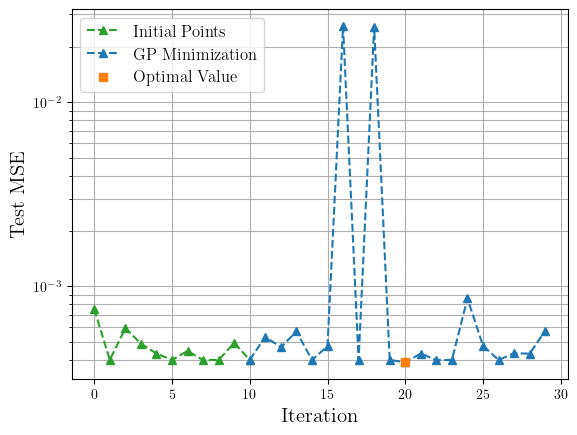

In [40]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(func_iters.shape[0])

if a > 0:
    plt.semilogy(
        func_iters[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, func_iters.shape[0])
plt.semilogy(
    xplot,
    func_iters[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [func_iters[optim_idx]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/test_mse.pdf', bbox_inches='tight', dpi=300)
plt.show()

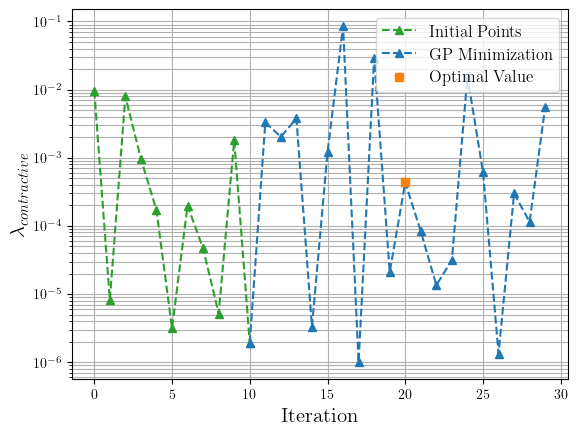

In [41]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        x_iters[:, 0][0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    x_iters[:, 0][a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
plt.semilogy([optim_idx], [x_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel('$\lambda_{contractive}$', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/contractive_lmda.pdf', bbox_inches='tight', dpi=300)
plt.show()

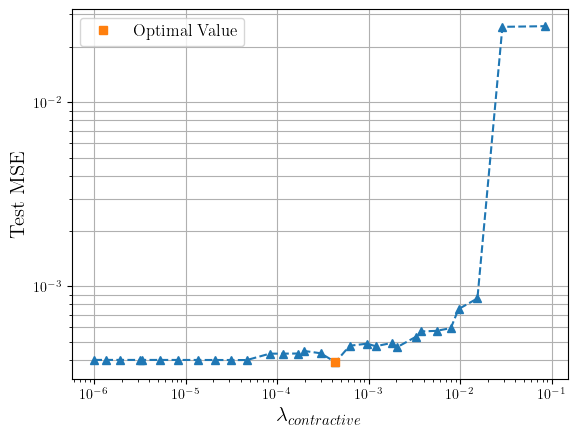

In [42]:
a = 0#n_initial_points
sorted_idx = np.argsort(x_iters[a:, 0])
# sorted_idx = np.arange(x_iters.shape[0]-a)

plt.loglog(
    x_iters[a:, 0][sorted_idx],
    func_iters[a:][sorted_idx],
    label='__nolegend__',
    marker='^',
    linestyle='--',
)
plt.loglog(x_iters[optim_idx, 0], [func_iters[optim_idx]], 's', label='Optimal Value')
plt.xlabel('$\lambda_{contractive}$', fontsize=15)
plt.ylabel('Test MSE', fontsize=15)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/test_mse_vs_contractive_lmda.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [43]:
optimized_vals_dict = {
    'x_iters':x_iters,
    'func_iters':func_iters,
    'optim_x':optim_x,
    'optim_idx':optim_idx,
    'optim_fun':func_iters[optim_idx]
}

with open(dir_name_ae_nsb+'/optimized_vals.txt', 'w') as f:
    f.write(str(optimized_vals_dict))
    
np.savez(
    dir_name_ae_nsb+'/optimized_vals',
    x_iters=x_iters,
    func_iters=func_iters,
    optim_x=optim_x,
    optim_idx=optim_idx,
    optim_fun=func_iters[optim_idx]
)

In [44]:
# convergence plot
convergence_test_mse = np.empty_like(func_iters)
min_val = np.inf
for i in range(func_iters.shape[0]):
    if func_iters[i] < min_val:
        min_val = func_iters[i]
    convergence_test_mse[i] = min_val

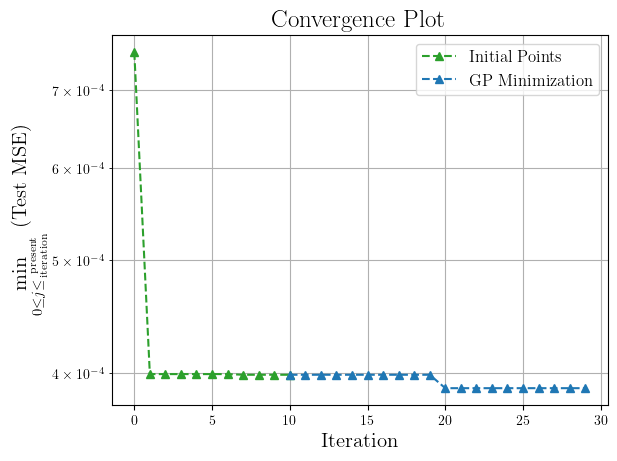

In [46]:
a = n_initial_points
# sorted_idx = np.argsort(x_iters[a:, 0])

xplot = np.arange(x_iters.shape[0])

if a > 0:
    plt.semilogy(
        convergence_test_mse[0:a+1],
        linestyle='--',
        color='C2',
        marker='^',
        label='Initial Points',
    )
    xplot = np.arange(a, x_iters.shape[0])
plt.semilogy(
    xplot,
    convergence_test_mse[a:],
    linestyle='--',
    marker='^',
    label='GP Minimization',#'__nolegend__',
)
# plt.semilogy([optim_idx], [func_iters[optim_idx, 0]], 's', label='Optimal Value')

plt.xlabel('Iteration', fontsize=15)
plt.ylabel(
    r"$$\min_{0 \leq j \leq \mathrm{present \atop iteration}} \left( \mathrm{Test \ MSE} \right)$$",
    fontsize=15,
)
plt.title('Convergence Plot', fontsize=18)
plt.grid(True, which='major', axis='x')
plt.grid(True, which='both', axis='y')
plt.legend(fontsize=12)

plt.savefig(dir_name_aensb_plots+'/convergence_plot.pdf', bbox_inches='tight', dpi=300)
plt.show()

# KE and Dissipation